### IMPORT THE LIBRARIES

In [7]:
import math
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import math
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sns
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import math
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from tqdm import tqdm

Using device: cuda


Reference took from here - https://github.com/tintn/vision-transformer-from-scratch

### DECLARE THE CONFIGURATION CLASS ( RESUSABLE)


In [ ]:
class ViTConfig:
    def __init__(
        self,
        image_size=32, 
        patch_size=4,
        num_channels=3,
        num_classes=10,
        hidden_size=384,
        num_attention_heads=6,
        num_hidden_layers=6,
        intermediate_size=768,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        initializer_range=0.02,
        qkv_bias=True,
        use_faster_attention=True,
        pos_embedding_type="1d"  # Options: "none", "1d", "2d", "sinusoidal" --> for the part involving the position embedding
    ):
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.intermediate_size = intermediate_size
        self.hidden_dropout_prob = hidden_dropout_prob
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.initializer_range = initializer_range
        self.qkv_bias = qkv_bias
        self.use_faster_attention = use_faster_attention
        self.pos_embedding_type = pos_embedding_type

    def to_dict(self):
        return {k: v for k, v in self.__dict__.items()}

### VIT IMPLEMENTATION

#### CREATE PATCH EMBEDDING LAYER

In [10]:
# Activation function module
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function as used in ViT.
    """
    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

# Patch embedding module
class PatchEmbeddings(nn.Module):
    """
    Convert the image into patches and then project them into a vector space.
    """
    def __init__(self, config):
        super().__init__()
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_channels = config.num_channels
        self.hidden_size = config.hidden_size
        # Calculate the number of patches from the image size and patch size
        self.num_patches = (self.image_size // self.patch_size) ** 2
        # Create a projection layer to convert the image into patches
        self.projection = nn.Conv2d(
            self.num_channels,
            self.hidden_size,
            kernel_size=self.patch_size,
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)  # Flatten the spatial dimensions and transpose
        return x


### DECLARE DIFFERENT POSITIONAL EMBEDDING

In [ ]:
# Position embeddings
class PositionalEmbedding(nn.Module):
    """
    Base class for various positional embedding strategies.
    """
    def __init__(self, config, num_patches):
        super().__init__()
        self.embedding_type = config.pos_embedding_type
        self.num_patches = num_patches
        self.hidden_size = config.hidden_size

    def forward(self, x):
        return x

class NoPositionalEmbedding(PositionalEmbedding):
    """
    No positional embedding (identity function).
    """
    def __init__(self, config, num_patches):
        super().__init__(config, num_patches)

class Learned1DPositionalEmbedding(PositionalEmbedding):
    """
    1D learnable positional embeddings as used in the original ViT paper.
    """
    def __init__(self, config, num_patches):
        super().__init__(config, num_patches)
        # Account for [CLS] token
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, config.hidden_size))

    def forward(self, x):
        return x + self.position_embeddings

class Learned2DPositionalEmbedding(PositionalEmbedding):
    """
    2D learnable positional embeddings as mentioned in Appendix D.4 of the ViT paper.
    """
    def __init__(self, config, num_patches):
        super().__init__(config, num_patches)
        self.grid_size = int(math.sqrt(num_patches))
        self.height_embedding = nn.Parameter(torch.randn(1, self.grid_size, 1, config.hidden_size))
        self.width_embedding = nn.Parameter(torch.randn(1, 1, self.grid_size, config.hidden_size))
        self.cls_embedding = nn.Parameter(torch.randn(1, 1, config.hidden_size))

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Handle the cls token separately
        cls_token = x[:, 0:1, :]
        patches = x[:, 1:, :]

        # Reshape patches to grid format: [batch, height, width, hidden]
        patches = patches.reshape(batch_size, self.grid_size, self.grid_size, self.hidden_size)

        # Add height and width positional embeddings
        patches = patches + self.height_embedding + self.width_embedding

        # Flatten back to sequence format
        patches = patches.reshape(batch_size, self.num_patches, self.hidden_size)

        # Combine cls token with positional embedding and patches
        cls_with_pos = cls_token + self.cls_embedding
        return torch.cat([cls_with_pos, patches], dim=1)

class SinusoidalPositionalEmbedding(PositionalEmbedding):
    """
    Sinusoidal positional embeddings from "Attention Is All You Need" paper.
    """
    def __init__(self, config, num_patches):
        super().__init__(config, num_patches)
        position = torch.arange(0, num_patches + 1).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, config.hidden_size, 2) * -(math.log(10000.0) / config.hidden_size))

        # Initialize positional encoding
        pe = torch.zeros(1, num_patches + 1, config.hidden_size)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe

def get_positional_embedding(config, num_patches):
    """Factory function to create the appropriate positional embedding."""
    if config.pos_embedding_type == "none":
        return NoPositionalEmbedding(config, num_patches)
    elif config.pos_embedding_type == "1d":
        return Learned1DPositionalEmbedding(config, num_patches)
    elif config.pos_embedding_type == "2d":
        return Learned2DPositionalEmbedding(config, num_patches)
    elif config.pos_embedding_type == "sinusoidal":
        return SinusoidalPositionalEmbedding(config, num_patches)
    else:
        raise ValueError(f"Unknown positional embedding type: {config.pos_embedding_type}")


In [13]:
# Complete embeddings module (patches + position + cls token)
class Embeddings(nn.Module):
    """
    Combine the patch embeddings with the class token and position embeddings.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.patch_embeddings = PatchEmbeddings(config)

        # Create a learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

        # Create position embeddings
        self.position_embedding = get_positional_embedding(
            config, self.patch_embeddings.num_patches
        )

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.patch_embeddings(x)
        batch_size, _, _ = x.size()

        # Expand the [CLS] token to the batch size
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Concatenate the [CLS] token to the beginning of the input sequence
        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embeddings
        x = self.position_embedding(x)

        return self.dropout(x)


#### Attention Modules

In [14]:
# Attention modules
class AttentionHead(nn.Module):
    """
    A single attention head for scaled dot-product attention.
    """
    def __init__(self, hidden_size, attention_head_size, dropout, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.attention_head_size = attention_head_size

        # Create the query, key, and value projection layers
        self.query = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.key = nn.Linear(hidden_size, attention_head_size, bias=bias)
        self.value = nn.Linear(hidden_size, attention_head_size, bias=bias)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Project the input into query, key, and value
        query = self.query(x)
        key = self.key(x)
        value = self.value(x)

        # Calculate the attention scores
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        # Calculate the attention output
        attention_output = torch.matmul(attention_probs, value)
        return attention_output, attention_probs

class MultiHeadAttention(nn.Module):
    """
    Multi-head attention module with separate attention heads.
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Create a list of attention heads
        self.heads = nn.ModuleList([
            AttentionHead(
                self.hidden_size,
                self.attention_head_size,
                config.attention_probs_dropout_prob,
                config.qkv_bias
            )
            for _ in range(self.num_attention_heads)
        ])

        # Output projection
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x, output_attentions=False):
        # Calculate the attention output for each head
        attention_outputs = [head(x) for head in self.heads]

        # Concatenate the attention outputs from each head
        attention_output = torch.cat([output for output, _ in attention_outputs], dim=-1)

        # Project the concatenated output back to hidden_size
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)

        if not output_attentions:
            return attention_output, None
        else:
            attention_probs = torch.stack([probs for _, probs in attention_outputs], dim=1)
            return attention_output, attention_probs

In [15]:
class FasterMultiHeadAttention(nn.Module):
    """
    Multi-head attention module with optimized implementation.
    """
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden_size
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = self.hidden_size // self.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Combined query, key, value projection
        self.qkv_projection = nn.Linear(self.hidden_size, self.all_head_size * 3, bias=config.qkv_bias)
        self.attn_dropout = nn.Dropout(config.attention_probs_dropout_prob)

        # Output projection
        self.output_projection = nn.Linear(self.all_head_size, self.hidden_size)
        self.output_dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x, output_attentions=False):
        batch_size, sequence_length, _ = x.size()

        # Project to query, key, value
        qkv = self.qkv_projection(x)
        query, key, value = torch.chunk(qkv, 3, dim=-1)

        # Resize to [batch, heads, seq_len, head_dim]
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key = key.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value = value.view(batch_size, sequence_length, self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        # Compute attention
        attention_scores = torch.matmul(query, key.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.attn_dropout(attention_probs)

        # Apply attention to values
        attention_output = torch.matmul(attention_probs, value)

        # Reshape back to [batch, seq_len, all_head_size]
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, sequence_length, self.all_head_size
        )

        # Output projection
        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)

        if not output_attentions:
            return attention_output, None
        else:
            return attention_output, attention_probs

#### MLP Modules

In [16]:
# MLP module
class MLP(nn.Module):
    """
    Multi-layer perceptron module for transformer blocks.
    """
    def __init__(self, config):
        super().__init__()
        self.dense_1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

# Transformer block
class Block(nn.Module):
    """
    A single transformer encoder block.
    """
    def __init__(self, config):
        super().__init__()
        if config.use_faster_attention:
            self.attention = FasterMultiHeadAttention(config)
        else:
            self.attention = MultiHeadAttention(config)

        self.layernorm_1 = nn.LayerNorm(config.hidden_size)
        self.mlp = MLP(config)
        self.layernorm_2 = nn.LayerNorm(config.hidden_size)

    def forward(self, x, output_attentions=False):
        # Self-attention with pre-norm
        attn_output, attention_probs = self.attention(
            self.layernorm_1(x), output_attentions=output_attentions
        )
        # Skip connection
        x = x + attn_output

        # MLP with pre-norm
        mlp_output = self.mlp(self.layernorm_2(x))
        # Skip connection
        x = x + mlp_output

        if not output_attentions:
            return x, None
        else:
            return x, attention_probs

# Transformer encoder
class Encoder(nn.Module):
    """
    The transformer encoder with multiple blocks.
    """
    def __init__(self, config):
        super().__init__()
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.num_hidden_layers)])

    def forward(self, x, output_attentions=False):
        all_attentions = [] if output_attentions else None

        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)

        return x, all_attentions

#### Final ViT Class

In [17]:
# Full ViT model
class ViTForClassification(nn.Module):
    """
    Vision Transformer for image classification.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Input embedding
        self.embedding = Embeddings(config)

        # Transformer encoder
        self.encoder = Encoder(config)

        # Classification head
        self.layernorm = nn.LayerNorm(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

        # Initialize weights
        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Embed the input
        x = self.embedding(x)

        # Encode the input
        x, all_attentions = self.encoder(x, output_attentions=output_attentions)

        # Use the CLS token for classification
        x = self.layernorm(x[:, 0])  # Take only the [CLS] token representation
        logits = self.classifier(x)

        if not output_attentions:
            return logits
        else:
            return logits, all_attentions

    def _init_weights(self, module):
        """Initialize the weights according to the original paper."""
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            # For positional embeddings initialization
            if hasattr(module.position_embedding, 'position_embeddings'):
                pos_embed = module.position_embedding.position_embeddings
                pos_embed.data = nn.init.trunc_normal_(
                    pos_embed.data.to(torch.float32),
                    mean=0.0,
                    std=self.config.initializer_range,
                ).to(pos_embed.dtype)

            # For cls token initialization
            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=self.config.initializer_range,
            ).to(module.cls_token.dtype)

### PREPROCESSING THE DATA

In [18]:
# Data loading and augmentation
def get_transforms(augmentation_level="none"):
    """
    Get transformations for data augmentation at different levels.

    Args:
        augmentation_level: Level of augmentation ('none', 'basic', 'medium', 'strong')
    """
    if augmentation_level == "none":
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])
    elif augmentation_level == "basic":
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])
    elif augmentation_level == "medium":
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ])
    elif augmentation_level == "strong":
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
            transforms.RandomErasing(p=0.2),
        ])
    else:
        raise ValueError(f"Unknown augmentation level: {augmentation_level}")

    # Test transform is always the same
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])

    return train_transform, test_transform

### Obtain the Data Loaders

In [19]:
def get_data_loaders(batch_size=128, augmentation_level="none", val_split=0.1):
    """
    Get train, validation, and test data loaders.
    """
    train_transform, test_transform = get_transforms(augmentation_level)

    # Load the CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )

    # Split into train and validation
    val_size = int(len(train_dataset) * val_split)
    train_size = len(train_dataset) - val_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_dataset = datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=test_transform
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, test_loader

### Training the Model

In [20]:
# Training and evaluation functions
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler=None):
    """Train the model for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_bar = tqdm(train_loader, desc="Training")
    for inputs, targets in train_bar:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        train_bar.set_postfix({
            'loss': running_loss / total,
            'acc': 100.0 * correct / total
        })

    if scheduler:
        scheduler.step()

    return running_loss / total, 100.0 * correct / total


In [21]:
def evaluate(model, data_loader, criterion):
    """Evaluate the model on the given data loader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return running_loss / total, 100.0 * correct / total

### Visualization utilities


In [ ]:
def plot_loss_acc_curves(train_losses, val_losses, train_accs, val_accs, title):
    """Plot loss and accuracy curves."""
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss Curves')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} - Accuracy Curves')
    plt.legend()

    plt.tight_layout()

    # Save the figure
    os.makedirs('plots', exist_ok=True)
    plt.show()
    plt.savefig(f'plots/{title.replace(" ", "_").lower()}.png')
    plt.close()

In [23]:
def visualize_attention_maps(model, test_loader, num_images=5):
    """Visualize attention maps for a few test images."""
    model.eval()

    # Get some test images
    test_iter = iter(test_loader)
    images, _ = next(test_iter)
    images = images[:num_images].to(device)

    # Get attention maps
    with torch.no_grad():
        _, attentions = model(images, output_attentions=True)

    # Plot attention maps (using last layer's attention)
    fig, axes = plt.subplots(num_images, model.config.num_attention_heads + 1, figsize=(20, 4 * num_images))

    for i in range(num_images):
        # Original image
        img = images[i].cpu().permute(1, 2, 0)
        # Normalize image for display
        img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])
        img = torch.clamp(img, 0, 1)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        # Get attention maps for the CLS token
        # Last layer's attention, all heads
        layer_attentions = attentions[-1][i]  # [num_heads, seq_len, seq_len]

        # Plot attention from CLS token to patches for each head
        for h in range(model.config.num_attention_heads):
            # Get attention from CLS token to all tokens
            attn = layer_attentions[h, 0, 1:].reshape(int(math.sqrt(layer_attentions.size(1)-1)),
                                                     int(math.sqrt(layer_attentions.size(1)-1)))
            axes[i, h + 1].imshow(attn.cpu().numpy())
            axes[i, h + 1].set_title(f"Head {h+1}")
            axes[i, h + 1].axis('off')

    plt.tight_layout()
    os.makedirs('plots', exist_ok=True)
    plt.show()
    plt.savefig('plots/attention_visualization.png')
    plt.close()


### MAIN EXPERIMENT RUNNER FUNCTION

In [ ]:
def run_experiment(config, epochs=50, batch_size=128, augmentation_level="none", exp_name="default", patience=3):
    """Run a complete training experiment with the given configuration, with early stopping."""
    # Create model

    model = ViTForClassification(config).to(device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Get data loaders
    train_loader, val_loader, test_loader = get_data_loaders(
        batch_size=batch_size,
        augmentation_level=augmentation_level
    )

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Training tracking
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float('inf')
    best_val_acc = 0.0
    epochs_no_improve = 0

    # Create directory for saving models
    os.makedirs('models', exist_ok=True)

    # Training loop
    print(f"Starting experiment: {exp_name}")
    start_time = time.time()

    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'models/{exp_name}_best.pth')
            print("  Validation loss improved. Saving model.")
        else:
            epochs_no_improve += 1
            print(f"  No improvement in val loss for {epochs_no_improve} epochs.")
            if epochs_no_improve >= patience:
                print("  Early stopping triggered.")
                break

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Load best model for evaluation
    model.load_state_dict(torch.load(f'models/{exp_name}_best.pth'))
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Plot learning curves
    plot_loss_acc_curves(
        train_losses, val_losses, train_accs, val_accs,
        title=f"{exp_name} - Early Stopping @ epoch {epoch+1}"
    )

    # Visualize attention maps
    visualize_attention_maps(model, test_loader)

    elapsed_time = time.time() - start_time
    print(f"Experiment completed in {elapsed_time/60:.2f} minutes")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'test_acc': test_acc,
        'best_val_acc': best_val_acc,
        'elapsed_time': elapsed_time,
        'stopped_epoch': epoch + 1
    }

### FUNCTION TO COMPARE PATCH SIZE 

In [25]:
def compare_patch_sizes(epochs=50, base_config=None):
    """Run experiments with different patch sizes."""
    if base_config is None:
        base_config = ViTConfig()

    results = {}
    patch_sizes = [2, 4, 8]

    for patch_size in patch_sizes:
        print(f"\n{'='*50}")
        print(f"Running experiment with patch size {patch_size}")
        print(f"{'='*50}")

        # Create new config with current patch size
        config = ViTConfig(
            patch_size=patch_size,
            hidden_size=base_config.hidden_size,
            num_attention_heads=base_config.num_attention_heads,
            num_hidden_layers=base_config.num_hidden_layers,
            intermediate_size=base_config.intermediate_size
        )

        # Adjust batch size based on patch size (larger patches = less memory)
        batch_size = 64 if patch_size == 2 else 128

        # Run experiment
        exp_name = f"patch_size_{patch_size}"
        results[patch_size] = run_experiment(
            config, epochs=epochs, batch_size=batch_size, exp_name=exp_name
        )

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot test accuracies
    plt.subplot(2, 2, 1)
    for patch_size in patch_sizes:
        plt.plot(results[patch_size]['val_accs'], label=f'Patch Size {patch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy vs. Patch Size')
    plt.legend()

    # Plot training losses
    plt.subplot(2, 2, 2)
    for patch_size in patch_sizes:
        plt.plot(results[patch_size]['train_losses'], label=f'Patch Size {patch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Patch Size')
    plt.legend()

    # Plot validation losses
    plt.subplot(2, 2, 3)
    for patch_size in patch_sizes:
        plt.plot(results[patch_size]['val_losses'], label=f'Patch Size {patch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss vs. Patch Size')
    plt.legend()

    # Bar chart of final test accuracies
    plt.subplot(2, 2, 4)
    plt.bar([str(p) for p in patch_sizes], [results[p]['test_acc'] for p in patch_sizes])
    plt.xlabel('Patch Size')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Final Test Accuracy')

    plt.tight_layout()
    plt.show()
    plt.savefig('plots/patch_size_comparison.png')
    plt.close()

    return results


### FUNCTION TO COMPARE DIFFERENT HYPERPARAMETERS

In [26]:
def explore_hyperparameters(epochs=50):
    """Explore different hyperparameter combinations."""
    # Hyperparameter combinations to try

    configs = [
    # Config 1: High capacity with regularization (Best Overall)
    ViTConfig(
        patch_size=4,
        hidden_size=512,
        num_attention_heads=8,
        num_hidden_layers=8,
        intermediate_size=1024,
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1
    ),

    # Config 2: Slightly wider MLP, more dropout
    ViTConfig(
        patch_size=4,
        hidden_size=384,
        num_attention_heads=6,
        num_hidden_layers=9,
        intermediate_size=1536,  # 4x hidden size
        hidden_dropout_prob=0.2,
        attention_probs_dropout_prob=0.2
    ),

    # Config 3: Lighter model, still strong generalization
    ViTConfig(
        patch_size=4,
        hidden_size=384,
        num_attention_heads=6,
        num_hidden_layers=7,
        intermediate_size=768,
        hidden_dropout_prob=0.15,
        attention_probs_dropout_prob=0.15
    )
]
    results = {}

    # Run experiments for each config
    for i, config in enumerate(configs):
        print(f"\n{'='*50}")
        print(f"Running hyperparameter configuration {i+1}")
        print(f"Hidden size: {config.hidden_size}, Layers: {config.num_hidden_layers}, "
              f"Heads: {config.num_attention_heads}, MLP size: {config.intermediate_size}")
        print(f"{'='*50}")

        exp_name = f"hyperparams_config_{i+1}"
        results[i + 1] = run_experiment(config, epochs=epochs, exp_name=exp_name)

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot validation accuracies
    plt.subplot(2, 2, 1)
    for i in range(len(configs)):
        plt.plot(results[i+1]['val_accs'], label=f'Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy vs. Configuration')
    plt.legend()

    # Plot training losses
    plt.subplot(2, 2, 2)
    for i in range(len(configs)):
        plt.plot(results[i+1]['train_losses'], label=f'Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Configuration')
    plt.legend()

    # Bar chart of final test accuracies
    plt.subplot(2, 2, 3)
    plt.bar([f'Config {i+1}' for i in range(len(configs))],
            [results[i+1]['test_acc'] for i in range(len(configs))])
    plt.xlabel('Configuration')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Final Test Accuracy')

    # Bar chart of training times
    plt.subplot(2, 2, 4)
    plt.bar([f'Config {i+1}' for i in range(len(configs))],
            [results[i+1]['elapsed_time']/60 for i in range(len(configs))])
    plt.xlabel('Configuration')
    plt.ylabel('Training Time (minutes)')
    plt.title('Training Time')

    plt.tight_layout()
    plt.show()
    plt.savefig('plots/hyperparameter_comparison.png')
    plt.close()

    # Print best config
    best_config_idx = max(range(1, len(configs)+1), key=lambda i: results[i]['test_acc'])
    best_config = configs[best_config_idx-1]
    print(f"\nBest hyperparameter configuration (Config {best_config_idx}):")
    print(f"Test accuracy: {results[best_config_idx]['test_acc']:.2f}%")
    print(f"Hidden size: {best_config.hidden_size}, Layers: {best_config.num_hidden_layers}, "
          f"Heads: {best_config.num_attention_heads}, MLP size: {best_config.intermediate_size}")

    return results, best_config

### FUNCTION TO COMPARE DIFFERENT AUGMENTATIONS

In [27]:
def compare_augmentations(epochs=50, config=None):
    """Compare different data augmentation techniques."""
    if config is None:
        config = ViTConfig()

    augmentation_levels = ["none", "basic", "medium", "strong"]
    results = {}

    for aug_level in augmentation_levels:
        print(f"\n{'='*50}")
        print(f"Running experiment with augmentation level: {aug_level}")
        print(f"{'='*50}")

        exp_name = f"augmentation_{aug_level}"
        results[aug_level] = run_experiment(
            config, epochs=epochs, augmentation_level=aug_level, exp_name=exp_name
        )

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot validation accuracies
    plt.subplot(2, 2, 1)
    for aug_level in augmentation_levels:
        plt.plot(results[aug_level]['val_accs'], label=f'{aug_level}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy vs. Augmentation')
    plt.legend()

    # Plot training losses
    plt.subplot(2, 2, 2)
    for aug_level in augmentation_levels:
        plt.plot(results[aug_level]['train_losses'], label=f'{aug_level}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Augmentation')
    plt.legend()

    # Bar chart of final test accuracies
    plt.subplot(2, 2, 3)
    plt.bar(augmentation_levels, [results[aug]['test_acc'] for aug in augmentation_levels])
    plt.xlabel('Augmentation Level')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Final Test Accuracy')

    plt.tight_layout()
    plt.show()
    plt.savefig('plots/augmentation_comparison.png')
    plt.close()

    # Print best augmentation
    best_aug = max(augmentation_levels, key=lambda aug: results[aug]['test_acc'])
    print(f"\nBest augmentation level: {best_aug}")
    print(f"Test accuracy: {results[best_aug]['test_acc']:.2f}%")

    return results, best_aug


### FUNCTION TO COMPARE DIFFERENT EMBEDDINGS

In [28]:
def compare_position_embeddings(epochs=50, config=None):
    """Compare different positional embedding types."""
    if config is None:
        config = ViTConfig()

    embedding_types = ["none", "1d", "2d", "sinusoidal"]
    results = {}

    for emb_type in embedding_types:
        print(f"\n{'='*50}")
        print(f"Running experiment with positional embedding: {emb_type}")
        print(f"{'='*50}")

        # Create new config with current embedding type
        config_copy = ViTConfig(
            patch_size=config.patch_size,
            hidden_size=config.hidden_size,
            num_attention_heads=config.num_attention_heads,
            num_hidden_layers=config.num_hidden_layers,
            intermediate_size=config.intermediate_size,
            pos_embedding_type=emb_type
        )

        exp_name = f"pos_embedding_{emb_type}"
        results[emb_type] = run_experiment(config_copy, epochs=epochs, exp_name=exp_name)

    # Plot comparison
    plt.figure(figsize=(15, 10))

    # Plot validation accuracies
    plt.subplot(2, 2, 1)
    for emb_type in embedding_types:
        plt.plot(results[emb_type]['val_accs'], label=f'{emb_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy vs. Positional Embedding')
    plt.legend()

    # Plot training losses
    plt.subplot(2, 2, 2)
    for emb_type in embedding_types:
        plt.plot(results[emb_type]['train_losses'], label=f'{emb_type}')
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss vs. Positional Embedding')
    plt.legend()

    # Bar chart of final test accuracies
    plt.subplot(2, 2, 3)
    plt.bar(embedding_types, [results[emb]['test_acc'] for emb in embedding_types])
    plt.xlabel('Positional Embedding Type')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Final Test Accuracy')

    plt.tight_layout()
    plt.show()
    plt.savefig('plots/position_embedding_comparison.png')
    plt.close()

    # Print best embedding type
    best_emb = max(embedding_types, key=lambda emb: results[emb]['test_acc'])
    print(f"\nBest positional embedding type: {best_emb}")
    print(f"Test accuracy: {results[best_emb]['test_acc']:.2f}%")

    return results, best_emb


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Create a base configuration for the experiments
base_config = ViTConfig(
    patch_size=4,
    hidden_size=384,
    num_attention_heads=4,
    num_hidden_layers=4,
    intermediate_size=384,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    pos_embedding_type="1d"
)

## EXPERIMENT 1 - PATCH SIZE VARIATION


EXPERIMENT 1: PATCH SIZE VARIATION

Running experiment with patch size 2
Model parameters: 3,662,986
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: patch_size_2


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1.69, acc=37.3]


  Validation loss improved. Saving model.
Epoch 1/30: Train Loss: 1.6919, Train Acc: 37.33%, Val Loss: 1.4348, Val Acc: 46.48%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1.36, acc=50.3]


  Validation loss improved. Saving model.
Epoch 2/30: Train Loss: 1.3636, Train Acc: 50.27%, Val Loss: 1.3305, Val Acc: 52.02%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1.25, acc=55]  


  Validation loss improved. Saving model.
Epoch 3/30: Train Loss: 1.2460, Train Acc: 54.99%, Val Loss: 1.2296, Val Acc: 55.38%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1.17, acc=57.8]


  Validation loss improved. Saving model.
Epoch 4/30: Train Loss: 1.1659, Train Acc: 57.80%, Val Loss: 1.1740, Val Acc: 57.84%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1.1, acc=60.3] 


  Validation loss improved. Saving model.
Epoch 5/30: Train Loss: 1.1031, Train Acc: 60.26%, Val Loss: 1.1221, Val Acc: 60.04%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1.04, acc=62.5]


  Validation loss improved. Saving model.
Epoch 6/30: Train Loss: 1.0447, Train Acc: 62.47%, Val Loss: 1.1123, Val Acc: 60.54%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=1, acc=64.1]    


  Validation loss improved. Saving model.
Epoch 7/30: Train Loss: 1.0038, Train Acc: 64.07%, Val Loss: 1.0686, Val Acc: 61.46%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, loss=0.955, acc=65.9]


  Validation loss improved. Saving model.
Epoch 8/30: Train Loss: 0.9555, Train Acc: 65.92%, Val Loss: 1.0431, Val Acc: 62.96%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=0.915, acc=67.2]


  Validation loss improved. Saving model.
Epoch 9/30: Train Loss: 0.9151, Train Acc: 67.23%, Val Loss: 1.0243, Val Acc: 64.14%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.23it/s, loss=0.876, acc=68.6]


  Validation loss improved. Saving model.
Epoch 10/30: Train Loss: 0.8759, Train Acc: 68.58%, Val Loss: 1.0151, Val Acc: 64.46%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, loss=0.837, acc=70.2]


  No improvement in val loss for 1 epochs.
Epoch 11/30: Train Loss: 0.8373, Train Acc: 70.19%, Val Loss: 1.0164, Val Acc: 64.34%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, loss=0.798, acc=71.5]


  Validation loss improved. Saving model.
Epoch 12/30: Train Loss: 0.7985, Train Acc: 71.49%, Val Loss: 0.9719, Val Acc: 66.26%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, loss=0.759, acc=73]  


  No improvement in val loss for 1 epochs.
Epoch 13/30: Train Loss: 0.7593, Train Acc: 72.96%, Val Loss: 0.9844, Val Acc: 65.56%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, loss=0.718, acc=74.5]


  No improvement in val loss for 2 epochs.
Epoch 14/30: Train Loss: 0.7180, Train Acc: 74.50%, Val Loss: 0.9793, Val Acc: 67.32%


Training: 100%|██████████| 704/704 [01:16<00:00,  9.22it/s, loss=0.676, acc=75.9]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.


/tmp/ipykernel_31/4049654737.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{exp_name}_best.pth'))


Test Loss: 0.9554, Test Acc: 66.39%
Experiment completed in 19.93 minutes

Running experiment with patch size 4
Model parameters: 3,603,082
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: patch_size_4


Training: 100%|██████████| 352/352 [00:17<00:00, 20.19it/s, loss=1.75, acc=35]  


  Validation loss improved. Saving model.
Epoch 1/30: Train Loss: 1.7548, Train Acc: 35.01%, Val Loss: 1.5044, Val Acc: 46.12%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.25it/s, loss=1.41, acc=48.8]


  Validation loss improved. Saving model.
Epoch 2/30: Train Loss: 1.4061, Train Acc: 48.78%, Val Loss: 1.3109, Val Acc: 52.04%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.21it/s, loss=1.29, acc=53.1]


  Validation loss improved. Saving model.
Epoch 3/30: Train Loss: 1.2943, Train Acc: 53.08%, Val Loss: 1.2410, Val Acc: 55.52%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.25it/s, loss=1.23, acc=55.7]


  Validation loss improved. Saving model.
Epoch 4/30: Train Loss: 1.2251, Train Acc: 55.74%, Val Loss: 1.1811, Val Acc: 57.42%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.24it/s, loss=1.17, acc=57.6]


  Validation loss improved. Saving model.
Epoch 5/30: Train Loss: 1.1744, Train Acc: 57.58%, Val Loss: 1.1274, Val Acc: 59.96%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.24it/s, loss=1.12, acc=59.4]


  No improvement in val loss for 1 epochs.
Epoch 6/30: Train Loss: 1.1245, Train Acc: 59.36%, Val Loss: 1.1422, Val Acc: 58.68%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.22it/s, loss=1.09, acc=60.9]


  Validation loss improved. Saving model.
Epoch 7/30: Train Loss: 1.0850, Train Acc: 60.92%, Val Loss: 1.0748, Val Acc: 60.62%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.23it/s, loss=1.04, acc=62.4]


  Validation loss improved. Saving model.
Epoch 8/30: Train Loss: 1.0444, Train Acc: 62.44%, Val Loss: 1.0677, Val Acc: 61.54%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.24it/s, loss=1, acc=64]     


  Validation loss improved. Saving model.
Epoch 9/30: Train Loss: 1.0036, Train Acc: 64.02%, Val Loss: 1.0149, Val Acc: 63.66%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.21it/s, loss=0.966, acc=65.2]


  No improvement in val loss for 1 epochs.
Epoch 10/30: Train Loss: 0.9663, Train Acc: 65.24%, Val Loss: 1.0767, Val Acc: 61.62%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.24it/s, loss=0.928, acc=66.5]


  Validation loss improved. Saving model.
Epoch 11/30: Train Loss: 0.9279, Train Acc: 66.55%, Val Loss: 0.9831, Val Acc: 65.40%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.21it/s, loss=0.89, acc=68.1] 


  No improvement in val loss for 1 epochs.
Epoch 12/30: Train Loss: 0.8896, Train Acc: 68.05%, Val Loss: 0.9999, Val Acc: 65.00%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.22it/s, loss=0.848, acc=69.3]


  Validation loss improved. Saving model.
Epoch 13/30: Train Loss: 0.8475, Train Acc: 69.25%, Val Loss: 0.9812, Val Acc: 65.90%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.23it/s, loss=0.806, acc=70.8]


  Validation loss improved. Saving model.
Epoch 14/30: Train Loss: 0.8064, Train Acc: 70.82%, Val Loss: 0.9671, Val Acc: 66.12%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.20it/s, loss=0.756, acc=72.6]


  No improvement in val loss for 1 epochs.
Epoch 15/30: Train Loss: 0.7557, Train Acc: 72.61%, Val Loss: 0.9805, Val Acc: 65.88%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.21it/s, loss=0.712, acc=74.3]


  No improvement in val loss for 2 epochs.
Epoch 16/30: Train Loss: 0.7118, Train Acc: 74.28%, Val Loss: 0.9750, Val Acc: 66.52%


Training: 100%|██████████| 352/352 [00:17<00:00, 20.23it/s, loss=0.662, acc=76.1]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0268, Test Acc: 64.57%
Experiment completed in 5.25 minutes

Running experiment with patch size 8
Model parameters: 3,639,946
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: patch_size_8


Training: 100%|██████████| 352/352 [00:07<00:00, 44.66it/s, loss=1.8, acc=33.9] 


  Validation loss improved. Saving model.
Epoch 1/30: Train Loss: 1.7973, Train Acc: 33.86%, Val Loss: 1.6202, Val Acc: 40.80%


Training: 100%|██████████| 352/352 [00:07<00:00, 45.19it/s, loss=1.55, acc=43.3]


  Validation loss improved. Saving model.
Epoch 2/30: Train Loss: 1.5491, Train Acc: 43.25%, Val Loss: 1.4906, Val Acc: 45.02%


Training: 100%|██████████| 352/352 [00:07<00:00, 44.21it/s, loss=1.43, acc=47.8]


  Validation loss improved. Saving model.
Epoch 3/30: Train Loss: 1.4292, Train Acc: 47.79%, Val Loss: 1.3981, Val Acc: 49.48%


Training: 100%|██████████| 352/352 [00:07<00:00, 45.07it/s, loss=1.33, acc=51.6]


  Validation loss improved. Saving model.
Epoch 4/30: Train Loss: 1.3334, Train Acc: 51.61%, Val Loss: 1.3196, Val Acc: 51.56%


Training: 100%|██████████| 352/352 [00:08<00:00, 43.89it/s, loss=1.26, acc=54.4]


  Validation loss improved. Saving model.
Epoch 5/30: Train Loss: 1.2604, Train Acc: 54.41%, Val Loss: 1.2801, Val Acc: 54.40%


Training: 100%|██████████| 352/352 [00:07<00:00, 44.93it/s, loss=1.2, acc=56.8] 


  Validation loss improved. Saving model.
Epoch 6/30: Train Loss: 1.1989, Train Acc: 56.75%, Val Loss: 1.2103, Val Acc: 56.86%


Training: 100%|██████████| 352/352 [00:07<00:00, 45.08it/s, loss=1.14, acc=58.9]


  Validation loss improved. Saving model.
Epoch 7/30: Train Loss: 1.1395, Train Acc: 58.90%, Val Loss: 1.1870, Val Acc: 57.66%


Training: 100%|██████████| 352/352 [00:07<00:00, 45.21it/s, loss=1.08, acc=61.1]


  Validation loss improved. Saving model.
Epoch 8/30: Train Loss: 1.0812, Train Acc: 61.10%, Val Loss: 1.1637, Val Acc: 59.22%


Training: 100%|██████████| 352/352 [00:07<00:00, 44.99it/s, loss=1.02, acc=63.3] 


  Validation loss improved. Saving model.
Epoch 9/30: Train Loss: 1.0242, Train Acc: 63.27%, Val Loss: 1.1271, Val Acc: 60.34%


Training: 100%|██████████| 352/352 [00:08<00:00, 43.72it/s, loss=0.969, acc=65.4]


  No improvement in val loss for 1 epochs.
Epoch 10/30: Train Loss: 0.9688, Train Acc: 65.41%, Val Loss: 1.1433, Val Acc: 59.14%


Training: 100%|██████████| 352/352 [00:08<00:00, 43.16it/s, loss=0.922, acc=66.8]


  Validation loss improved. Saving model.
Epoch 11/30: Train Loss: 0.9224, Train Acc: 66.78%, Val Loss: 1.0944, Val Acc: 62.22%


Training: 100%|██████████| 352/352 [00:07<00:00, 45.59it/s, loss=0.865, acc=68.9]


  Validation loss improved. Saving model.
Epoch 12/30: Train Loss: 0.8648, Train Acc: 68.88%, Val Loss: 1.0614, Val Acc: 62.28%


Training: 100%|██████████| 352/352 [00:07<00:00, 47.21it/s, loss=0.81, acc=71]   


  Validation loss improved. Saving model.
Epoch 13/30: Train Loss: 0.8103, Train Acc: 71.00%, Val Loss: 1.0563, Val Acc: 64.16%


Training: 100%|██████████| 352/352 [00:07<00:00, 44.46it/s, loss=0.745, acc=73.3]


  No improvement in val loss for 1 epochs.
Epoch 14/30: Train Loss: 0.7450, Train Acc: 73.32%, Val Loss: 1.0794, Val Acc: 64.14%


Training: 100%|██████████| 352/352 [00:07<00:00, 44.80it/s, loss=0.69, acc=75.2] 


  No improvement in val loss for 2 epochs.
Epoch 15/30: Train Loss: 0.6903, Train Acc: 75.21%, Val Loss: 1.0739, Val Acc: 64.28%


Training: 100%|██████████| 352/352 [00:07<00:00, 45.09it/s, loss=0.639, acc=77.1]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0762, Test Acc: 63.25%
Experiment completed in 2.37 minutes


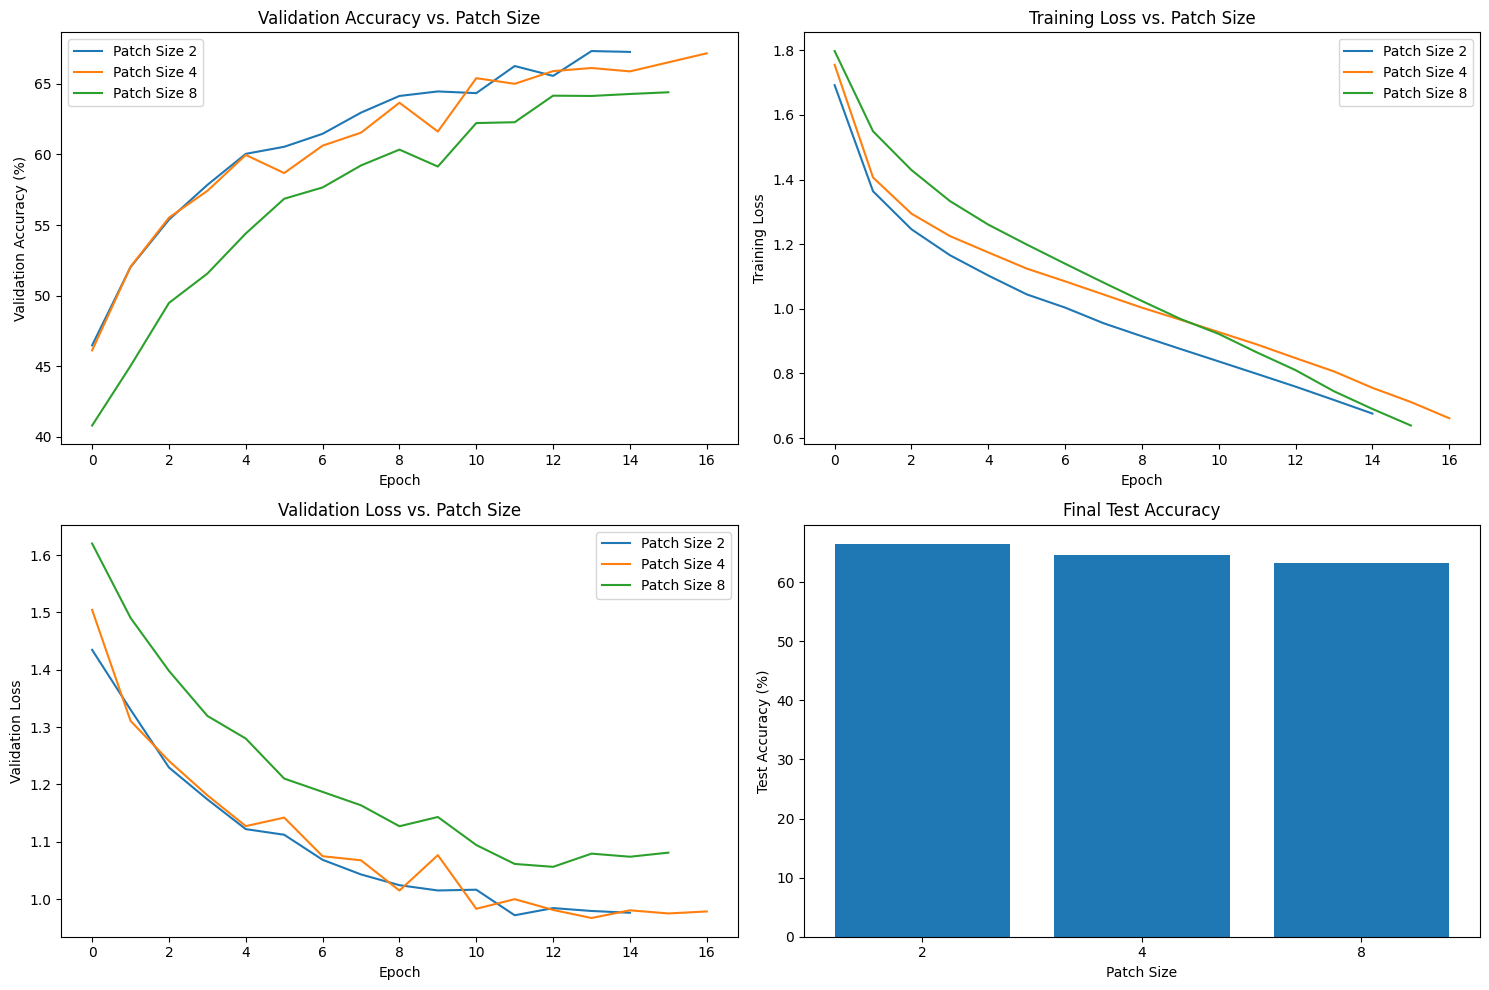

In [ ]:
print("\n" + "="*80)
print("EXPERIMENT 1: PATCH SIZE VARIATION")
print("="*80)
patch_results = compare_patch_sizes(epochs=30, base_config=base_config)

##### Smaller patch sizes (especially patch size 2) lead to better validation and test accuracy, as well as lower training and validation loss. However, they also likely require more computation due to longer sequences. There’s a trade-off between performance and efficiency — smaller patches give better results, but at a higher computational cost.

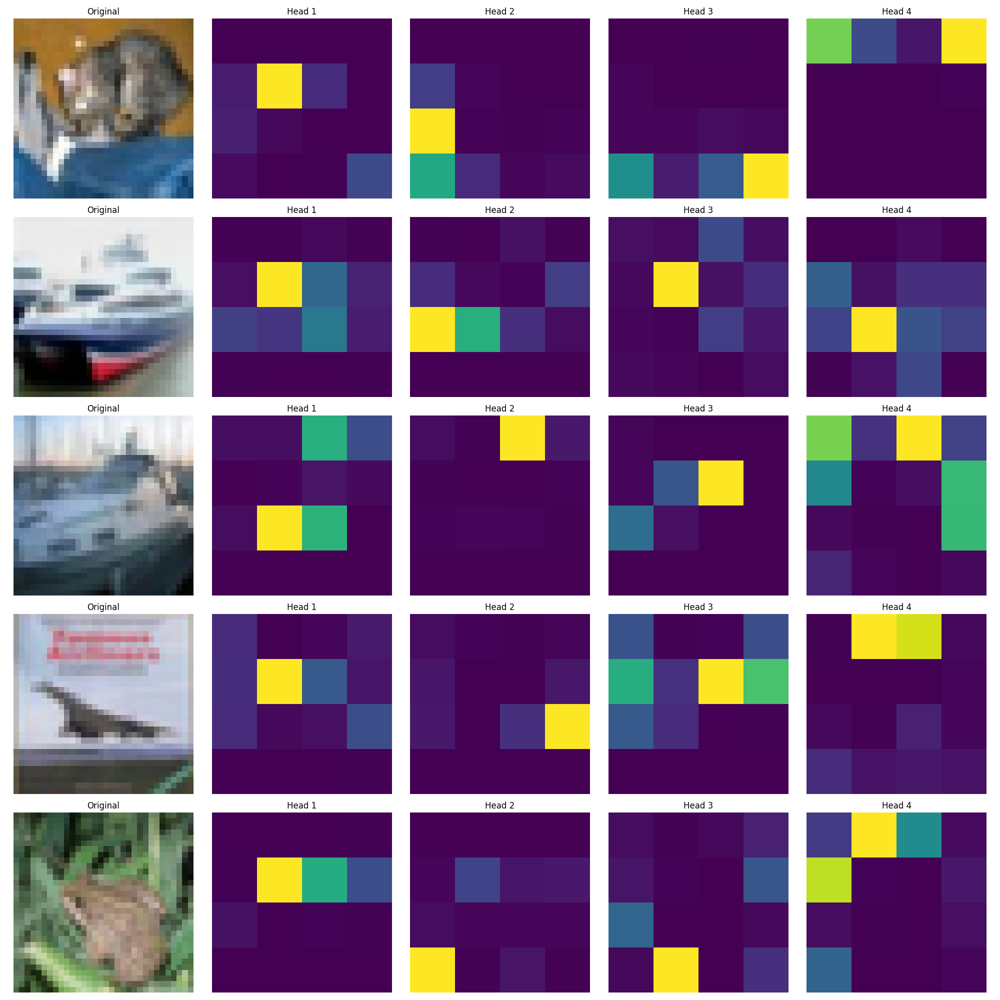

In [ ]:
# Create a base configuration for the experiment
base_config = ViTConfig(
    patch_size=2,
    hidden_size=384,
    num_attention_heads=4,
    num_hidden_layers=4,
    intermediate_size=384,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    pos_embedding_type="1d"
)

# Initialize model and load the matching state_dict
model = ViTForClassification(base_config).to(device)
state_dict = torch.load('/kaggle/working/models/patch_size_2_best.pth', map_location=device)
model.load_state_dict(state_dict)

train_loader, val_loader, test_loader = get_data_loaders(
    batch_size=64,
    augmentation_level="none"
)

visualize_attention_maps(model, test_loader, num_images=5)

## Experiment 2: Hyperparameter exploration



EXPERIMENT 2: HYPERPARAMETER EXPLORATION

Running hyperparameter configuration 1
Hidden size: 512, Layers: 8, Heads: 8, MLP size: 1024
Model parameters: 16,887,306
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: hyperparams_config_1


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=1.78, acc=33.6]


  Validation loss improved. Saving model.
Epoch 1/30: Train Loss: 1.7799, Train Acc: 33.61%, Val Loss: 1.5279, Val Acc: 43.68%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=1.42, acc=48.2]


  Validation loss improved. Saving model.
Epoch 2/30: Train Loss: 1.4176, Train Acc: 48.16%, Val Loss: 1.3265, Val Acc: 51.90%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=1.29, acc=53.3]


  Validation loss improved. Saving model.
Epoch 3/30: Train Loss: 1.2856, Train Acc: 53.30%, Val Loss: 1.2508, Val Acc: 55.40%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=1.21, acc=56.3]


  Validation loss improved. Saving model.
Epoch 4/30: Train Loss: 1.2114, Train Acc: 56.28%, Val Loss: 1.2069, Val Acc: 56.86%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=1.15, acc=58.3]


  Validation loss improved. Saving model.
Epoch 5/30: Train Loss: 1.1513, Train Acc: 58.30%, Val Loss: 1.1828, Val Acc: 57.46%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=1.11, acc=60]  


  Validation loss improved. Saving model.
Epoch 6/30: Train Loss: 1.1050, Train Acc: 60.02%, Val Loss: 1.1458, Val Acc: 58.72%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=1.06, acc=61.8]


  Validation loss improved. Saving model.
Epoch 7/30: Train Loss: 1.0595, Train Acc: 61.76%, Val Loss: 1.1215, Val Acc: 59.18%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=1.03, acc=62.9]


  Validation loss improved. Saving model.
Epoch 8/30: Train Loss: 1.0302, Train Acc: 62.95%, Val Loss: 1.0972, Val Acc: 60.28%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=0.996, acc=64.4]


  Validation loss improved. Saving model.
Epoch 9/30: Train Loss: 0.9958, Train Acc: 64.36%, Val Loss: 1.0822, Val Acc: 60.72%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=0.96, acc=65.5] 


  No improvement in val loss for 1 epochs.
Epoch 10/30: Train Loss: 0.9599, Train Acc: 65.55%, Val Loss: 1.1258, Val Acc: 60.70%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=0.919, acc=67]  


  Validation loss improved. Saving model.
Epoch 11/30: Train Loss: 0.9185, Train Acc: 66.98%, Val Loss: 1.0757, Val Acc: 62.06%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.882, acc=68.5]


  Validation loss improved. Saving model.
Epoch 12/30: Train Loss: 0.8821, Train Acc: 68.50%, Val Loss: 1.0240, Val Acc: 64.56%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.838, acc=69.9]


  No improvement in val loss for 1 epochs.
Epoch 13/30: Train Loss: 0.8381, Train Acc: 69.93%, Val Loss: 1.0384, Val Acc: 62.68%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.798, acc=71.1]


  Validation loss improved. Saving model.
Epoch 14/30: Train Loss: 0.7981, Train Acc: 71.09%, Val Loss: 1.0199, Val Acc: 64.56%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.759, acc=72.8]


  No improvement in val loss for 1 epochs.
Epoch 15/30: Train Loss: 0.7590, Train Acc: 72.85%, Val Loss: 1.0249, Val Acc: 64.36%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.712, acc=74.3]


  Validation loss improved. Saving model.
Epoch 16/30: Train Loss: 0.7119, Train Acc: 74.30%, Val Loss: 1.0168, Val Acc: 64.92%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.655, acc=76.6]


  No improvement in val loss for 1 epochs.
Epoch 17/30: Train Loss: 0.6551, Train Acc: 76.57%, Val Loss: 1.0598, Val Acc: 65.26%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.37it/s, loss=0.607, acc=78.2]


  No improvement in val loss for 2 epochs.
Epoch 18/30: Train Loss: 0.6073, Train Acc: 78.20%, Val Loss: 1.0489, Val Acc: 66.18%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=0.544, acc=80.4]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.


/tmp/ipykernel_31/4049654737.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{exp_name}_best.pth'))


Test Loss: 1.0080, Test Acc: 64.88%


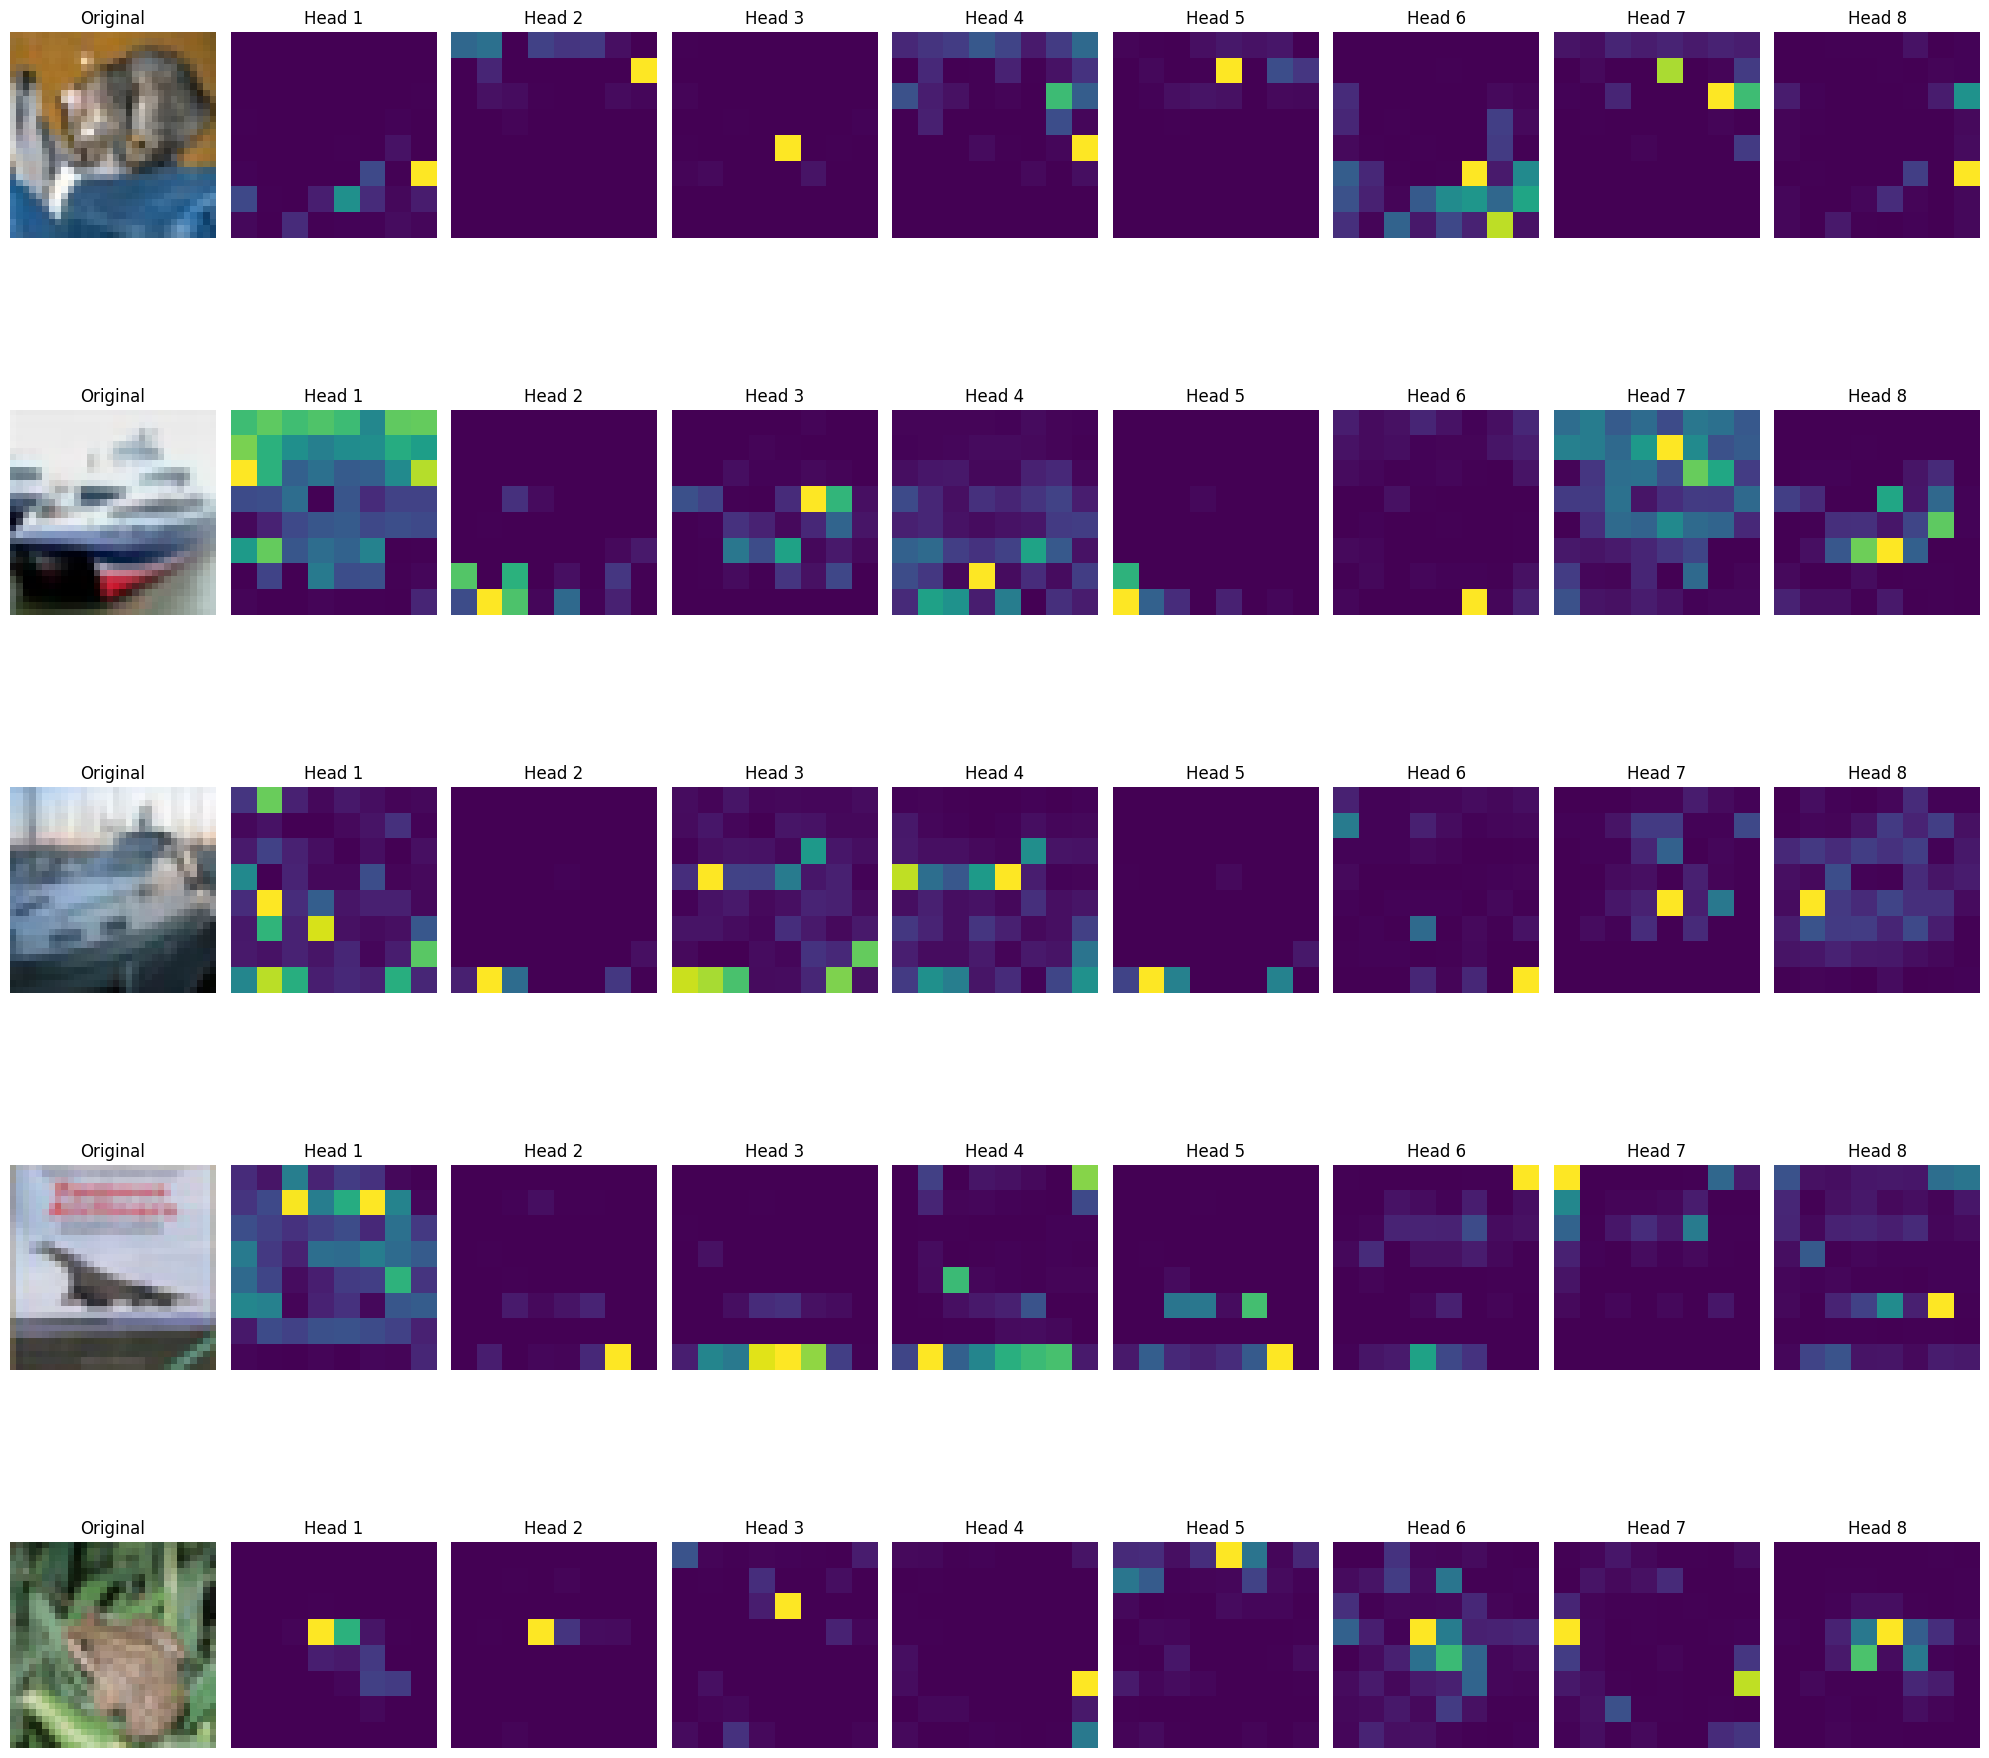

Experiment completed in 21.76 minutes

Running hyperparameter configuration 2
Hidden size: 384, Layers: 9, Heads: 6, MLP size: 1536
Model parameters: 16,018,954
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: hyperparams_config_2


Training: 100%|██████████| 352/352 [01:07<00:00,  5.20it/s, loss=1.81, acc=31.9]


  Validation loss improved. Saving model.
Epoch 1/30: Train Loss: 1.8120, Train Acc: 31.88%, Val Loss: 1.5935, Val Acc: 40.30%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.52, acc=44]  


  Validation loss improved. Saving model.
Epoch 2/30: Train Loss: 1.5194, Train Acc: 43.96%, Val Loss: 1.4027, Val Acc: 47.56%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.38, acc=49.5]


  Validation loss improved. Saving model.
Epoch 3/30: Train Loss: 1.3769, Train Acc: 49.55%, Val Loss: 1.3612, Val Acc: 51.22%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.31, acc=52.2]


  Validation loss improved. Saving model.
Epoch 4/30: Train Loss: 1.3064, Train Acc: 52.15%, Val Loss: 1.3108, Val Acc: 51.76%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.25, acc=54.5]


  Validation loss improved. Saving model.
Epoch 5/30: Train Loss: 1.2499, Train Acc: 54.54%, Val Loss: 1.2903, Val Acc: 54.04%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.21, acc=56]  


  Validation loss improved. Saving model.
Epoch 6/30: Train Loss: 1.2063, Train Acc: 56.01%, Val Loss: 1.2042, Val Acc: 56.62%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.16, acc=57.7]


  No improvement in val loss for 1 epochs.
Epoch 7/30: Train Loss: 1.1646, Train Acc: 57.70%, Val Loss: 1.2079, Val Acc: 56.88%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.14, acc=58.8]


  No improvement in val loss for 2 epochs.
Epoch 8/30: Train Loss: 1.1389, Train Acc: 58.77%, Val Loss: 1.2118, Val Acc: 57.30%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.1, acc=59.9] 


  Validation loss improved. Saving model.
Epoch 9/30: Train Loss: 1.1026, Train Acc: 59.87%, Val Loss: 1.1586, Val Acc: 58.70%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.08, acc=61.1]


  Validation loss improved. Saving model.
Epoch 10/30: Train Loss: 1.0768, Train Acc: 61.14%, Val Loss: 1.1126, Val Acc: 60.96%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.21it/s, loss=1.04, acc=62.2]


  Validation loss improved. Saving model.
Epoch 11/30: Train Loss: 1.0438, Train Acc: 62.24%, Val Loss: 1.1088, Val Acc: 60.24%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=1.02, acc=63]  


  Validation loss improved. Saving model.
Epoch 12/30: Train Loss: 1.0168, Train Acc: 63.04%, Val Loss: 1.0941, Val Acc: 60.90%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.992, acc=64.1]


  No improvement in val loss for 1 epochs.
Epoch 13/30: Train Loss: 0.9918, Train Acc: 64.09%, Val Loss: 1.1544, Val Acc: 59.58%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.963, acc=65.3]


  Validation loss improved. Saving model.
Epoch 14/30: Train Loss: 0.9626, Train Acc: 65.27%, Val Loss: 1.0692, Val Acc: 61.92%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.941, acc=65.7]


  Validation loss improved. Saving model.
Epoch 15/30: Train Loss: 0.9408, Train Acc: 65.73%, Val Loss: 1.0583, Val Acc: 62.80%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.909, acc=67.2]


  No improvement in val loss for 1 epochs.
Epoch 16/30: Train Loss: 0.9092, Train Acc: 67.24%, Val Loss: 1.0602, Val Acc: 62.76%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=0.886, acc=68]  


  Validation loss improved. Saving model.
Epoch 17/30: Train Loss: 0.8857, Train Acc: 68.00%, Val Loss: 1.0569, Val Acc: 62.60%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=0.854, acc=69.1]


  Validation loss improved. Saving model.
Epoch 18/30: Train Loss: 0.8538, Train Acc: 69.06%, Val Loss: 1.0434, Val Acc: 64.08%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.824, acc=70.3]


  No improvement in val loss for 1 epochs.
Epoch 19/30: Train Loss: 0.8238, Train Acc: 70.28%, Val Loss: 1.0471, Val Acc: 64.32%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.798, acc=71.1]


  Validation loss improved. Saving model.
Epoch 20/30: Train Loss: 0.7979, Train Acc: 71.06%, Val Loss: 1.0379, Val Acc: 64.96%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.769, acc=72.2]


  Validation loss improved. Saving model.
Epoch 21/30: Train Loss: 0.7686, Train Acc: 72.24%, Val Loss: 1.0278, Val Acc: 65.20%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=0.743, acc=73.2]


  No improvement in val loss for 1 epochs.
Epoch 22/30: Train Loss: 0.7428, Train Acc: 73.24%, Val Loss: 1.0605, Val Acc: 65.16%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.19it/s, loss=0.717, acc=74]  


  Validation loss improved. Saving model.
Epoch 23/30: Train Loss: 0.7174, Train Acc: 74.04%, Val Loss: 1.0203, Val Acc: 65.48%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.69, acc=75.2] 


  No improvement in val loss for 1 epochs.
Epoch 24/30: Train Loss: 0.6896, Train Acc: 75.22%, Val Loss: 1.0597, Val Acc: 65.60%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.666, acc=76]  


  No improvement in val loss for 2 epochs.
Epoch 25/30: Train Loss: 0.6663, Train Acc: 75.99%, Val Loss: 1.0597, Val Acc: 66.00%


Training: 100%|██████████| 352/352 [01:07<00:00,  5.18it/s, loss=0.649, acc=76.6]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0270, Test Acc: 64.64%


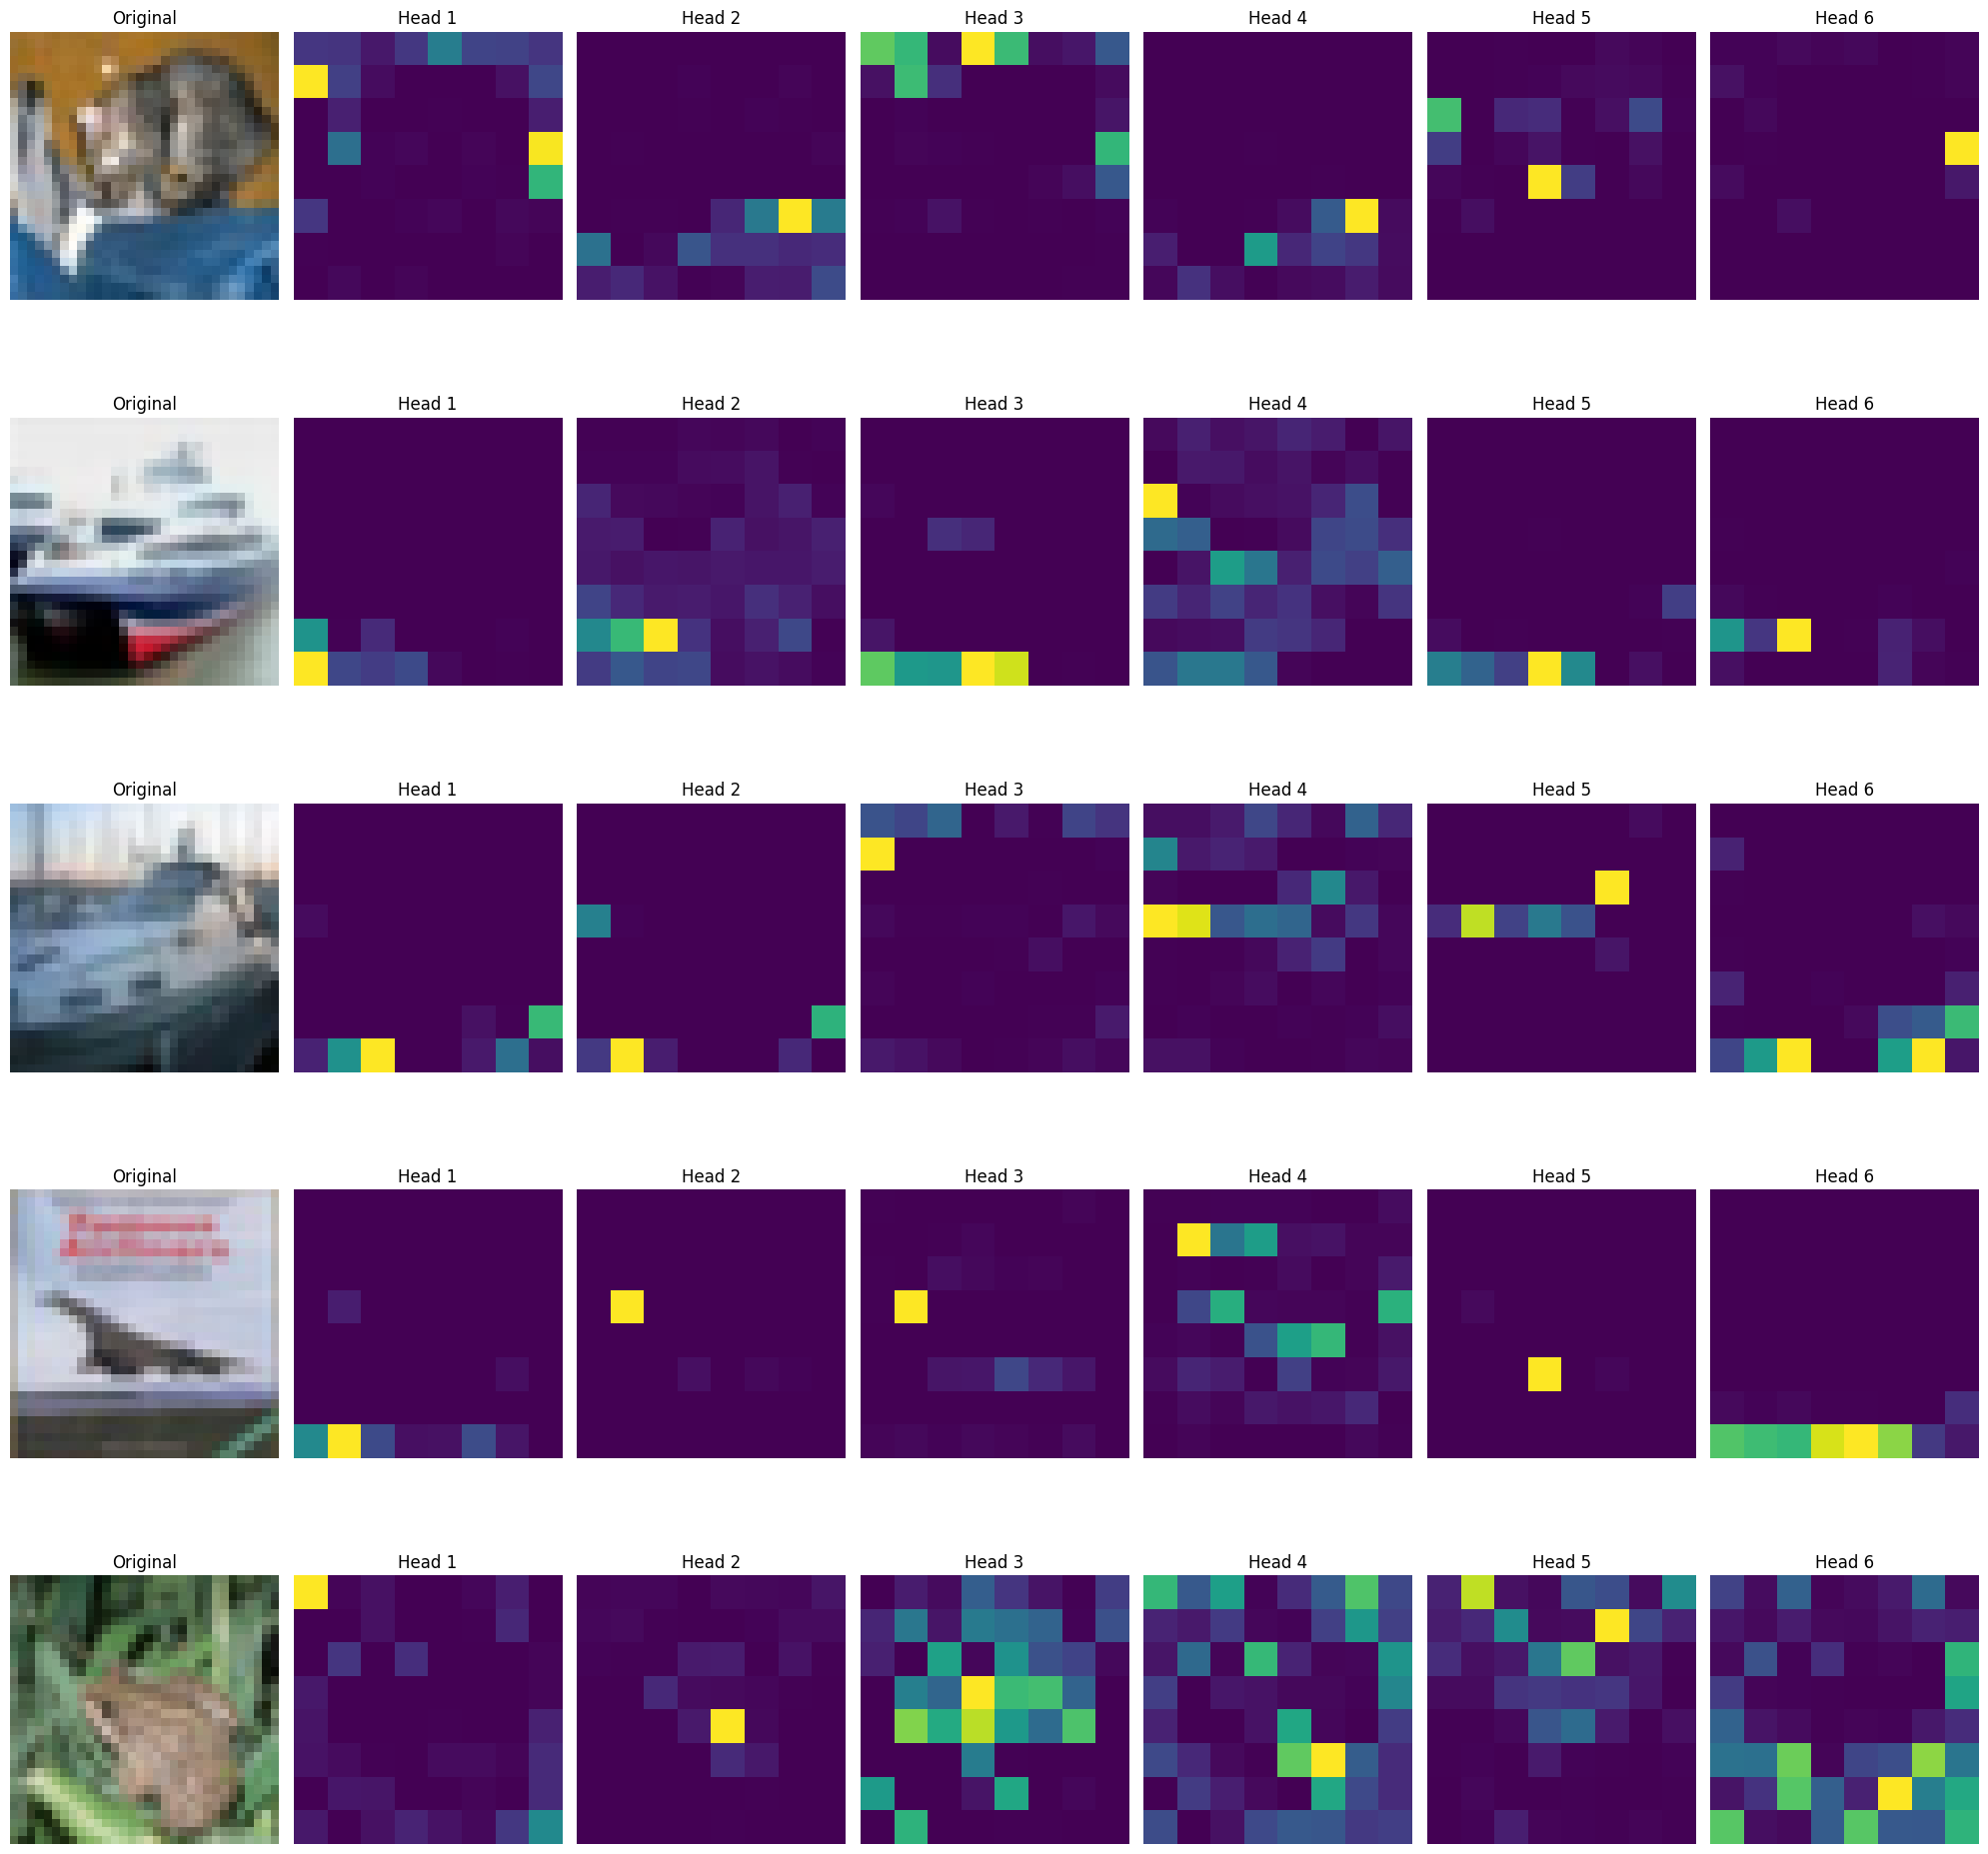

Experiment completed in 30.78 minutes

Running hyperparameter configuration 3
Hidden size: 384, Layers: 7, Heads: 6, MLP size: 768
Model parameters: 8,335,882
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: hyperparams_config_3


Training: 100%|██████████| 352/352 [00:38<00:00,  9.06it/s, loss=1.81, acc=32.5]


  Validation loss improved. Saving model.
Epoch 1/30: Train Loss: 1.8075, Train Acc: 32.47%, Val Loss: 1.6076, Val Acc: 41.10%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.48, acc=45.7]


  Validation loss improved. Saving model.
Epoch 2/30: Train Loss: 1.4778, Train Acc: 45.68%, Val Loss: 1.4444, Val Acc: 47.02%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.34, acc=50.9]


  Validation loss improved. Saving model.
Epoch 3/30: Train Loss: 1.3425, Train Acc: 50.88%, Val Loss: 1.3023, Val Acc: 52.94%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.27, acc=53.7]


  No improvement in val loss for 1 epochs.
Epoch 4/30: Train Loss: 1.2657, Train Acc: 53.67%, Val Loss: 1.3078, Val Acc: 53.38%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.08it/s, loss=1.2, acc=56.8] 


  Validation loss improved. Saving model.
Epoch 5/30: Train Loss: 1.1950, Train Acc: 56.77%, Val Loss: 1.1798, Val Acc: 57.38%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.14, acc=58.5]


  No improvement in val loss for 1 epochs.
Epoch 6/30: Train Loss: 1.1426, Train Acc: 58.46%, Val Loss: 1.2095, Val Acc: 56.32%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.11, acc=60]  


  Validation loss improved. Saving model.
Epoch 7/30: Train Loss: 1.1063, Train Acc: 59.97%, Val Loss: 1.1407, Val Acc: 58.94%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.07, acc=61.3]


  Validation loss improved. Saving model.
Epoch 8/30: Train Loss: 1.0713, Train Acc: 61.30%, Val Loss: 1.1274, Val Acc: 59.78%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1.04, acc=62.5]


  Validation loss improved. Saving model.
Epoch 9/30: Train Loss: 1.0369, Train Acc: 62.50%, Val Loss: 1.1131, Val Acc: 60.44%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=1, acc=64]      


  Validation loss improved. Saving model.
Epoch 10/30: Train Loss: 1.0026, Train Acc: 64.02%, Val Loss: 1.0796, Val Acc: 61.94%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=0.973, acc=65.1]


  No improvement in val loss for 1 epochs.
Epoch 11/30: Train Loss: 0.9735, Train Acc: 65.14%, Val Loss: 1.0920, Val Acc: 61.74%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=0.942, acc=65.9]


  Validation loss improved. Saving model.
Epoch 12/30: Train Loss: 0.9422, Train Acc: 65.87%, Val Loss: 1.0361, Val Acc: 63.76%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=0.898, acc=67.5]


  Validation loss improved. Saving model.
Epoch 13/30: Train Loss: 0.8978, Train Acc: 67.49%, Val Loss: 1.0316, Val Acc: 64.06%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=0.87, acc=68.7] 


  Validation loss improved. Saving model.
Epoch 14/30: Train Loss: 0.8698, Train Acc: 68.74%, Val Loss: 1.0218, Val Acc: 64.64%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=0.83, acc=70.1] 


  No improvement in val loss for 1 epochs.
Epoch 15/30: Train Loss: 0.8305, Train Acc: 70.13%, Val Loss: 1.0376, Val Acc: 65.02%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.07it/s, loss=0.791, acc=71.5]


  No improvement in val loss for 2 epochs.
Epoch 16/30: Train Loss: 0.7915, Train Acc: 71.51%, Val Loss: 1.0412, Val Acc: 64.86%


Training: 100%|██████████| 352/352 [00:38<00:00,  9.06it/s, loss=0.748, acc=73.1]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0420, Test Acc: 63.79%


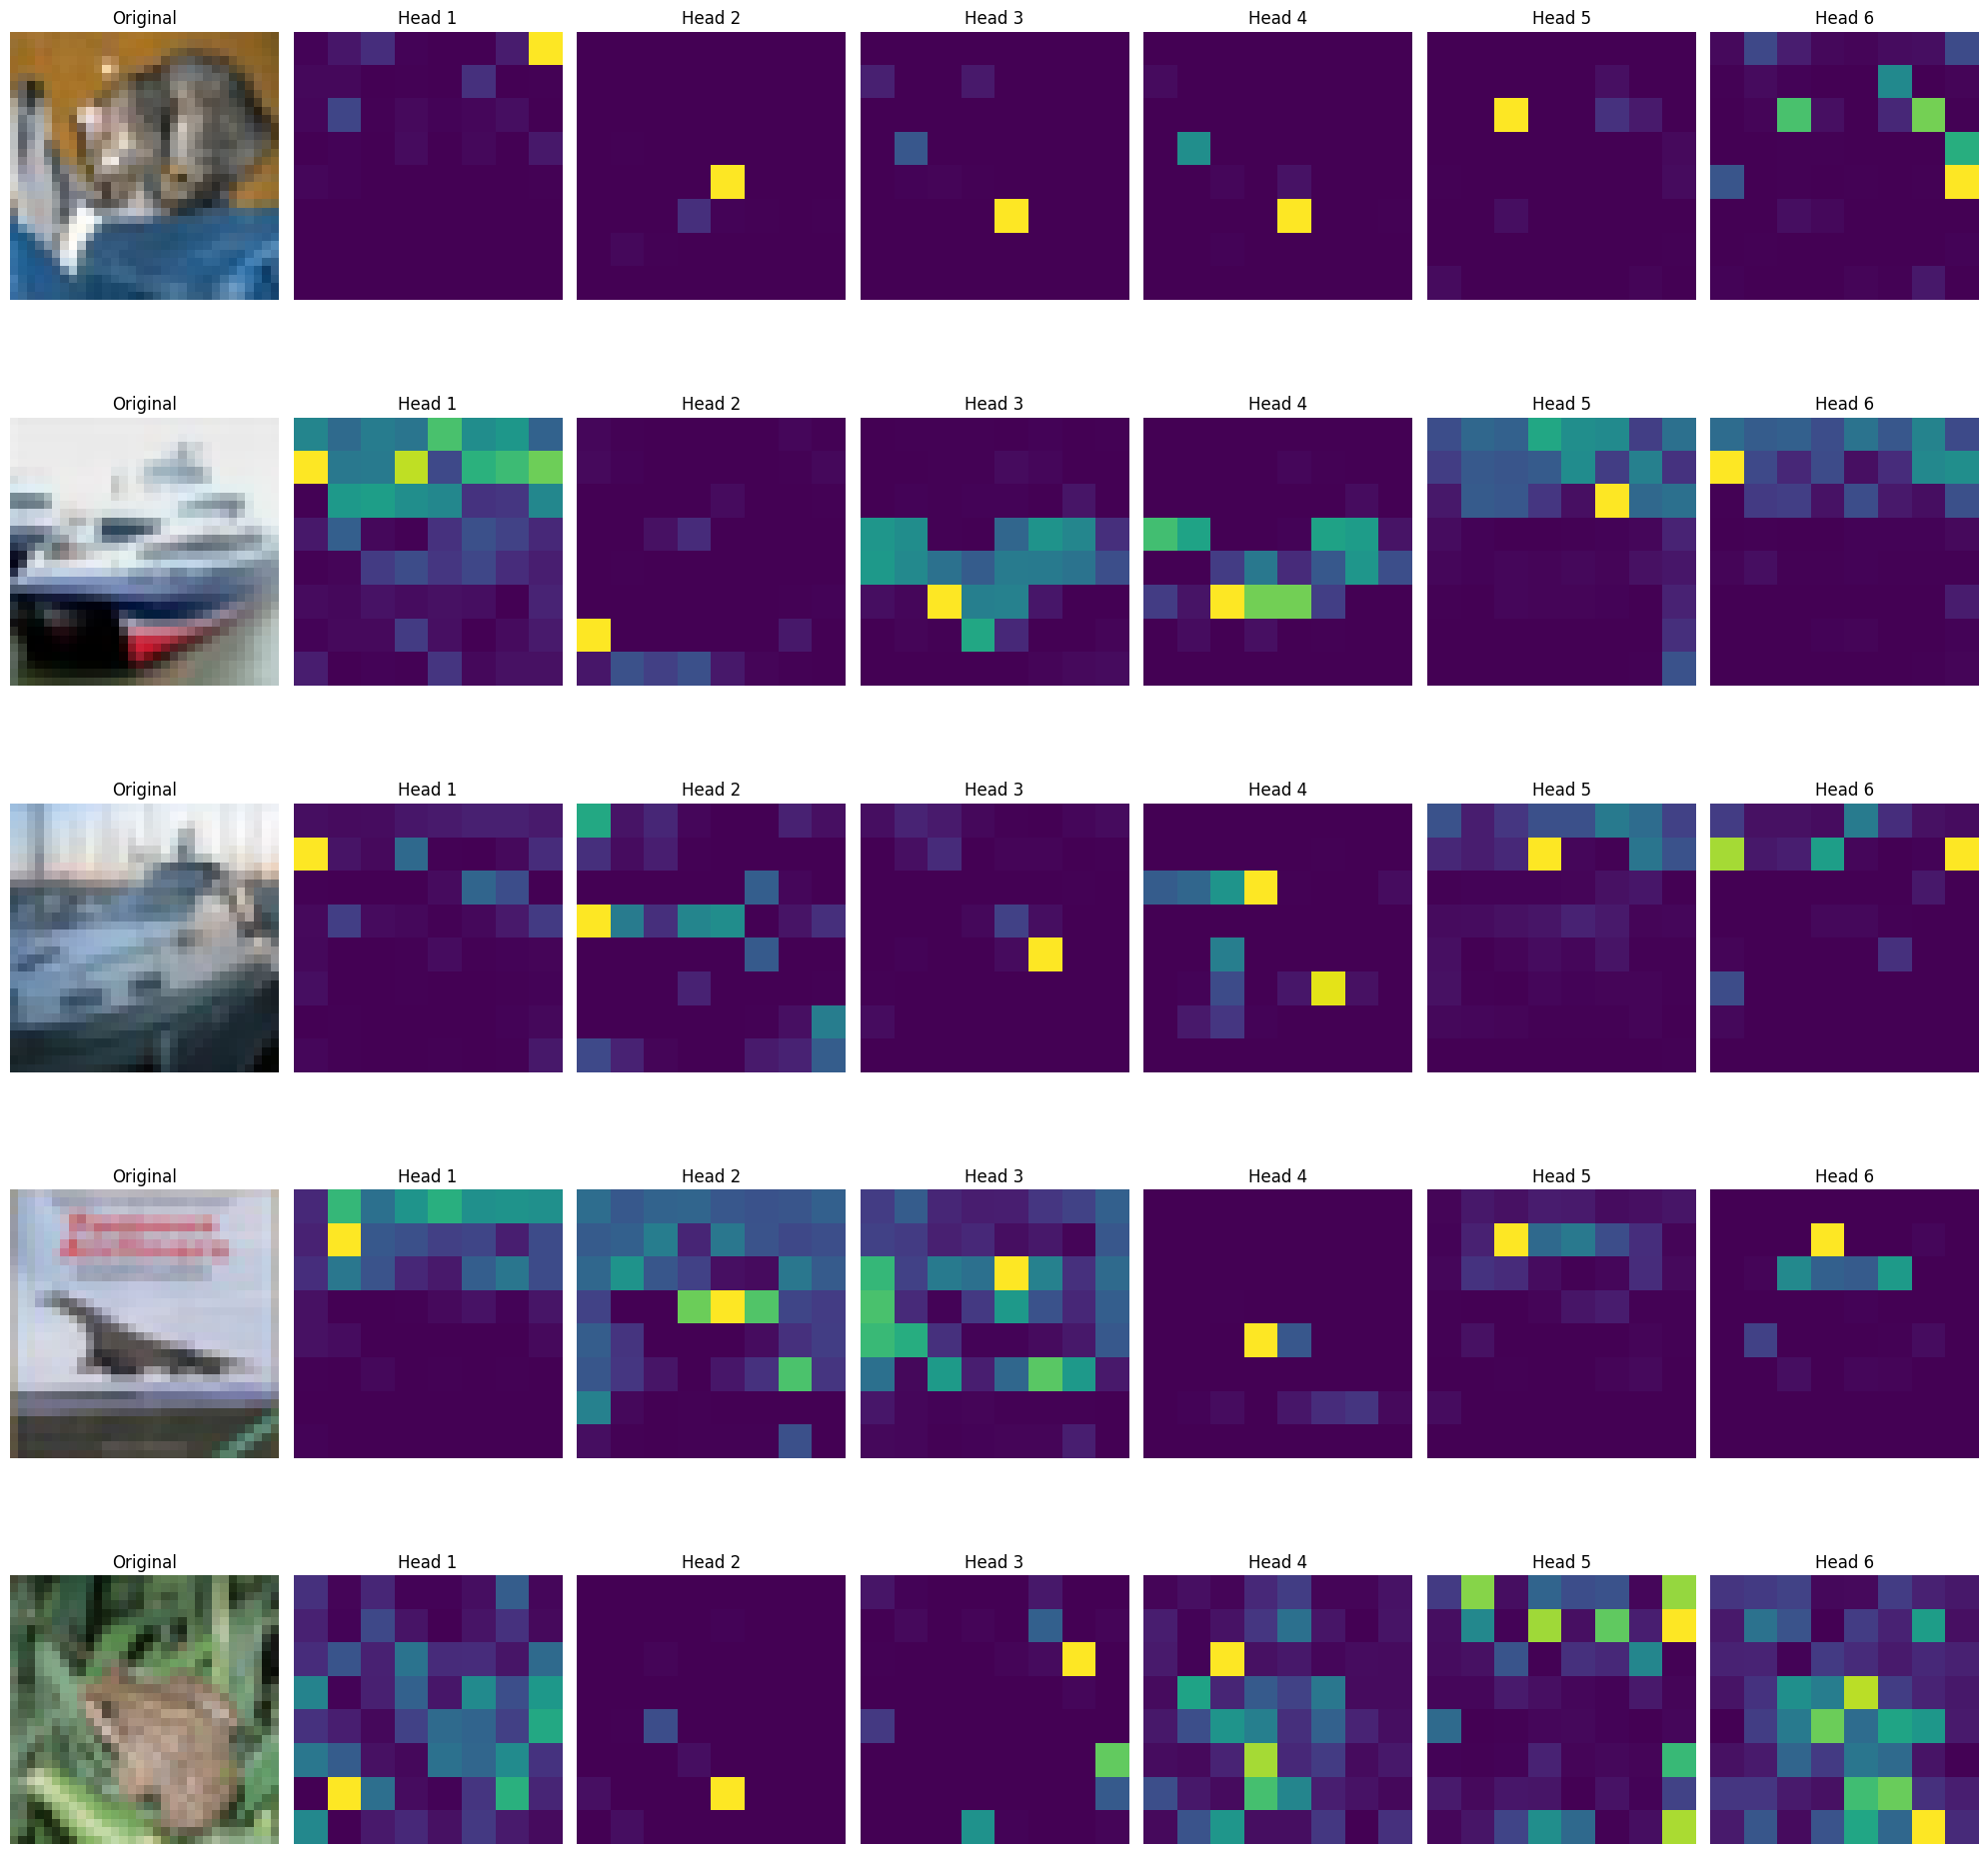

Experiment completed in 11.56 minutes


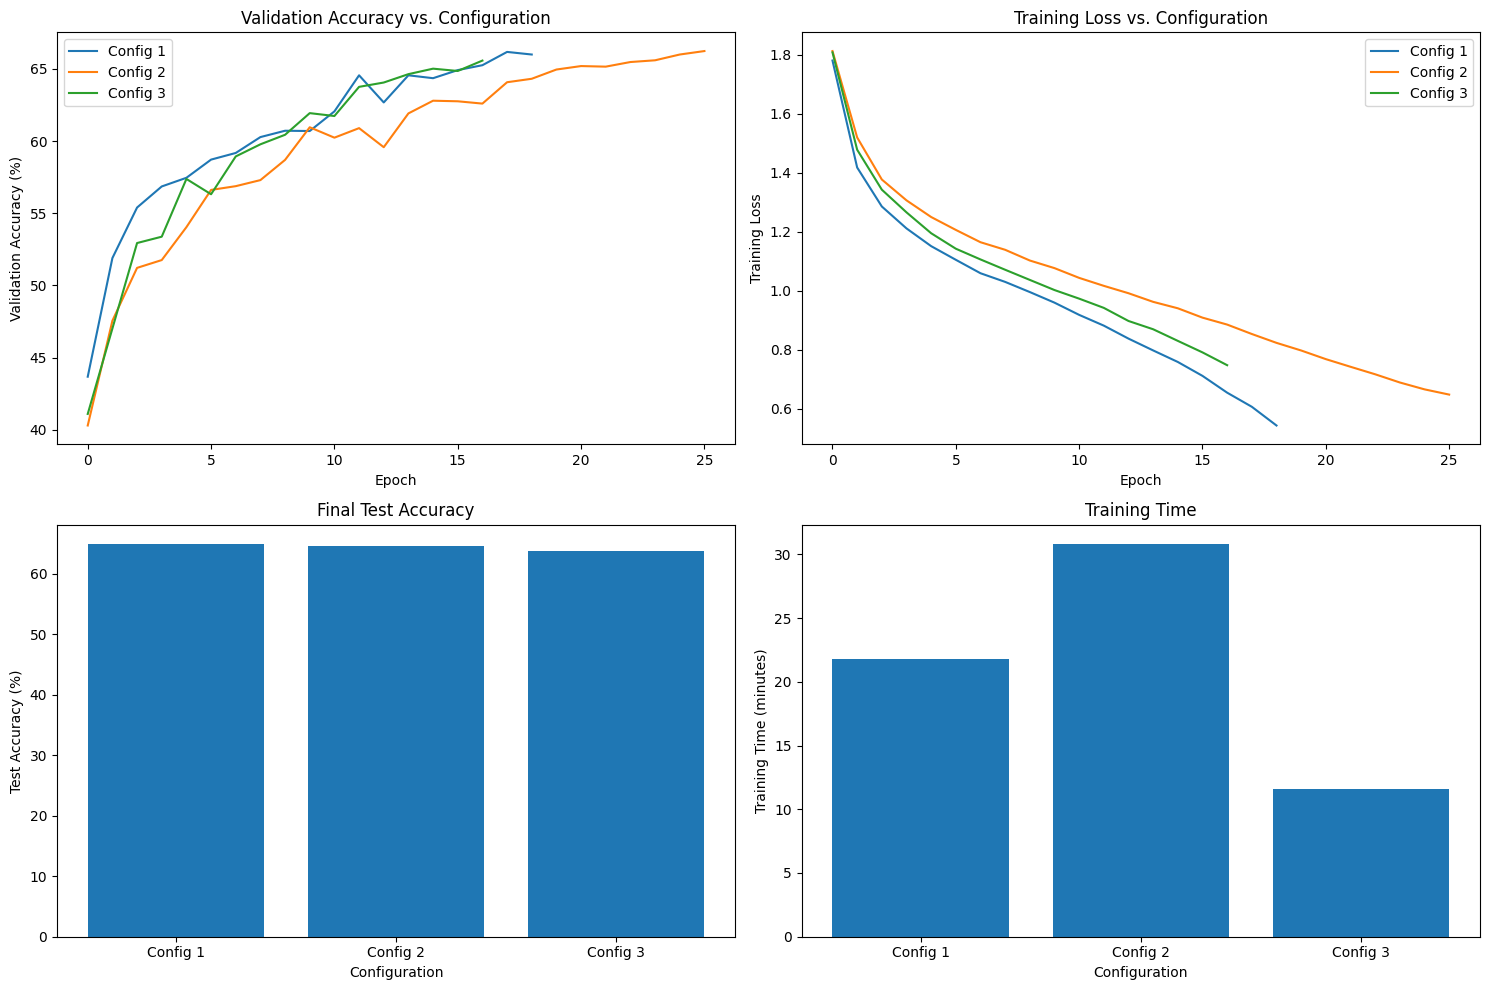


Best hyperparameter configuration (Config 1):
Test accuracy: 64.88%
Hidden size: 512, Layers: 8, Heads: 8, MLP size: 1024


In [ ]:
print("\n" + "="*80)
print("EXPERIMENT 2: HYPERPARAMETER EXPLORATION")
print("="*80)
hyperparams_results, best_config = explore_hyperparameters(epochs=30)

#### Models with more layers, heads, and larger hidden/MLP sizes tend to perform better.However, the accuracy gains are incremental beyond a certain point.There’s a trade-off between performance and computational cost — bigger models do slightly better but require more resources.

## Experiment 3: Data augmentation



EXPERIMENT 3: DATA AUGMENTATION

Running experiment with augmentation level: none
Model parameters: 16,887,306
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: augmentation_none


Training: 100%|██████████| 352/352 [01:05<00:00,  5.36it/s, loss=1.79, acc=33.4]


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.7901, Train Acc: 33.42%, Val Loss: 1.5227, Val Acc: 43.16%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.44, acc=47]  


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.4404, Train Acc: 46.96%, Val Loss: 1.3405, Val Acc: 51.26%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.29, acc=53.2]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.2867, Train Acc: 53.21%, Val Loss: 1.2471, Val Acc: 54.44%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.21, acc=56.4]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.2089, Train Acc: 56.38%, Val Loss: 1.2086, Val Acc: 56.46%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.15, acc=58.5]


  Validation loss improved. Saving model.
Epoch 5/25: Train Loss: 1.1496, Train Acc: 58.53%, Val Loss: 1.1535, Val Acc: 58.76%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.11, acc=59.8]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.1082, Train Acc: 59.85%, Val Loss: 1.1216, Val Acc: 60.06%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.06, acc=61.5]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.0639, Train Acc: 61.48%, Val Loss: 1.1139, Val Acc: 59.72%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.02, acc=62.9]


  Validation loss improved. Saving model.
Epoch 8/25: Train Loss: 1.0242, Train Acc: 62.90%, Val Loss: 1.1000, Val Acc: 60.46%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.983, acc=64.6]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 0.9830, Train Acc: 64.63%, Val Loss: 1.0633, Val Acc: 62.40%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.945, acc=65.9]


  No improvement in val loss for 1 epochs.
Epoch 10/25: Train Loss: 0.9452, Train Acc: 65.91%, Val Loss: 1.0677, Val Acc: 62.22%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.901, acc=67.3]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 0.9012, Train Acc: 67.31%, Val Loss: 1.0131, Val Acc: 64.18%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.862, acc=68.9]


  No improvement in val loss for 1 epochs.
Epoch 12/25: Train Loss: 0.8620, Train Acc: 68.92%, Val Loss: 1.0304, Val Acc: 63.30%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.813, acc=70.5]


  No improvement in val loss for 2 epochs.
Epoch 13/25: Train Loss: 0.8129, Train Acc: 70.47%, Val Loss: 1.0151, Val Acc: 64.56%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.767, acc=72.1]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.


/tmp/ipykernel_31/4049654737.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{exp_name}_best.pth'))


Test Loss: 1.0296, Test Acc: 63.58%


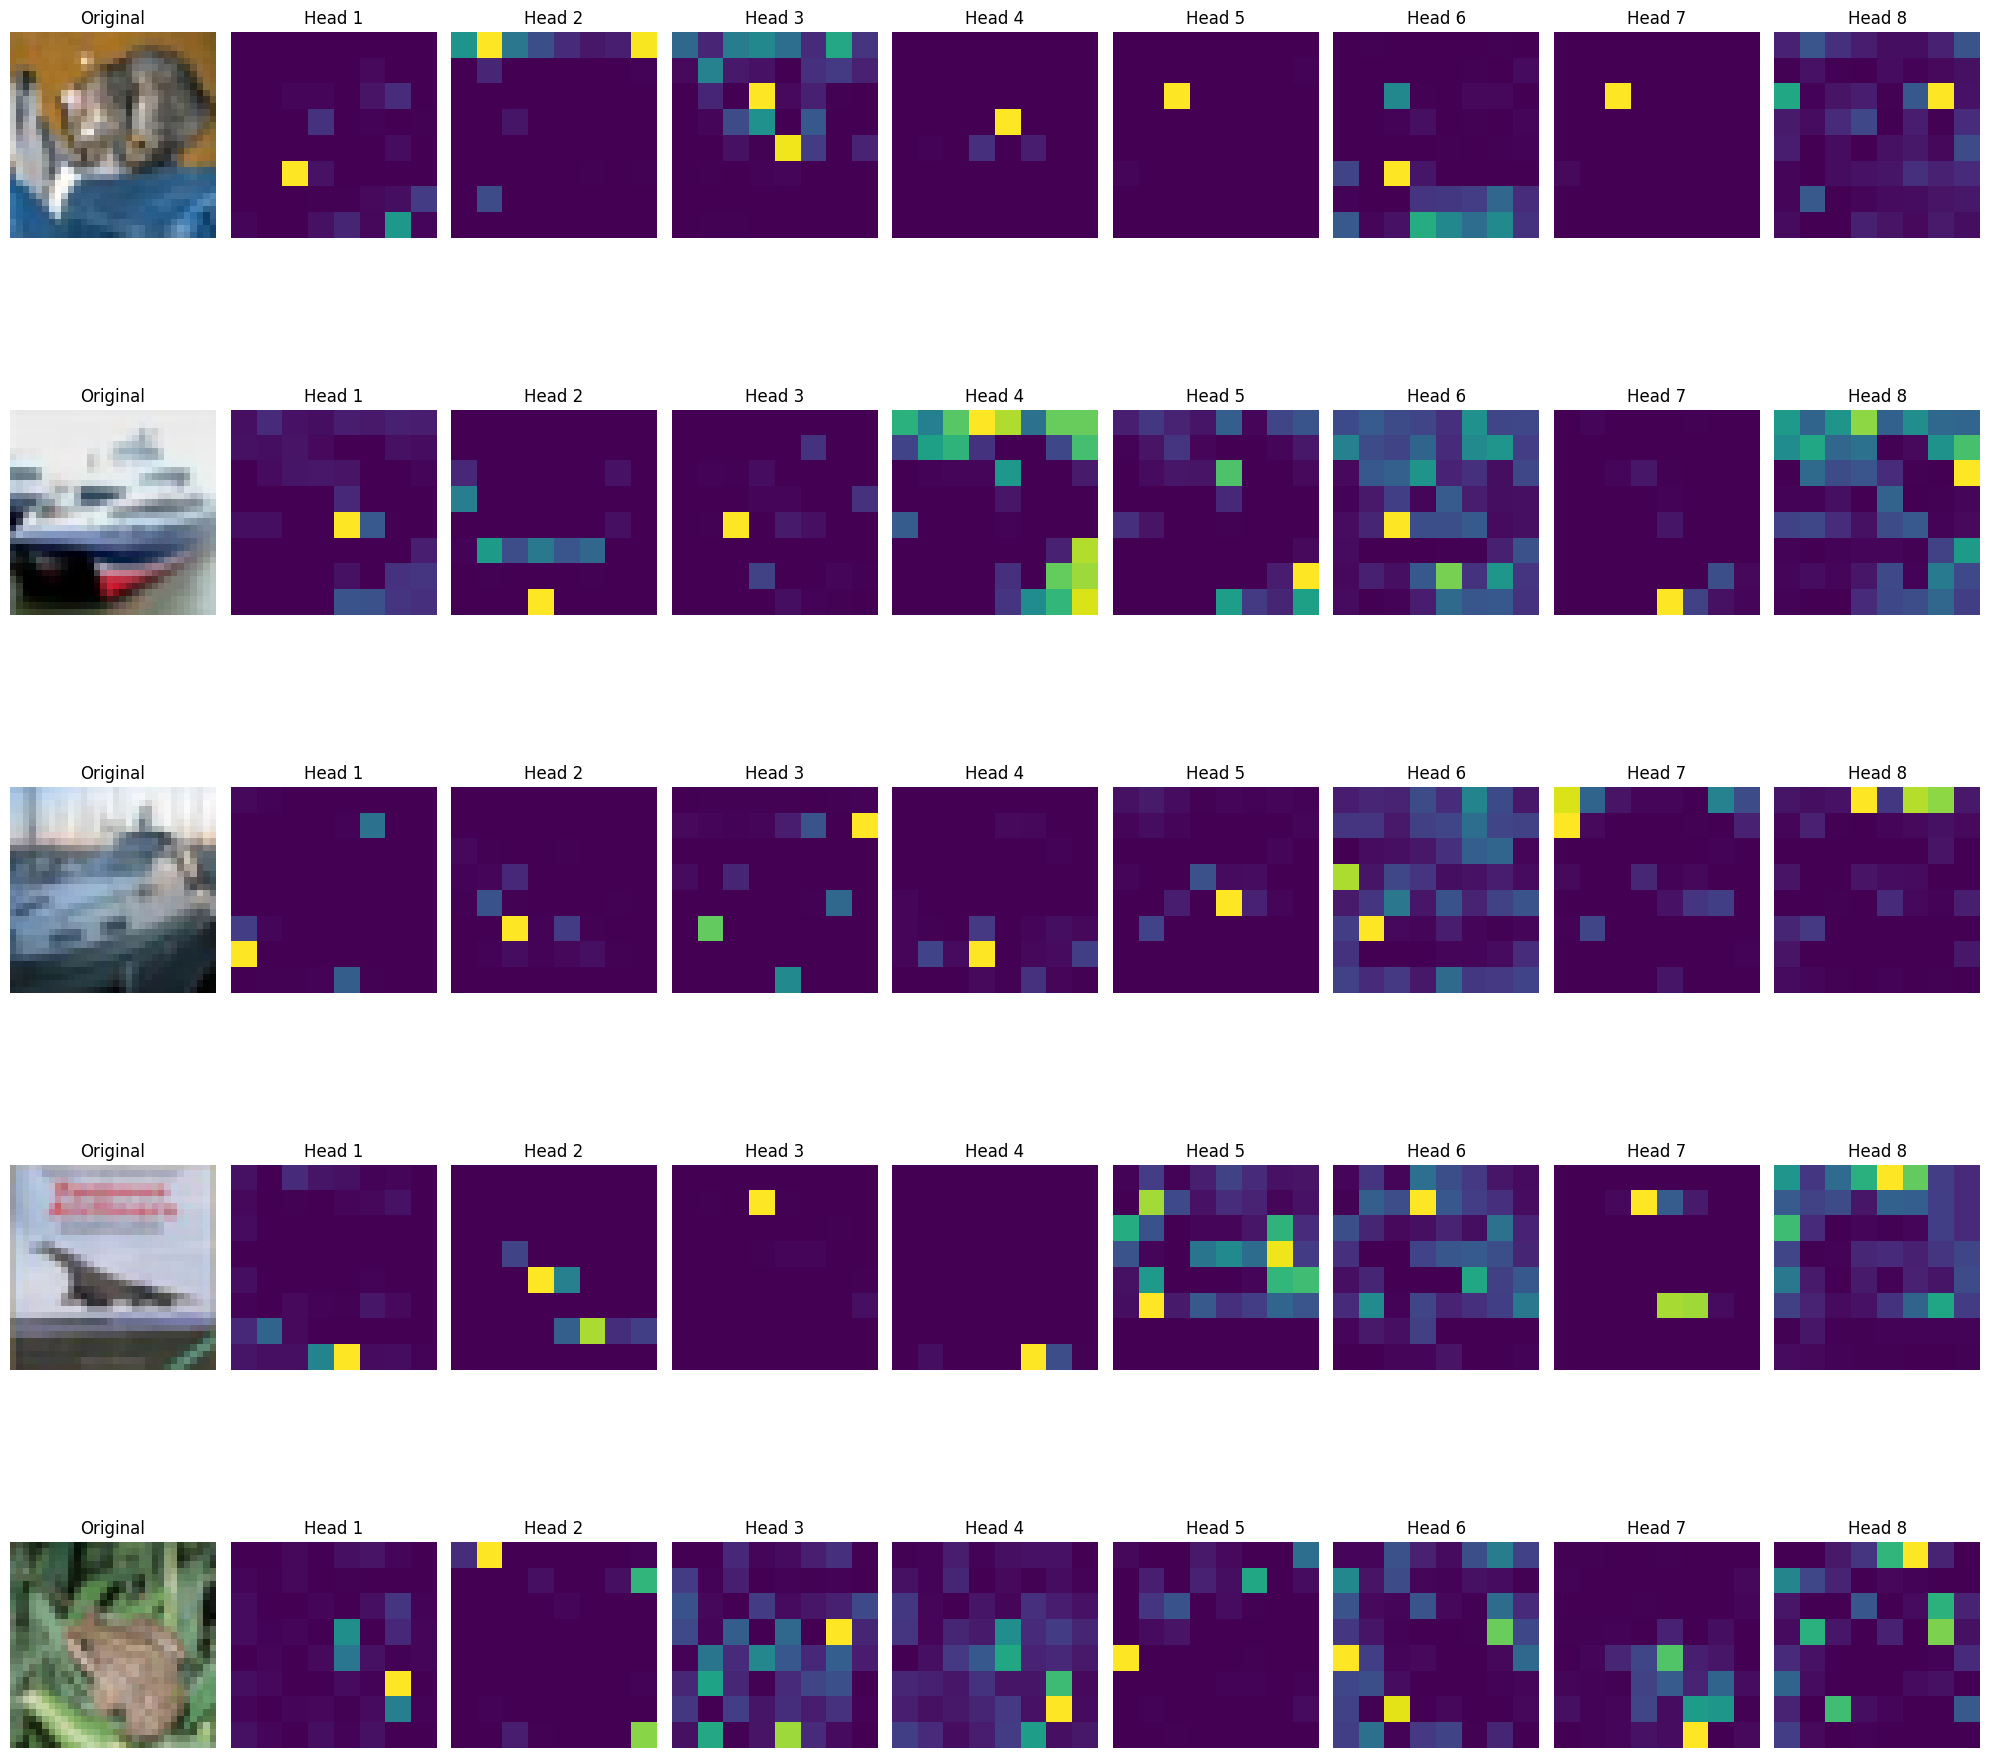

Experiment completed in 16.14 minutes

Running experiment with augmentation level: basic
Model parameters: 16,887,306
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: augmentation_basic


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.8, acc=32.9] 


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.8027, Train Acc: 32.92%, Val Loss: 1.5575, Val Acc: 41.62%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.45, acc=47.1]


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.4485, Train Acc: 47.10%, Val Loss: 1.3711, Val Acc: 49.96%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.31, acc=52.7]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.3053, Train Acc: 52.66%, Val Loss: 1.2575, Val Acc: 53.70%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.24, acc=55.1]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.2363, Train Acc: 55.06%, Val Loss: 1.2159, Val Acc: 55.46%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.17, acc=57.8]


  Validation loss improved. Saving model.
Epoch 5/25: Train Loss: 1.1709, Train Acc: 57.75%, Val Loss: 1.1578, Val Acc: 58.32%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.12, acc=59.3]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.1234, Train Acc: 59.33%, Val Loss: 1.1012, Val Acc: 60.16%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.09, acc=60.3]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.0945, Train Acc: 60.30%, Val Loss: 1.0549, Val Acc: 62.20%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.06, acc=61.5]


  No improvement in val loss for 1 epochs.
Epoch 8/25: Train Loss: 1.0568, Train Acc: 61.53%, Val Loss: 1.0831, Val Acc: 61.36%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.03, acc=62.7]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 1.0269, Train Acc: 62.72%, Val Loss: 1.0385, Val Acc: 62.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.992, acc=64.5]


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 0.9917, Train Acc: 64.46%, Val Loss: 1.0194, Val Acc: 63.56%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.956, acc=65.7]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 0.9564, Train Acc: 65.71%, Val Loss: 0.9924, Val Acc: 64.64%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.919, acc=66.7]


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 0.9192, Train Acc: 66.66%, Val Loss: 0.9920, Val Acc: 65.18%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.887, acc=68.1]


  Validation loss improved. Saving model.
Epoch 13/25: Train Loss: 0.8865, Train Acc: 68.12%, Val Loss: 0.9623, Val Acc: 66.32%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.857, acc=69.1]


  Validation loss improved. Saving model.
Epoch 14/25: Train Loss: 0.8567, Train Acc: 69.09%, Val Loss: 0.9455, Val Acc: 66.38%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.813, acc=70.7]


  No improvement in val loss for 1 epochs.
Epoch 15/25: Train Loss: 0.8126, Train Acc: 70.69%, Val Loss: 0.9587, Val Acc: 67.10%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.776, acc=72.2]


  Validation loss improved. Saving model.
Epoch 16/25: Train Loss: 0.7759, Train Acc: 72.16%, Val Loss: 0.9186, Val Acc: 67.72%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.739, acc=73.5]


  No improvement in val loss for 1 epochs.
Epoch 17/25: Train Loss: 0.7388, Train Acc: 73.55%, Val Loss: 0.9230, Val Acc: 68.62%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.702, acc=74.8]


  Validation loss improved. Saving model.
Epoch 18/25: Train Loss: 0.7015, Train Acc: 74.76%, Val Loss: 0.9116, Val Acc: 68.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.662, acc=76.1]


  Validation loss improved. Saving model.
Epoch 19/25: Train Loss: 0.6616, Train Acc: 76.13%, Val Loss: 0.9092, Val Acc: 69.50%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.622, acc=77.7]


  No improvement in val loss for 1 epochs.
Epoch 20/25: Train Loss: 0.6218, Train Acc: 77.67%, Val Loss: 0.9202, Val Acc: 69.08%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.592, acc=78.9]


  No improvement in val loss for 2 epochs.
Epoch 21/25: Train Loss: 0.5922, Train Acc: 78.86%, Val Loss: 0.9094, Val Acc: 69.78%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.565, acc=79.8]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 0.9403, Test Acc: 67.76%


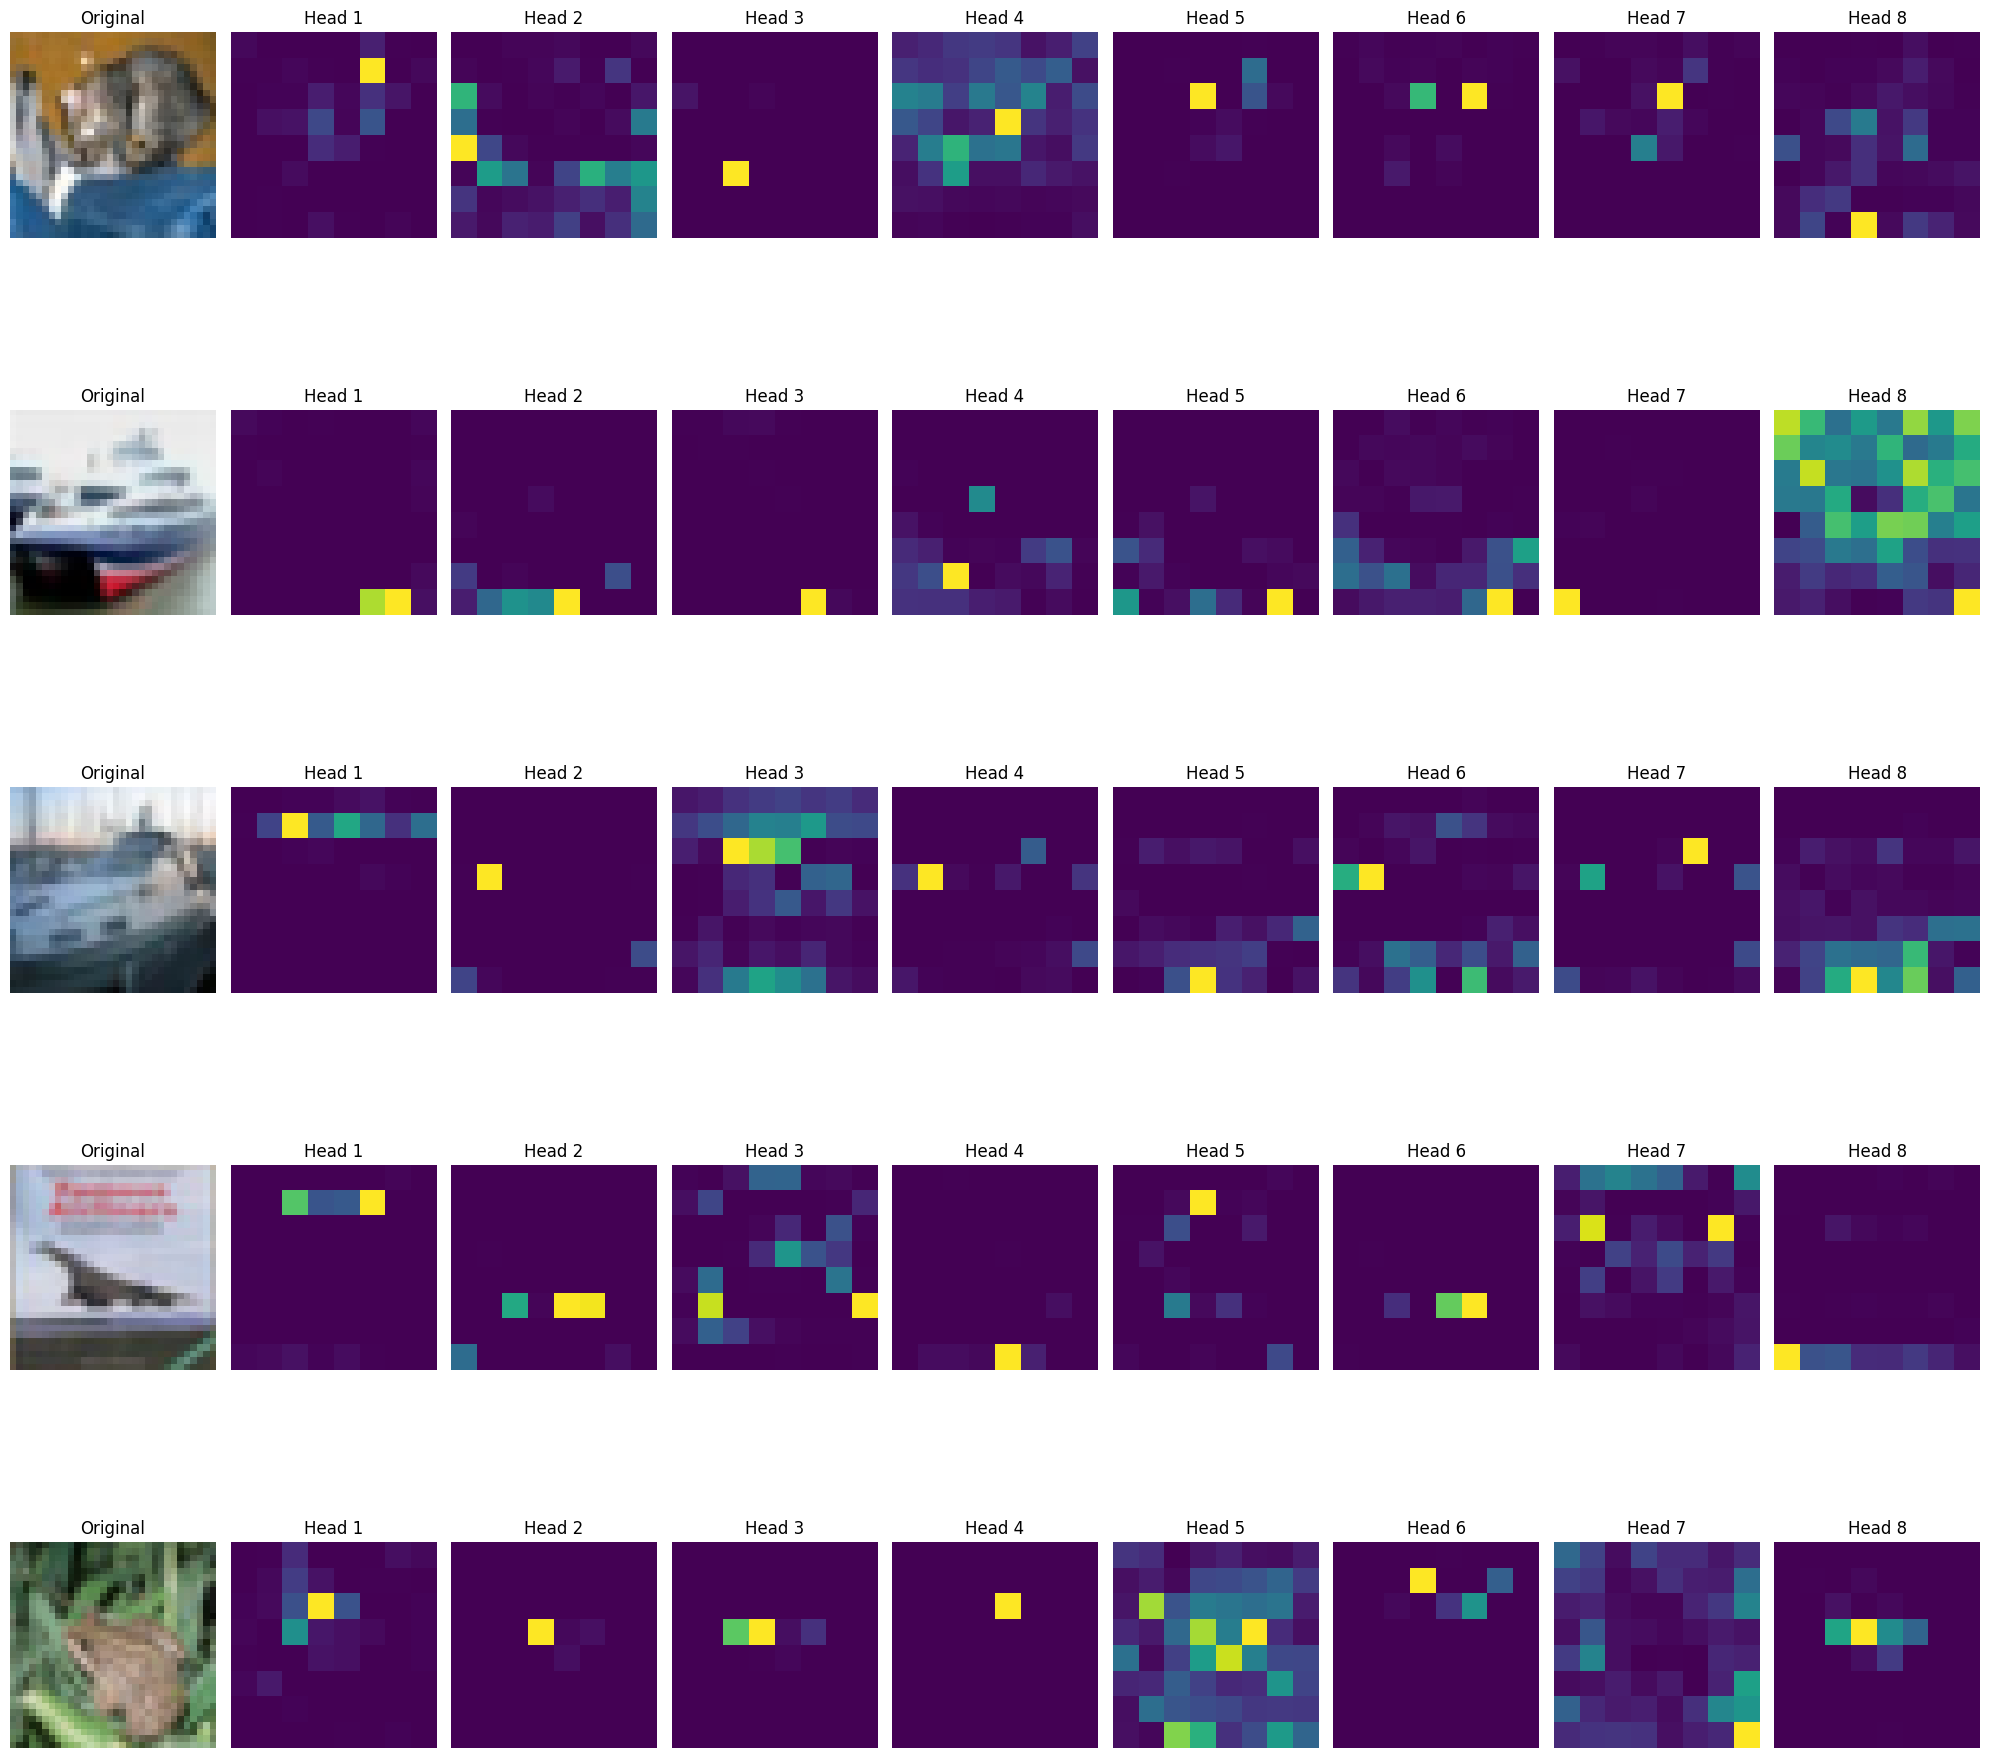

Experiment completed in 25.28 minutes

Running experiment with augmentation level: medium
Model parameters: 16,887,306
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: augmentation_medium


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.9, acc=29.1] 


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.8978, Train Acc: 29.05%, Val Loss: 1.6990, Val Acc: 37.06%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.58, acc=41.6]


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.5795, Train Acc: 41.61%, Val Loss: 1.4585, Val Acc: 47.14%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.43, acc=47.6]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.4322, Train Acc: 47.59%, Val Loss: 1.4185, Val Acc: 48.32%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.37, acc=49.8]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.3694, Train Acc: 49.81%, Val Loss: 1.3241, Val Acc: 51.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.32, acc=52.1]


  No improvement in val loss for 1 epochs.
Epoch 5/25: Train Loss: 1.3192, Train Acc: 52.15%, Val Loss: 1.3285, Val Acc: 51.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.28, acc=53.4]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.2793, Train Acc: 53.36%, Val Loss: 1.2480, Val Acc: 55.38%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.25, acc=54.8]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.2458, Train Acc: 54.82%, Val Loss: 1.2445, Val Acc: 55.82%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.21, acc=56.2]


  No improvement in val loss for 1 epochs.
Epoch 8/25: Train Loss: 1.2129, Train Acc: 56.22%, Val Loss: 1.2559, Val Acc: 54.94%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.18, acc=57.6]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 1.1785, Train Acc: 57.60%, Val Loss: 1.1552, Val Acc: 58.14%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.14, acc=58.6]


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 1.1443, Train Acc: 58.63%, Val Loss: 1.1487, Val Acc: 58.82%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.12, acc=59.6]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 1.1183, Train Acc: 59.64%, Val Loss: 1.1218, Val Acc: 60.46%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.08, acc=61]  


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 1.0842, Train Acc: 61.01%, Val Loss: 1.0957, Val Acc: 61.12%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.06, acc=61.5]


  Validation loss improved. Saving model.
Epoch 13/25: Train Loss: 1.0610, Train Acc: 61.54%, Val Loss: 1.0578, Val Acc: 62.22%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.03, acc=62.9]


  No improvement in val loss for 1 epochs.
Epoch 14/25: Train Loss: 1.0310, Train Acc: 62.94%, Val Loss: 1.0808, Val Acc: 62.40%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.998, acc=64.2]


  Validation loss improved. Saving model.
Epoch 15/25: Train Loss: 0.9979, Train Acc: 64.22%, Val Loss: 1.0473, Val Acc: 62.90%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.968, acc=65.1]


  Validation loss improved. Saving model.
Epoch 16/25: Train Loss: 0.9676, Train Acc: 65.05%, Val Loss: 1.0105, Val Acc: 64.42%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.947, acc=66]  


  Validation loss improved. Saving model.
Epoch 17/25: Train Loss: 0.9467, Train Acc: 66.04%, Val Loss: 1.0006, Val Acc: 64.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.918, acc=67.1]


  Validation loss improved. Saving model.
Epoch 18/25: Train Loss: 0.9180, Train Acc: 67.08%, Val Loss: 0.9625, Val Acc: 66.20%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.892, acc=67.9]


  Validation loss improved. Saving model.
Epoch 19/25: Train Loss: 0.8924, Train Acc: 67.91%, Val Loss: 0.9541, Val Acc: 65.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.864, acc=69.1]


  No improvement in val loss for 1 epochs.
Epoch 20/25: Train Loss: 0.8637, Train Acc: 69.05%, Val Loss: 0.9631, Val Acc: 66.62%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.849, acc=69.3]


  Validation loss improved. Saving model.
Epoch 21/25: Train Loss: 0.8491, Train Acc: 69.30%, Val Loss: 0.9518, Val Acc: 66.92%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.842, acc=69.7]


  Validation loss improved. Saving model.
Epoch 22/25: Train Loss: 0.8418, Train Acc: 69.74%, Val Loss: 0.9186, Val Acc: 68.08%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.824, acc=70.4]


  No improvement in val loss for 1 epochs.
Epoch 23/25: Train Loss: 0.8239, Train Acc: 70.37%, Val Loss: 0.9213, Val Acc: 68.08%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=0.817, acc=70.5]


  No improvement in val loss for 2 epochs.
Epoch 24/25: Train Loss: 0.8168, Train Acc: 70.48%, Val Loss: 0.9208, Val Acc: 67.90%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.813, acc=70.7]


  Validation loss improved. Saving model.
Epoch 25/25: Train Loss: 0.8134, Train Acc: 70.73%, Val Loss: 0.9137, Val Acc: 68.42%
Test Loss: 0.8743, Test Acc: 68.86%


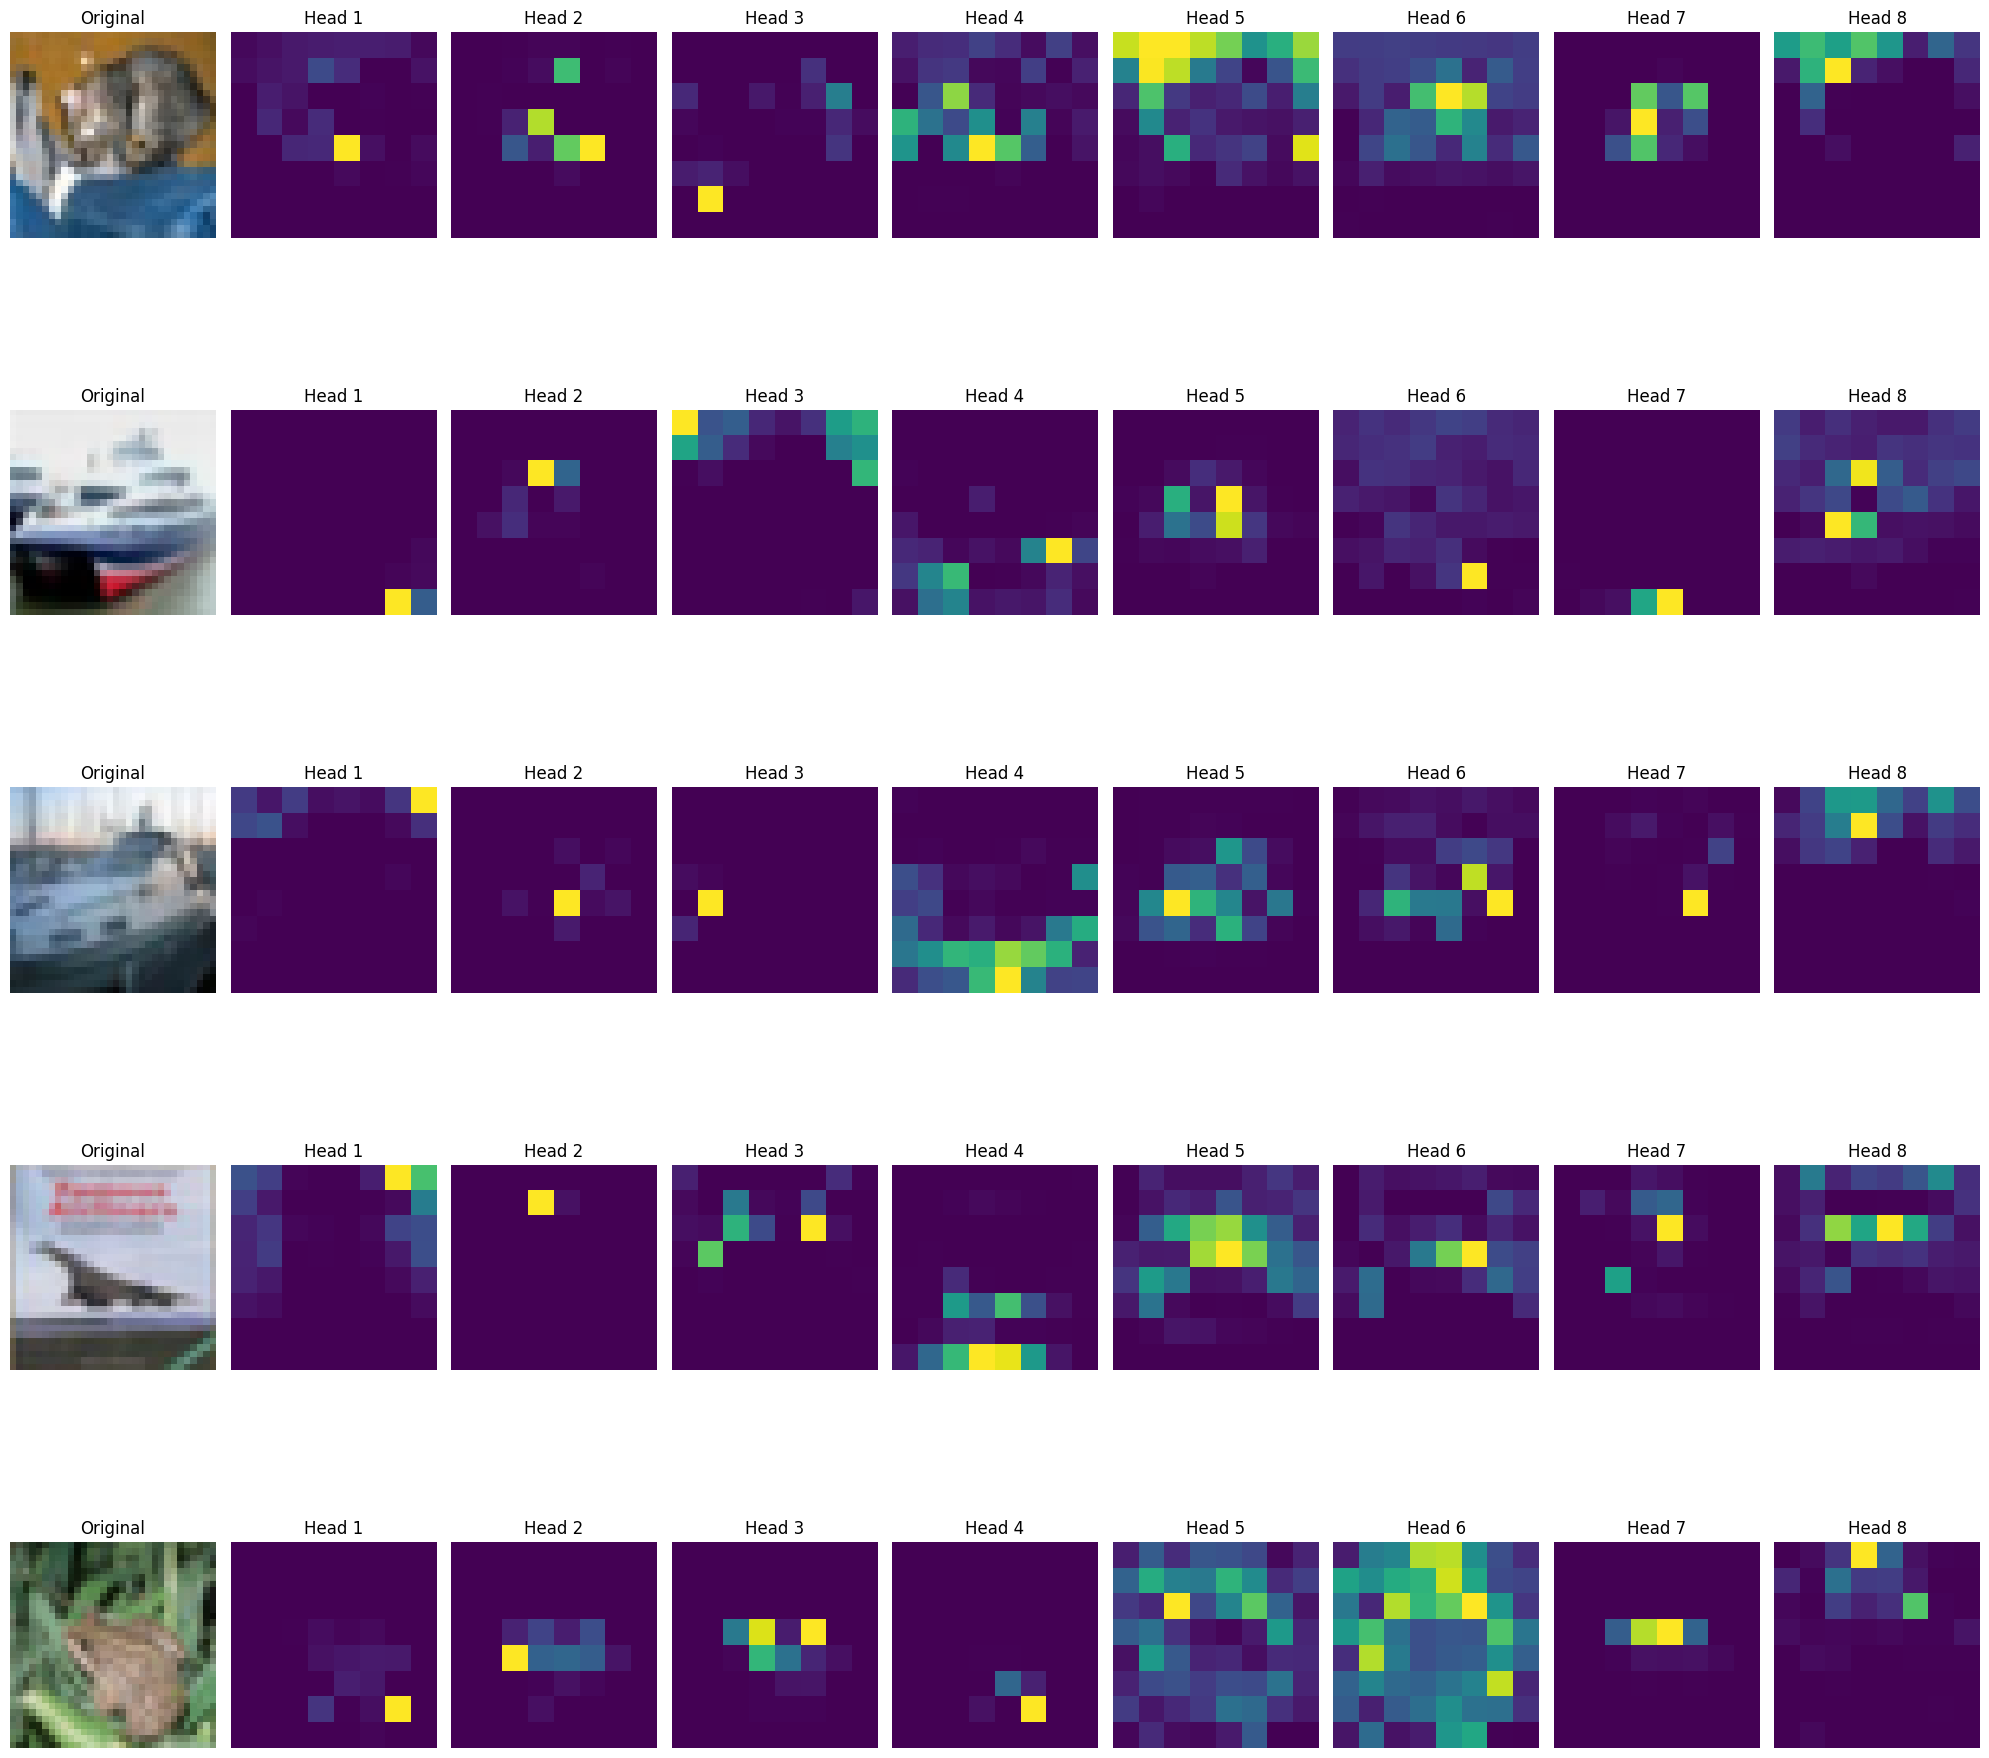

Experiment completed in 28.73 minutes

Running experiment with augmentation level: strong
Model parameters: 16,887,306
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: augmentation_strong


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.89, acc=28.9]


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.8911, Train Acc: 28.88%, Val Loss: 1.7159, Val Acc: 36.58%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.62, acc=39.9]


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.6243, Train Acc: 39.90%, Val Loss: 1.5503, Val Acc: 43.10%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.49, acc=45.5]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.4887, Train Acc: 45.53%, Val Loss: 1.4186, Val Acc: 48.74%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.42, acc=48.3]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.4226, Train Acc: 48.32%, Val Loss: 1.4140, Val Acc: 48.40%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.38, acc=49.6]


  Validation loss improved. Saving model.
Epoch 5/25: Train Loss: 1.3784, Train Acc: 49.58%, Val Loss: 1.3593, Val Acc: 50.86%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.33, acc=51.6]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.3317, Train Acc: 51.57%, Val Loss: 1.2963, Val Acc: 52.88%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.3, acc=52.9] 


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.2967, Train Acc: 52.89%, Val Loss: 1.2933, Val Acc: 52.90%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.26, acc=54.6]


  Validation loss improved. Saving model.
Epoch 8/25: Train Loss: 1.2573, Train Acc: 54.61%, Val Loss: 1.2653, Val Acc: 54.32%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.23, acc=55.6]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 1.2323, Train Acc: 55.56%, Val Loss: 1.1981, Val Acc: 56.96%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.2, acc=56.6] 


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 1.2010, Train Acc: 56.56%, Val Loss: 1.1838, Val Acc: 56.86%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.17, acc=57.6]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 1.1725, Train Acc: 57.56%, Val Loss: 1.1564, Val Acc: 57.16%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.14, acc=58.8]


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 1.1447, Train Acc: 58.83%, Val Loss: 1.1277, Val Acc: 59.74%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.12, acc=59.6]


  Validation loss improved. Saving model.
Epoch 13/25: Train Loss: 1.1245, Train Acc: 59.58%, Val Loss: 1.1122, Val Acc: 60.42%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.1, acc=60.3] 


  Validation loss improved. Saving model.
Epoch 14/25: Train Loss: 1.0950, Train Acc: 60.33%, Val Loss: 1.0709, Val Acc: 61.66%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=1.06, acc=61.4]


  No improvement in val loss for 1 epochs.
Epoch 15/25: Train Loss: 1.0639, Train Acc: 61.38%, Val Loss: 1.0824, Val Acc: 61.76%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.04, acc=62.4]


  Validation loss improved. Saving model.
Epoch 16/25: Train Loss: 1.0431, Train Acc: 62.36%, Val Loss: 1.0393, Val Acc: 62.84%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=1.01, acc=63.5]


  Validation loss improved. Saving model.
Epoch 17/25: Train Loss: 1.0120, Train Acc: 63.49%, Val Loss: 1.0222, Val Acc: 63.48%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=0.996, acc=64.3]


  Validation loss improved. Saving model.
Epoch 18/25: Train Loss: 0.9958, Train Acc: 64.29%, Val Loss: 1.0056, Val Acc: 63.44%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=0.967, acc=65.1]


  Validation loss improved. Saving model.
Epoch 19/25: Train Loss: 0.9667, Train Acc: 65.10%, Val Loss: 0.9891, Val Acc: 64.22%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=0.947, acc=66]  


  Validation loss improved. Saving model.
Epoch 20/25: Train Loss: 0.9472, Train Acc: 66.03%, Val Loss: 0.9697, Val Acc: 65.52%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.928, acc=66.7]


  Validation loss improved. Saving model.
Epoch 21/25: Train Loss: 0.9283, Train Acc: 66.65%, Val Loss: 0.9683, Val Acc: 64.86%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=0.914, acc=67.3]


  Validation loss improved. Saving model.
Epoch 22/25: Train Loss: 0.9142, Train Acc: 67.28%, Val Loss: 0.9599, Val Acc: 65.82%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.902, acc=67.5]


  Validation loss improved. Saving model.
Epoch 23/25: Train Loss: 0.9020, Train Acc: 67.54%, Val Loss: 0.9573, Val Acc: 65.58%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s, loss=0.895, acc=67.7]


  Validation loss improved. Saving model.
Epoch 24/25: Train Loss: 0.8951, Train Acc: 67.69%, Val Loss: 0.9430, Val Acc: 66.12%


Training: 100%|██████████| 352/352 [01:05<00:00,  5.35it/s, loss=0.891, acc=68.1]


  No improvement in val loss for 1 epochs.
Epoch 25/25: Train Loss: 0.8907, Train Acc: 68.13%, Val Loss: 0.9619, Val Acc: 65.90%
Test Loss: 0.8610, Test Acc: 69.07%


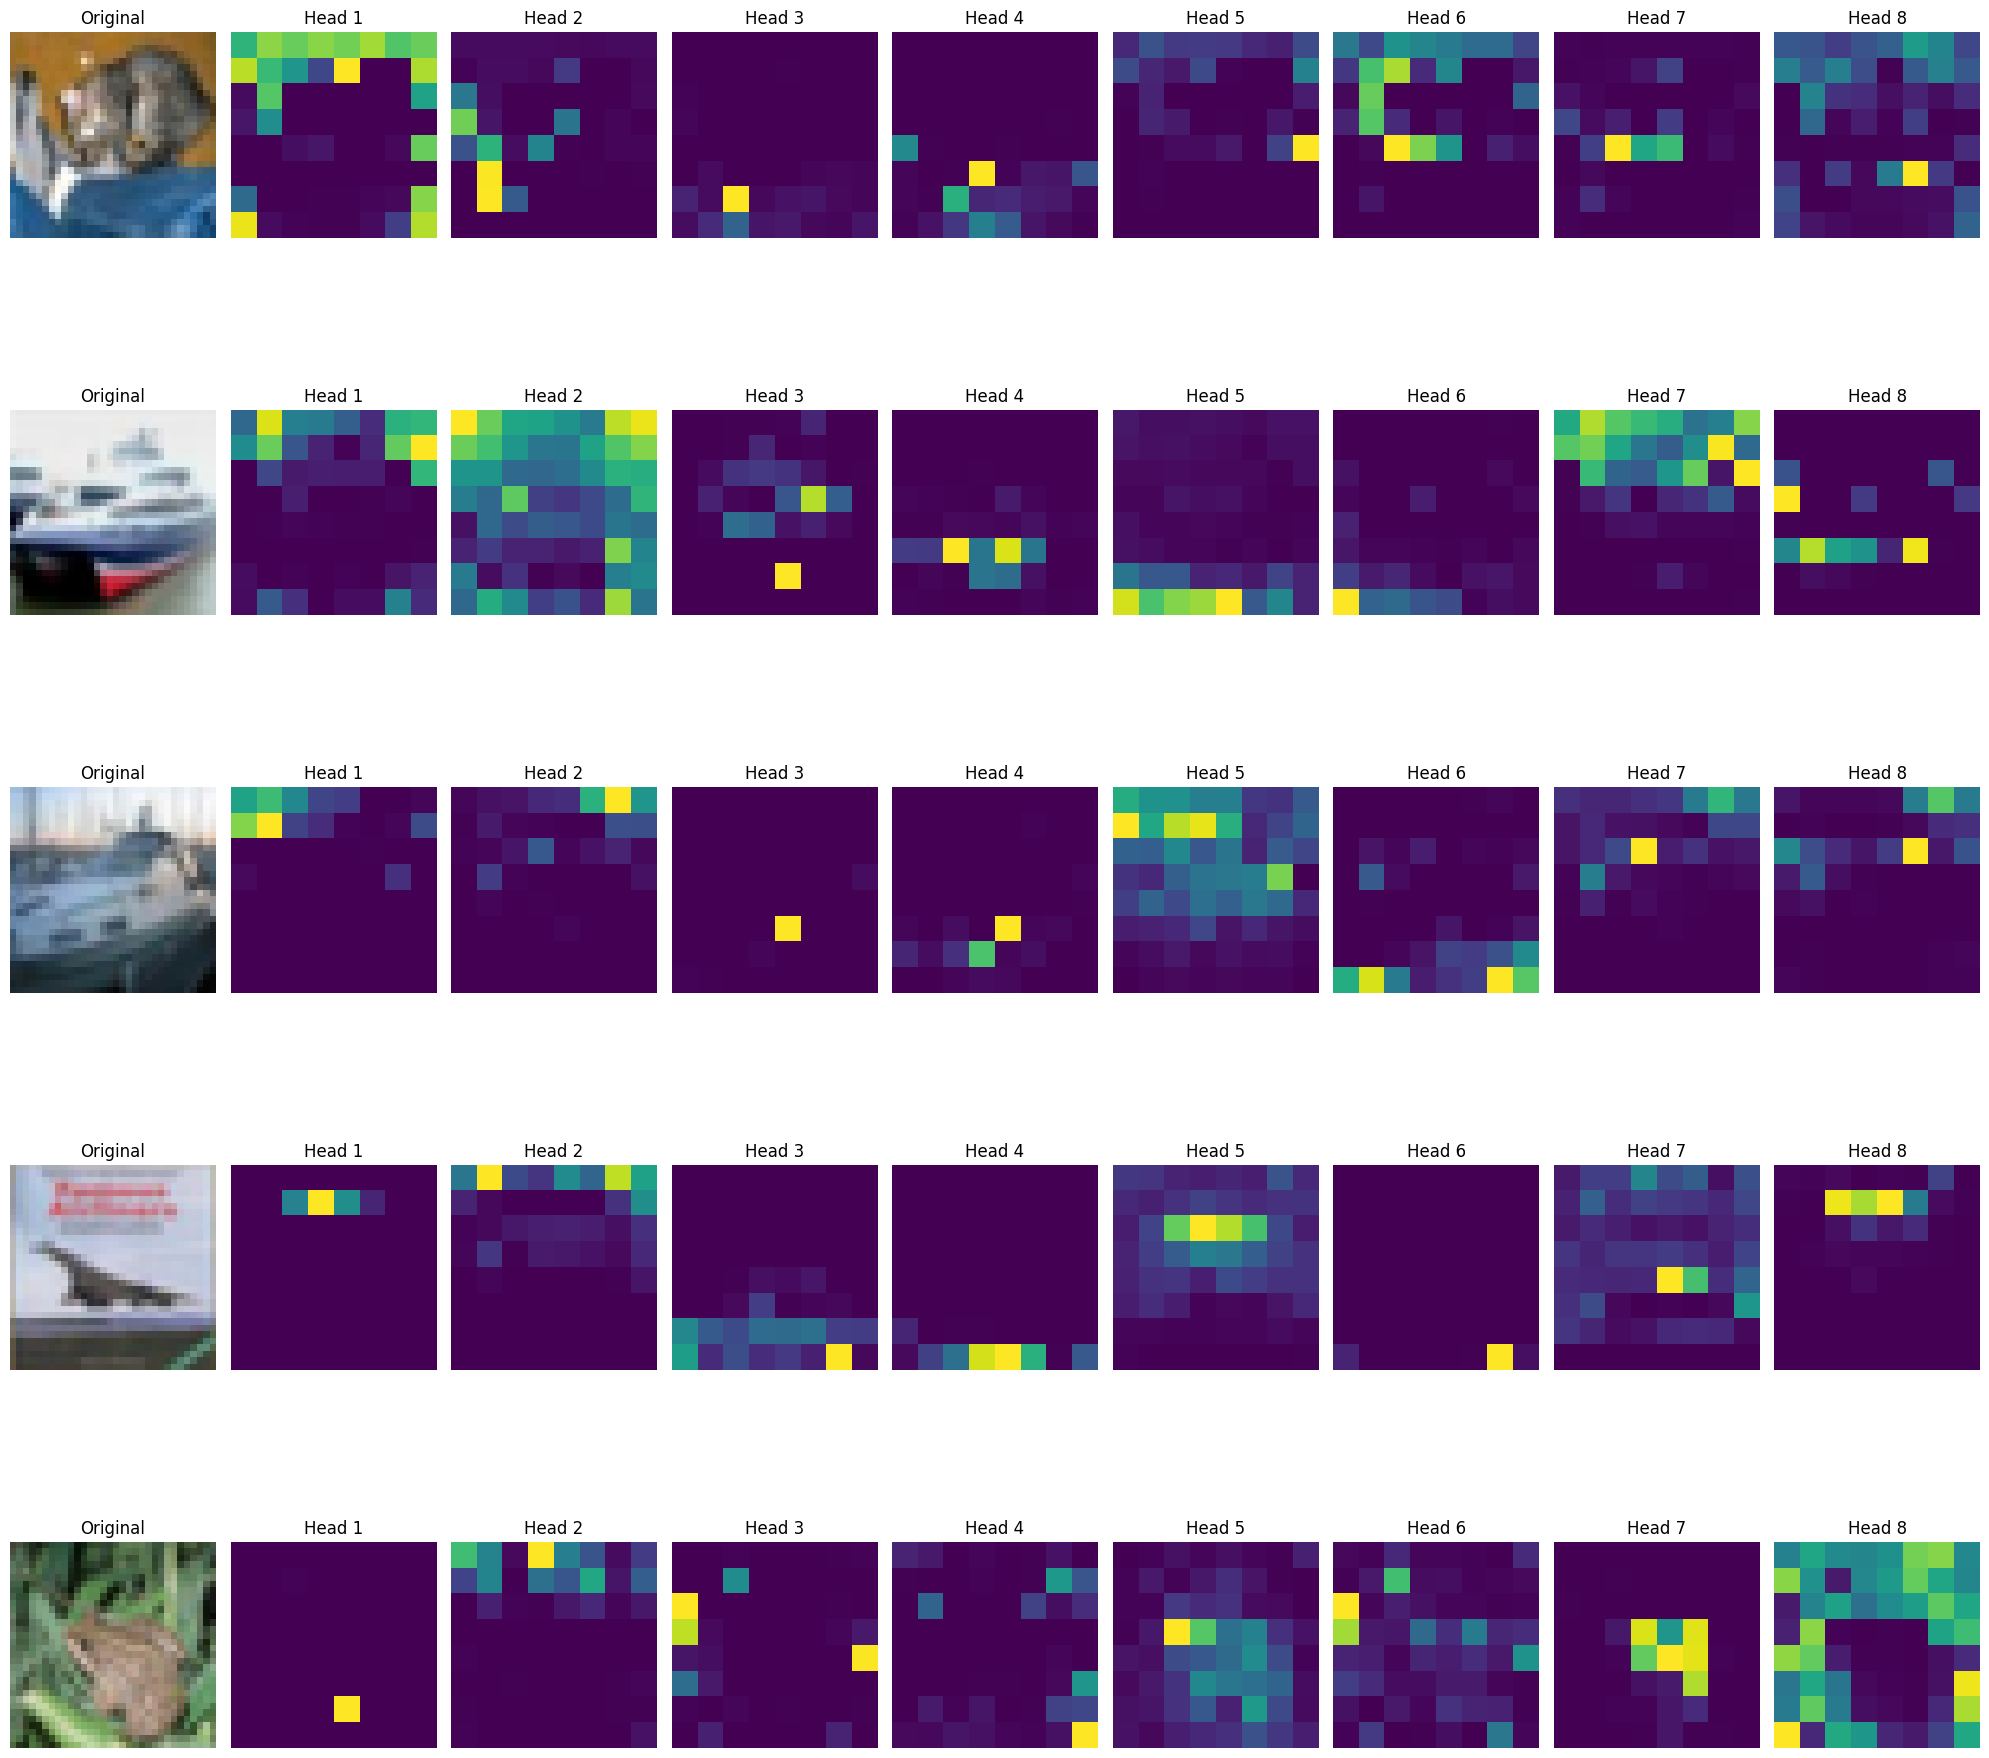

Experiment completed in 28.81 minutes


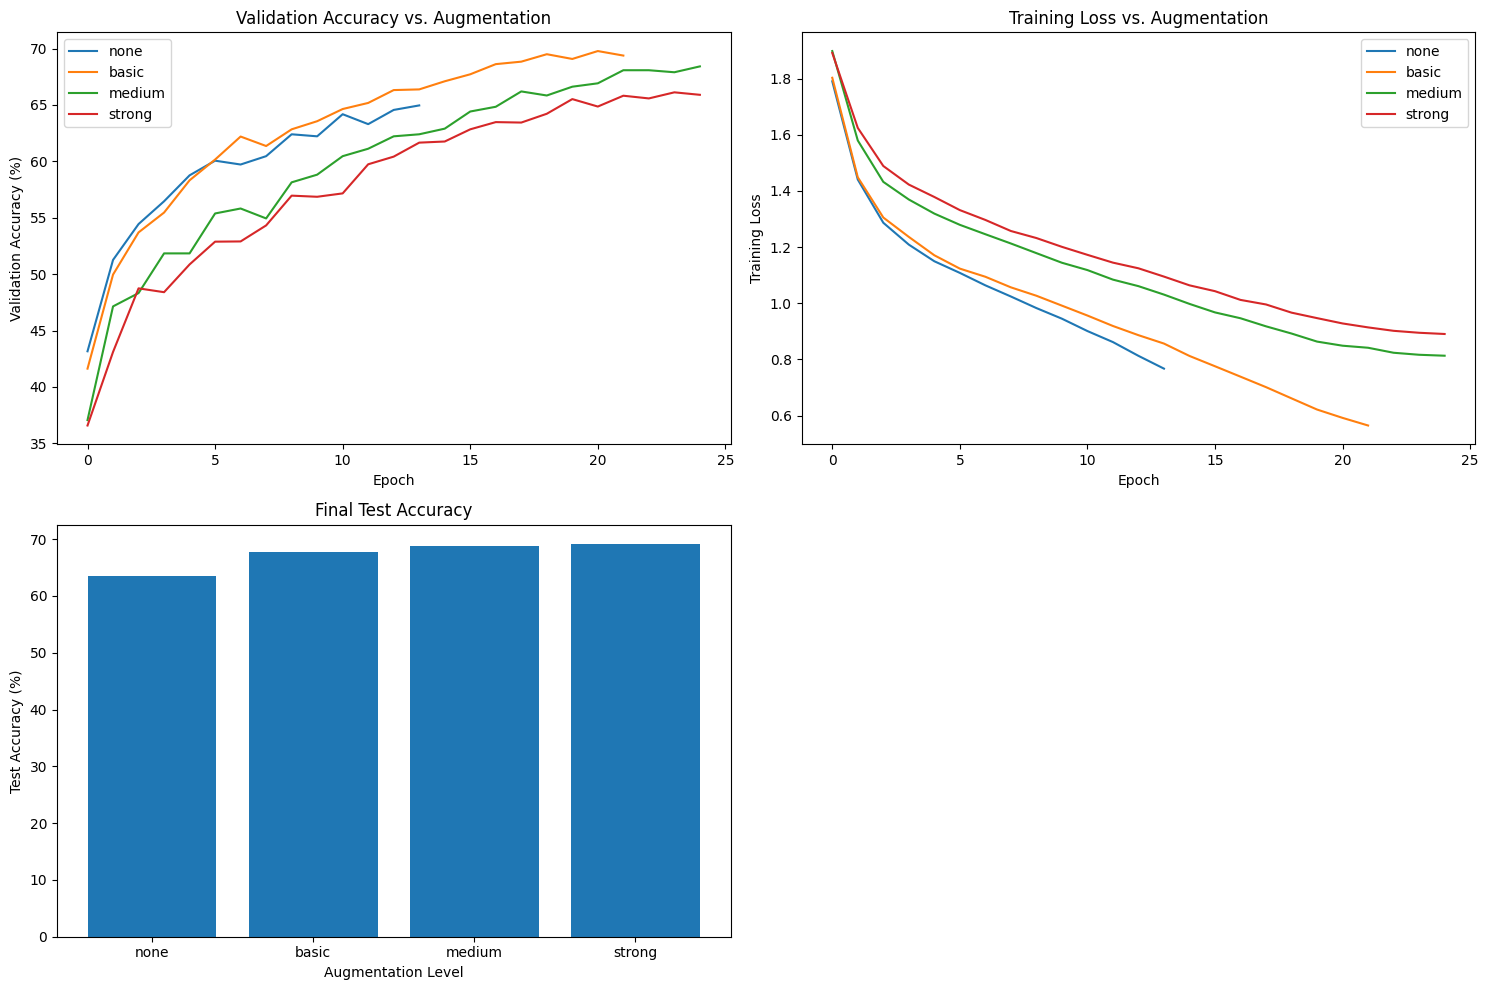


Best augmentation level: strong
Test accuracy: 69.07%


In [ ]:
print("\n" + "="*80)
print("EXPERIMENT 3: DATA AUGMENTATION")
print("="*80)
augmentation_results, best_aug = compare_augmentations(epochs=25, config=best_config)

#### Basic to medium augmentations (e.g., flip, crop) improve both validation accuracy and final test accuracy.Strong augmentation slightly reduces performance, likely due to excessive transformations hurting data quality.

### BEST CONFIGURATION WITH HIGHEST ACCURACY

Model parameters: 4,249,354
Starting experiment: best mide


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.9, acc=28.3]


  Validation loss improved. Saving model.
Epoch 1/50: Train Loss: 1.9046, Train Acc: 28.27%, Val Loss: 1.7539, Val Acc: 35.06%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s, loss=1.64, acc=39.6]


  Validation loss improved. Saving model.
Epoch 2/50: Train Loss: 1.6410, Train Acc: 39.63%, Val Loss: 1.5244, Val Acc: 44.84%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=1.5, acc=45.2]


  Validation loss improved. Saving model.
Epoch 3/50: Train Loss: 1.5018, Train Acc: 45.22%, Val Loss: 1.4828, Val Acc: 46.50%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s, loss=1.43, acc=48]


  Validation loss improved. Saving model.
Epoch 4/50: Train Loss: 1.4306, Train Acc: 48.00%, Val Loss: 1.3883, Val Acc: 49.80%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s, loss=1.38, acc=49.9]


  Validation loss improved. Saving model.
Epoch 5/50: Train Loss: 1.3765, Train Acc: 49.91%, Val Loss: 1.3172, Val Acc: 51.80%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.38it/s, loss=1.34, acc=51.5]


  Validation loss improved. Saving model.
Epoch 6/50: Train Loss: 1.3354, Train Acc: 51.55%, Val Loss: 1.2658, Val Acc: 54.34%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.40it/s, loss=1.31, acc=52.6]


  Validation loss improved. Saving model.
Epoch 7/50: Train Loss: 1.3082, Train Acc: 52.55%, Val Loss: 1.2378, Val Acc: 55.34%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.38it/s, loss=1.27, acc=54]


  No improvement in val loss for 1 epochs.
Epoch 8/50: Train Loss: 1.2724, Train Acc: 53.98%, Val Loss: 1.2509, Val Acc: 53.98%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.38it/s, loss=1.24, acc=55.1]


  Validation loss improved. Saving model.
Epoch 9/50: Train Loss: 1.2443, Train Acc: 55.08%, Val Loss: 1.1895, Val Acc: 56.92%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.23, acc=55.9]


  No improvement in val loss for 1 epochs.
Epoch 10/50: Train Loss: 1.2260, Train Acc: 55.88%, Val Loss: 1.2091, Val Acc: 56.02%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.2, acc=56.8]


  Validation loss improved. Saving model.
Epoch 11/50: Train Loss: 1.1969, Train Acc: 56.84%, Val Loss: 1.1385, Val Acc: 59.38%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=1.17, acc=57.7]


  No improvement in val loss for 1 epochs.
Epoch 12/50: Train Loss: 1.1722, Train Acc: 57.67%, Val Loss: 1.1699, Val Acc: 58.44%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=1.15, acc=58.3]


  Validation loss improved. Saving model.
Epoch 13/50: Train Loss: 1.1508, Train Acc: 58.30%, Val Loss: 1.1154, Val Acc: 59.50%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=1.13, acc=59.1]


  Validation loss improved. Saving model.
Epoch 14/50: Train Loss: 1.1338, Train Acc: 59.15%, Val Loss: 1.0975, Val Acc: 60.76%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=1.1, acc=60.2]


  Validation loss improved. Saving model.
Epoch 15/50: Train Loss: 1.1045, Train Acc: 60.16%, Val Loss: 1.0781, Val Acc: 60.82%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s, loss=1.09, acc=61]


  Validation loss improved. Saving model.
Epoch 16/50: Train Loss: 1.0862, Train Acc: 60.98%, Val Loss: 1.0303, Val Acc: 62.16%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s, loss=1.06, acc=62]


  No improvement in val loss for 1 epochs.
Epoch 17/50: Train Loss: 1.0632, Train Acc: 62.02%, Val Loss: 1.0344, Val Acc: 62.28%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s, loss=1.05, acc=62.1]


  Validation loss improved. Saving model.
Epoch 18/50: Train Loss: 1.0511, Train Acc: 62.07%, Val Loss: 1.0295, Val Acc: 62.90%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=1.02, acc=63.3]


  Validation loss improved. Saving model.
Epoch 19/50: Train Loss: 1.0248, Train Acc: 63.28%, Val Loss: 1.0039, Val Acc: 64.12%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.01, acc=64.1]


  Validation loss improved. Saving model.
Epoch 20/50: Train Loss: 1.0063, Train Acc: 64.10%, Val Loss: 0.9867, Val Acc: 64.58%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.42it/s, loss=0.994, acc=64.4]


  Validation loss improved. Saving model.
Epoch 21/50: Train Loss: 0.9938, Train Acc: 64.36%, Val Loss: 0.9763, Val Acc: 64.94%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=0.969, acc=65.4]


  Validation loss improved. Saving model.
Epoch 22/50: Train Loss: 0.9691, Train Acc: 65.42%, Val Loss: 0.9311, Val Acc: 67.34%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=0.955, acc=65.7]


  No improvement in val loss for 1 epochs.
Epoch 23/50: Train Loss: 0.9553, Train Acc: 65.72%, Val Loss: 0.9572, Val Acc: 65.42%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s, loss=0.933, acc=66.6]


  No improvement in val loss for 2 epochs.
Epoch 24/50: Train Loss: 0.9332, Train Acc: 66.60%, Val Loss: 0.9560, Val Acc: 66.22%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=0.913, acc=67.6]


  Validation loss improved. Saving model.
Epoch 25/50: Train Loss: 0.9127, Train Acc: 67.57%, Val Loss: 0.8851, Val Acc: 68.34%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, loss=0.897, acc=67.9]


  Validation loss improved. Saving model.
Epoch 26/50: Train Loss: 0.8975, Train Acc: 67.87%, Val Loss: 0.8801, Val Acc: 68.82%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=0.876, acc=68.8]


  Validation loss improved. Saving model.
Epoch 27/50: Train Loss: 0.8765, Train Acc: 68.78%, Val Loss: 0.8631, Val Acc: 69.74%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=0.855, acc=69.7]


  Validation loss improved. Saving model.
Epoch 28/50: Train Loss: 0.8551, Train Acc: 69.68%, Val Loss: 0.8554, Val Acc: 68.98%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, loss=0.845, acc=69.9]


  No improvement in val loss for 1 epochs.
Epoch 29/50: Train Loss: 0.8451, Train Acc: 69.94%, Val Loss: 0.8621, Val Acc: 69.00%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s, loss=0.824, acc=70.8]


  Validation loss improved. Saving model.
Epoch 30/50: Train Loss: 0.8241, Train Acc: 70.84%, Val Loss: 0.8514, Val Acc: 70.06%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=0.803, acc=71.6]


  Validation loss improved. Saving model.
Epoch 31/50: Train Loss: 0.8028, Train Acc: 71.56%, Val Loss: 0.8484, Val Acc: 70.24%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.784, acc=72]


  No improvement in val loss for 1 epochs.
Epoch 32/50: Train Loss: 0.7841, Train Acc: 71.99%, Val Loss: 0.8571, Val Acc: 70.16%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.777, acc=72.3]


  Validation loss improved. Saving model.
Epoch 33/50: Train Loss: 0.7768, Train Acc: 72.26%, Val Loss: 0.8209, Val Acc: 71.20%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s, loss=0.76, acc=72.8]


  Validation loss improved. Saving model.
Epoch 34/50: Train Loss: 0.7604, Train Acc: 72.77%, Val Loss: 0.7983, Val Acc: 71.84%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=0.751, acc=73.3]


  Validation loss improved. Saving model.
Epoch 35/50: Train Loss: 0.7509, Train Acc: 73.27%, Val Loss: 0.7883, Val Acc: 72.14%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, loss=0.729, acc=73.9]


  Validation loss improved. Saving model.
Epoch 36/50: Train Loss: 0.7295, Train Acc: 73.94%, Val Loss: 0.7768, Val Acc: 72.62%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, loss=0.715, acc=74.5]


  No improvement in val loss for 1 epochs.
Epoch 37/50: Train Loss: 0.7148, Train Acc: 74.52%, Val Loss: 0.7820, Val Acc: 72.10%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.32it/s, loss=0.71, acc=74.8]


  Validation loss improved. Saving model.
Epoch 38/50: Train Loss: 0.7096, Train Acc: 74.81%, Val Loss: 0.7644, Val Acc: 73.60%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s, loss=0.7, acc=74.9]


  No improvement in val loss for 1 epochs.
Epoch 39/50: Train Loss: 0.6995, Train Acc: 74.89%, Val Loss: 0.7699, Val Acc: 73.38%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s, loss=0.684, acc=75.7]


  Validation loss improved. Saving model.
Epoch 40/50: Train Loss: 0.6836, Train Acc: 75.68%, Val Loss: 0.7578, Val Acc: 73.74%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s, loss=0.682, acc=75.8]


  No improvement in val loss for 1 epochs.
Epoch 41/50: Train Loss: 0.6819, Train Acc: 75.78%, Val Loss: 0.7644, Val Acc: 74.18%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=0.669, acc=76.1]


  No improvement in val loss for 2 epochs.
Epoch 42/50: Train Loss: 0.6693, Train Acc: 76.14%, Val Loss: 0.7706, Val Acc: 73.98%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.38it/s, loss=0.66, acc=76.5]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 0.7008, Test Acc: 75.90%


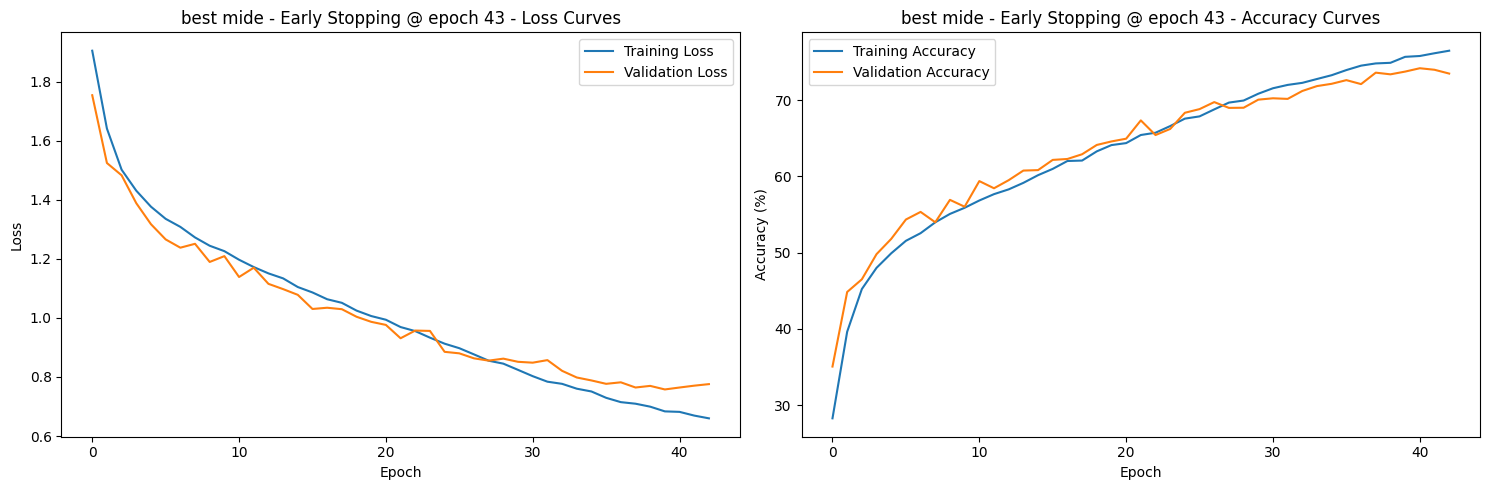

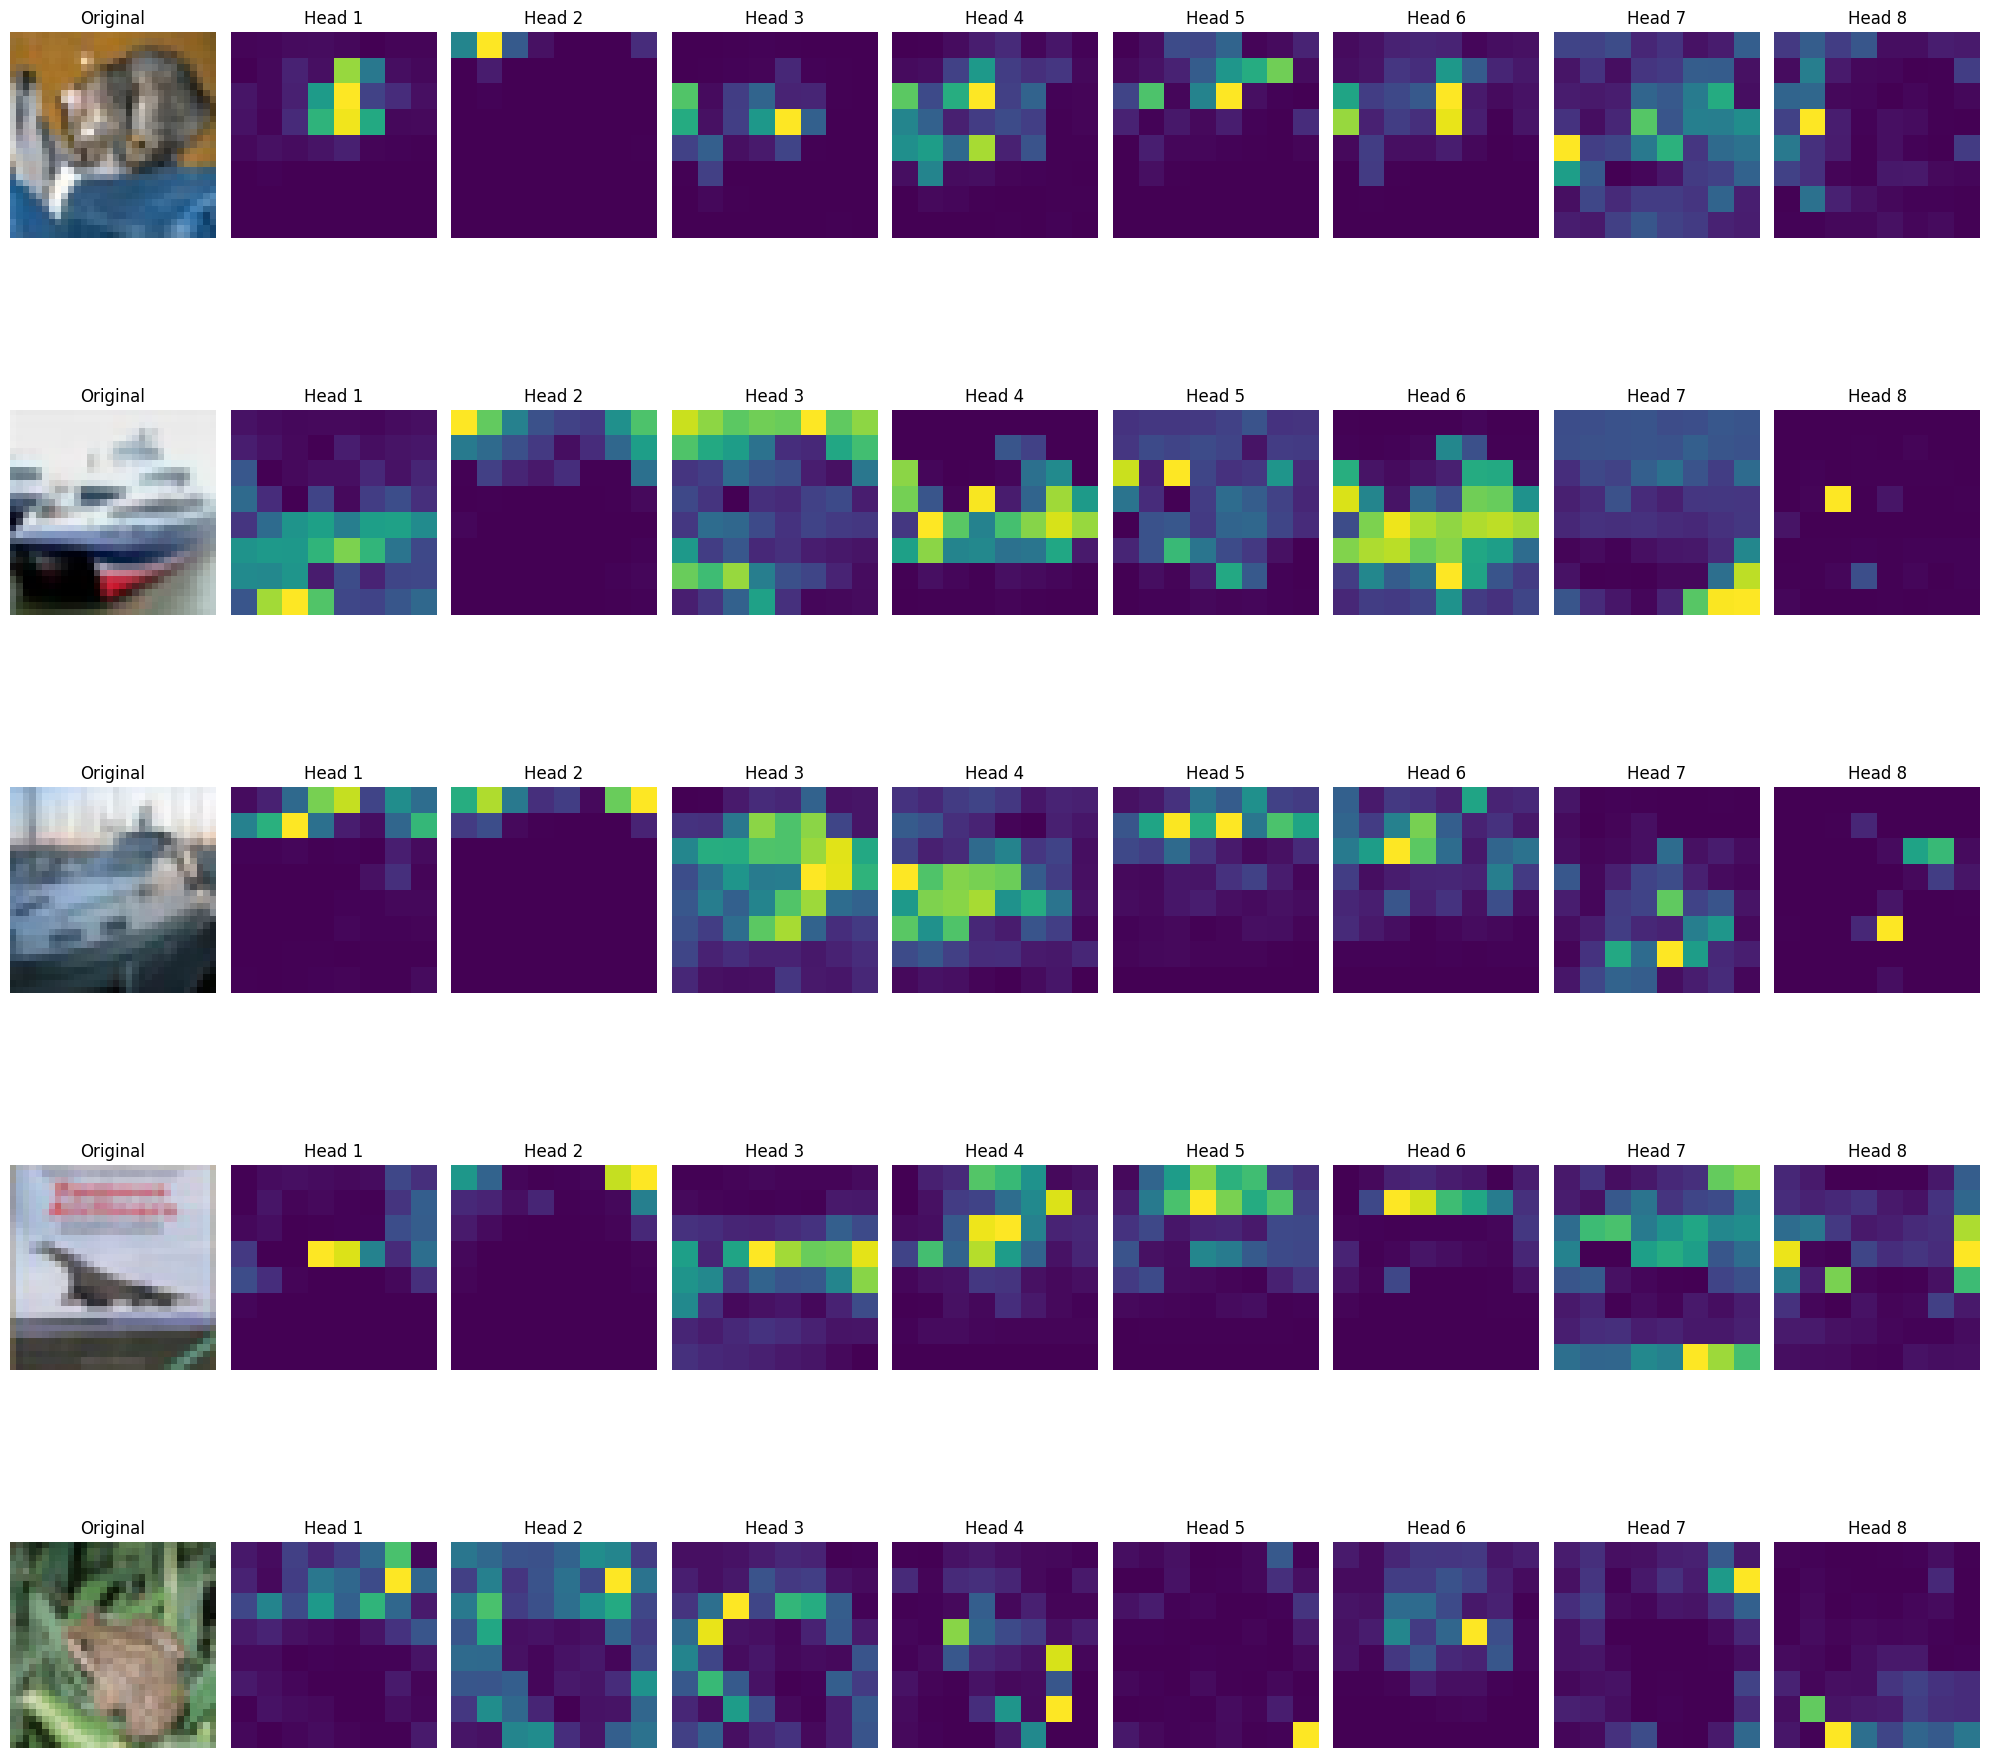

Experiment completed in 37.26 minutes


{'train_losses': [1.90458922835456,
  1.640976321029663,
  1.5017865331437852,
  1.4306337651146783,
  1.376509775543213,
  1.3354235178841485,
  1.3082091241412692,
  1.2724351053025988,
  1.2443107559627957,
  1.225971506076389,
  1.1969278178956773,
  1.1721584038628472,
  1.1507771041022408,
  1.1338351339128283,
  1.1045403700934515,
  1.086188011127048,
  1.0632000134362114,
  1.0510852698432074,
  1.024776715681288,
  1.0063338852776422,
  0.9937912392404344,
  0.9690514871915181,
  0.9553184417512681,
  0.9331547955830892,
  0.9127472113821241,
  0.8974690851529439,
  0.8764656575202942,
  0.855108138317532,
  0.8451251738442315,
  0.824060856352912,
  0.8027513475735982,
  0.7840972359869215,
  0.7768050094498529,
  0.7603776542133756,
  0.7509445412953695,
  0.7294887875874837,
  0.7148411032252842,
  0.7095515274047851,
  0.6995361077944438,
  0.6835584826469422,
  0.6818982911427816,
  0.6693308652030097,
  0.6599981723573473],
 'val_losses': [1.753893427658081,
  1.5244149

In [ ]:
exp_name = "best model"
epochs = 50
aug_level = "strong"

# Create the ViTConfig using class-based initialization
config = ViTConfig(
    patch_size=2,
    hidden_size=256,
    num_attention_heads=8,
    num_hidden_layers=12,
    intermediate_size=int(256 * 2.0),  # mlp_ratio * hidden_size
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    pos_embedding_type="1d",
)


# Run your experiment with the specified config
run_experiment(config=config, epochs=epochs, augmentation_level=aug_level, exp_name=exp_name)

Model parameters: 6,357,770
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: best model


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.91, acc=28]  


  Validation loss improved. Saving model.
Epoch 1/50: Train Loss: 1.9106, Train Acc: 28.05%, Val Loss: 1.7772, Val Acc: 32.80%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.07it/s, loss=1.66, acc=38.2]


  Validation loss improved. Saving model.
Epoch 2/50: Train Loss: 1.6639, Train Acc: 38.22%, Val Loss: 1.5835, Val Acc: 42.62%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.07it/s, loss=1.52, acc=44.2]


  Validation loss improved. Saving model.
Epoch 3/50: Train Loss: 1.5244, Train Acc: 44.17%, Val Loss: 1.4657, Val Acc: 46.52%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.44, acc=47.2]


  Validation loss improved. Saving model.
Epoch 4/50: Train Loss: 1.4448, Train Acc: 47.19%, Val Loss: 1.4218, Val Acc: 49.52%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=1.39, acc=49]  


  Validation loss improved. Saving model.
Epoch 5/50: Train Loss: 1.3925, Train Acc: 49.03%, Val Loss: 1.3668, Val Acc: 49.58%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.34, acc=51.1]


  No improvement in val loss for 1 epochs.
Epoch 6/50: Train Loss: 1.3416, Train Acc: 51.14%, Val Loss: 1.4077, Val Acc: 50.20%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.31, acc=52.2]


  Validation loss improved. Saving model.
Epoch 7/50: Train Loss: 1.3123, Train Acc: 52.24%, Val Loss: 1.3073, Val Acc: 53.22%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.28, acc=53.5]


  Validation loss improved. Saving model.
Epoch 8/50: Train Loss: 1.2770, Train Acc: 53.50%, Val Loss: 1.2732, Val Acc: 54.32%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.25, acc=54.7]


  Validation loss improved. Saving model.
Epoch 9/50: Train Loss: 1.2541, Train Acc: 54.73%, Val Loss: 1.2645, Val Acc: 53.82%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.23, acc=55.6]


  Validation loss improved. Saving model.
Epoch 10/50: Train Loss: 1.2258, Train Acc: 55.64%, Val Loss: 1.2126, Val Acc: 56.08%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.2, acc=56.4] 


  Validation loss improved. Saving model.
Epoch 11/50: Train Loss: 1.2006, Train Acc: 56.43%, Val Loss: 1.1966, Val Acc: 57.50%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.18, acc=57.1]


  Validation loss improved. Saving model.
Epoch 12/50: Train Loss: 1.1823, Train Acc: 57.06%, Val Loss: 1.1684, Val Acc: 57.98%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.16, acc=57.9]


  Validation loss improved. Saving model.
Epoch 13/50: Train Loss: 1.1632, Train Acc: 57.91%, Val Loss: 1.1513, Val Acc: 58.18%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.14, acc=58.8]


  No improvement in val loss for 1 epochs.
Epoch 14/50: Train Loss: 1.1385, Train Acc: 58.85%, Val Loss: 1.1963, Val Acc: 57.72%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.12, acc=59.5]


  Validation loss improved. Saving model.
Epoch 15/50: Train Loss: 1.1225, Train Acc: 59.48%, Val Loss: 1.1353, Val Acc: 58.74%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.1, acc=60.4] 


  Validation loss improved. Saving model.
Epoch 16/50: Train Loss: 1.1020, Train Acc: 60.36%, Val Loss: 1.1248, Val Acc: 59.28%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.08, acc=61.1]


  Validation loss improved. Saving model.
Epoch 17/50: Train Loss: 1.0835, Train Acc: 61.08%, Val Loss: 1.1028, Val Acc: 60.06%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.07it/s, loss=1.06, acc=62]  


  Validation loss improved. Saving model.
Epoch 18/50: Train Loss: 1.0624, Train Acc: 62.02%, Val Loss: 1.0700, Val Acc: 61.52%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.05, acc=62.1]


  Validation loss improved. Saving model.
Epoch 19/50: Train Loss: 1.0478, Train Acc: 62.11%, Val Loss: 1.0525, Val Acc: 62.26%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=1.03, acc=63.2]


  No improvement in val loss for 1 epochs.
Epoch 20/50: Train Loss: 1.0281, Train Acc: 63.19%, Val Loss: 1.0605, Val Acc: 61.88%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=1.02, acc=63.2]


  Validation loss improved. Saving model.
Epoch 21/50: Train Loss: 1.0239, Train Acc: 63.19%, Val Loss: 1.0450, Val Acc: 63.08%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=0.997, acc=64.3]


  Validation loss improved. Saving model.
Epoch 22/50: Train Loss: 0.9970, Train Acc: 64.31%, Val Loss: 1.0312, Val Acc: 63.28%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.975, acc=64.9]


  No improvement in val loss for 1 epochs.
Epoch 23/50: Train Loss: 0.9746, Train Acc: 64.90%, Val Loss: 1.0466, Val Acc: 62.94%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.966, acc=65.4]


  Validation loss improved. Saving model.
Epoch 24/50: Train Loss: 0.9665, Train Acc: 65.40%, Val Loss: 1.0109, Val Acc: 63.76%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.945, acc=66.1]


  Validation loss improved. Saving model.
Epoch 25/50: Train Loss: 0.9451, Train Acc: 66.11%, Val Loss: 0.9838, Val Acc: 65.44%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.931, acc=66.6]


  Validation loss improved. Saving model.
Epoch 26/50: Train Loss: 0.9306, Train Acc: 66.56%, Val Loss: 0.9789, Val Acc: 64.62%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.905, acc=67.5]


  No improvement in val loss for 1 epochs.
Epoch 27/50: Train Loss: 0.9054, Train Acc: 67.53%, Val Loss: 0.9798, Val Acc: 65.00%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.891, acc=68.5]


  Validation loss improved. Saving model.
Epoch 28/50: Train Loss: 0.8913, Train Acc: 68.46%, Val Loss: 0.9551, Val Acc: 66.30%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.875, acc=68.6]


  Validation loss improved. Saving model.
Epoch 29/50: Train Loss: 0.8745, Train Acc: 68.58%, Val Loss: 0.9442, Val Acc: 66.82%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.852, acc=69.9]


  Validation loss improved. Saving model.
Epoch 30/50: Train Loss: 0.8518, Train Acc: 69.85%, Val Loss: 0.9308, Val Acc: 67.36%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.844, acc=70.1]


  Validation loss improved. Saving model.
Epoch 31/50: Train Loss: 0.8437, Train Acc: 70.15%, Val Loss: 0.9000, Val Acc: 68.20%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.824, acc=70.5]


  Validation loss improved. Saving model.
Epoch 32/50: Train Loss: 0.8245, Train Acc: 70.52%, Val Loss: 0.8952, Val Acc: 68.68%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=0.808, acc=70.9]


  Validation loss improved. Saving model.
Epoch 33/50: Train Loss: 0.8081, Train Acc: 70.92%, Val Loss: 0.8800, Val Acc: 68.82%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=0.788, acc=71.7]


  No improvement in val loss for 1 epochs.
Epoch 34/50: Train Loss: 0.7882, Train Acc: 71.71%, Val Loss: 0.9041, Val Acc: 69.00%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.773, acc=72.4]


  No improvement in val loss for 2 epochs.
Epoch 35/50: Train Loss: 0.7728, Train Acc: 72.44%, Val Loss: 0.8801, Val Acc: 69.08%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=0.766, acc=72.7]


  Validation loss improved. Saving model.
Epoch 36/50: Train Loss: 0.7661, Train Acc: 72.73%, Val Loss: 0.8715, Val Acc: 69.88%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.749, acc=73.2]


  Validation loss improved. Saving model.
Epoch 37/50: Train Loss: 0.7494, Train Acc: 73.25%, Val Loss: 0.8419, Val Acc: 70.66%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.735, acc=73.9]


  No improvement in val loss for 1 epochs.
Epoch 38/50: Train Loss: 0.7351, Train Acc: 73.95%, Val Loss: 0.8624, Val Acc: 70.30%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.726, acc=74.1]


  Validation loss improved. Saving model.
Epoch 39/50: Train Loss: 0.7258, Train Acc: 74.06%, Val Loss: 0.8377, Val Acc: 70.40%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.714, acc=74.5]


  No improvement in val loss for 1 epochs.
Epoch 40/50: Train Loss: 0.7142, Train Acc: 74.51%, Val Loss: 0.8511, Val Acc: 70.44%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=0.708, acc=74.9]


  No improvement in val loss for 2 epochs.
Epoch 41/50: Train Loss: 0.7076, Train Acc: 74.90%, Val Loss: 0.8443, Val Acc: 71.36%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.698, acc=75.1]


  Validation loss improved. Saving model.
Epoch 42/50: Train Loss: 0.6976, Train Acc: 75.15%, Val Loss: 0.8338, Val Acc: 71.56%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.688, acc=75.6]


  No improvement in val loss for 1 epochs.
Epoch 43/50: Train Loss: 0.6878, Train Acc: 75.57%, Val Loss: 0.8407, Val Acc: 71.18%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.686, acc=75.4]


  No improvement in val loss for 2 epochs.
Epoch 44/50: Train Loss: 0.6863, Train Acc: 75.44%, Val Loss: 0.8427, Val Acc: 70.78%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.09it/s, loss=0.679, acc=75.8]


  Validation loss improved. Saving model.
Epoch 45/50: Train Loss: 0.6785, Train Acc: 75.81%, Val Loss: 0.8320, Val Acc: 72.24%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.10it/s, loss=0.677, acc=75.8]


  Validation loss improved. Saving model.
Epoch 46/50: Train Loss: 0.6766, Train Acc: 75.84%, Val Loss: 0.8112, Val Acc: 72.06%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.10it/s, loss=0.666, acc=76.1]


  No improvement in val loss for 1 epochs.
Epoch 47/50: Train Loss: 0.6658, Train Acc: 76.10%, Val Loss: 0.8352, Val Acc: 71.34%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.10it/s, loss=0.665, acc=76.3]


  No improvement in val loss for 2 epochs.
Epoch 48/50: Train Loss: 0.6655, Train Acc: 76.34%, Val Loss: 0.8221, Val Acc: 72.28%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.10it/s, loss=0.662, acc=76.3]


  Validation loss improved. Saving model.
Epoch 49/50: Train Loss: 0.6622, Train Acc: 76.31%, Val Loss: 0.8089, Val Acc: 72.14%


Training: 100%|██████████| 352/352 [00:43<00:00,  8.08it/s, loss=0.664, acc=76.3]


  No improvement in val loss for 1 epochs.
Epoch 50/50: Train Loss: 0.6644, Train Acc: 76.32%, Val Loss: 0.8387, Val Acc: 71.58%


/tmp/ipykernel_31/3680159736.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{exp_name}_best.pth'))


Test Loss: 0.7034, Test Acc: 75.72%


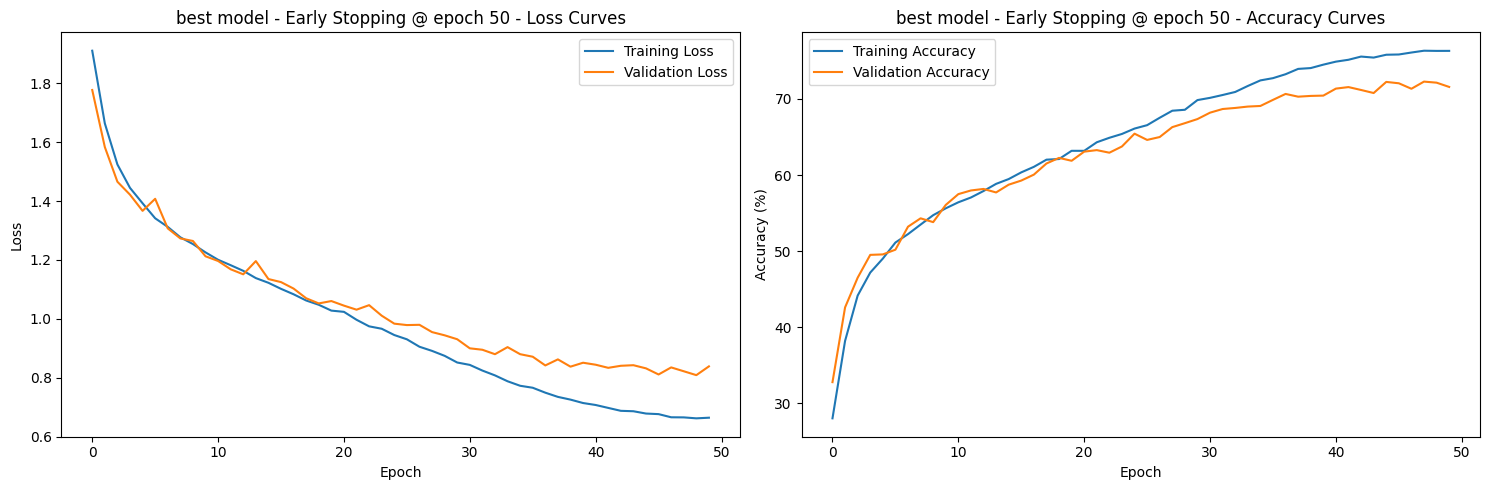

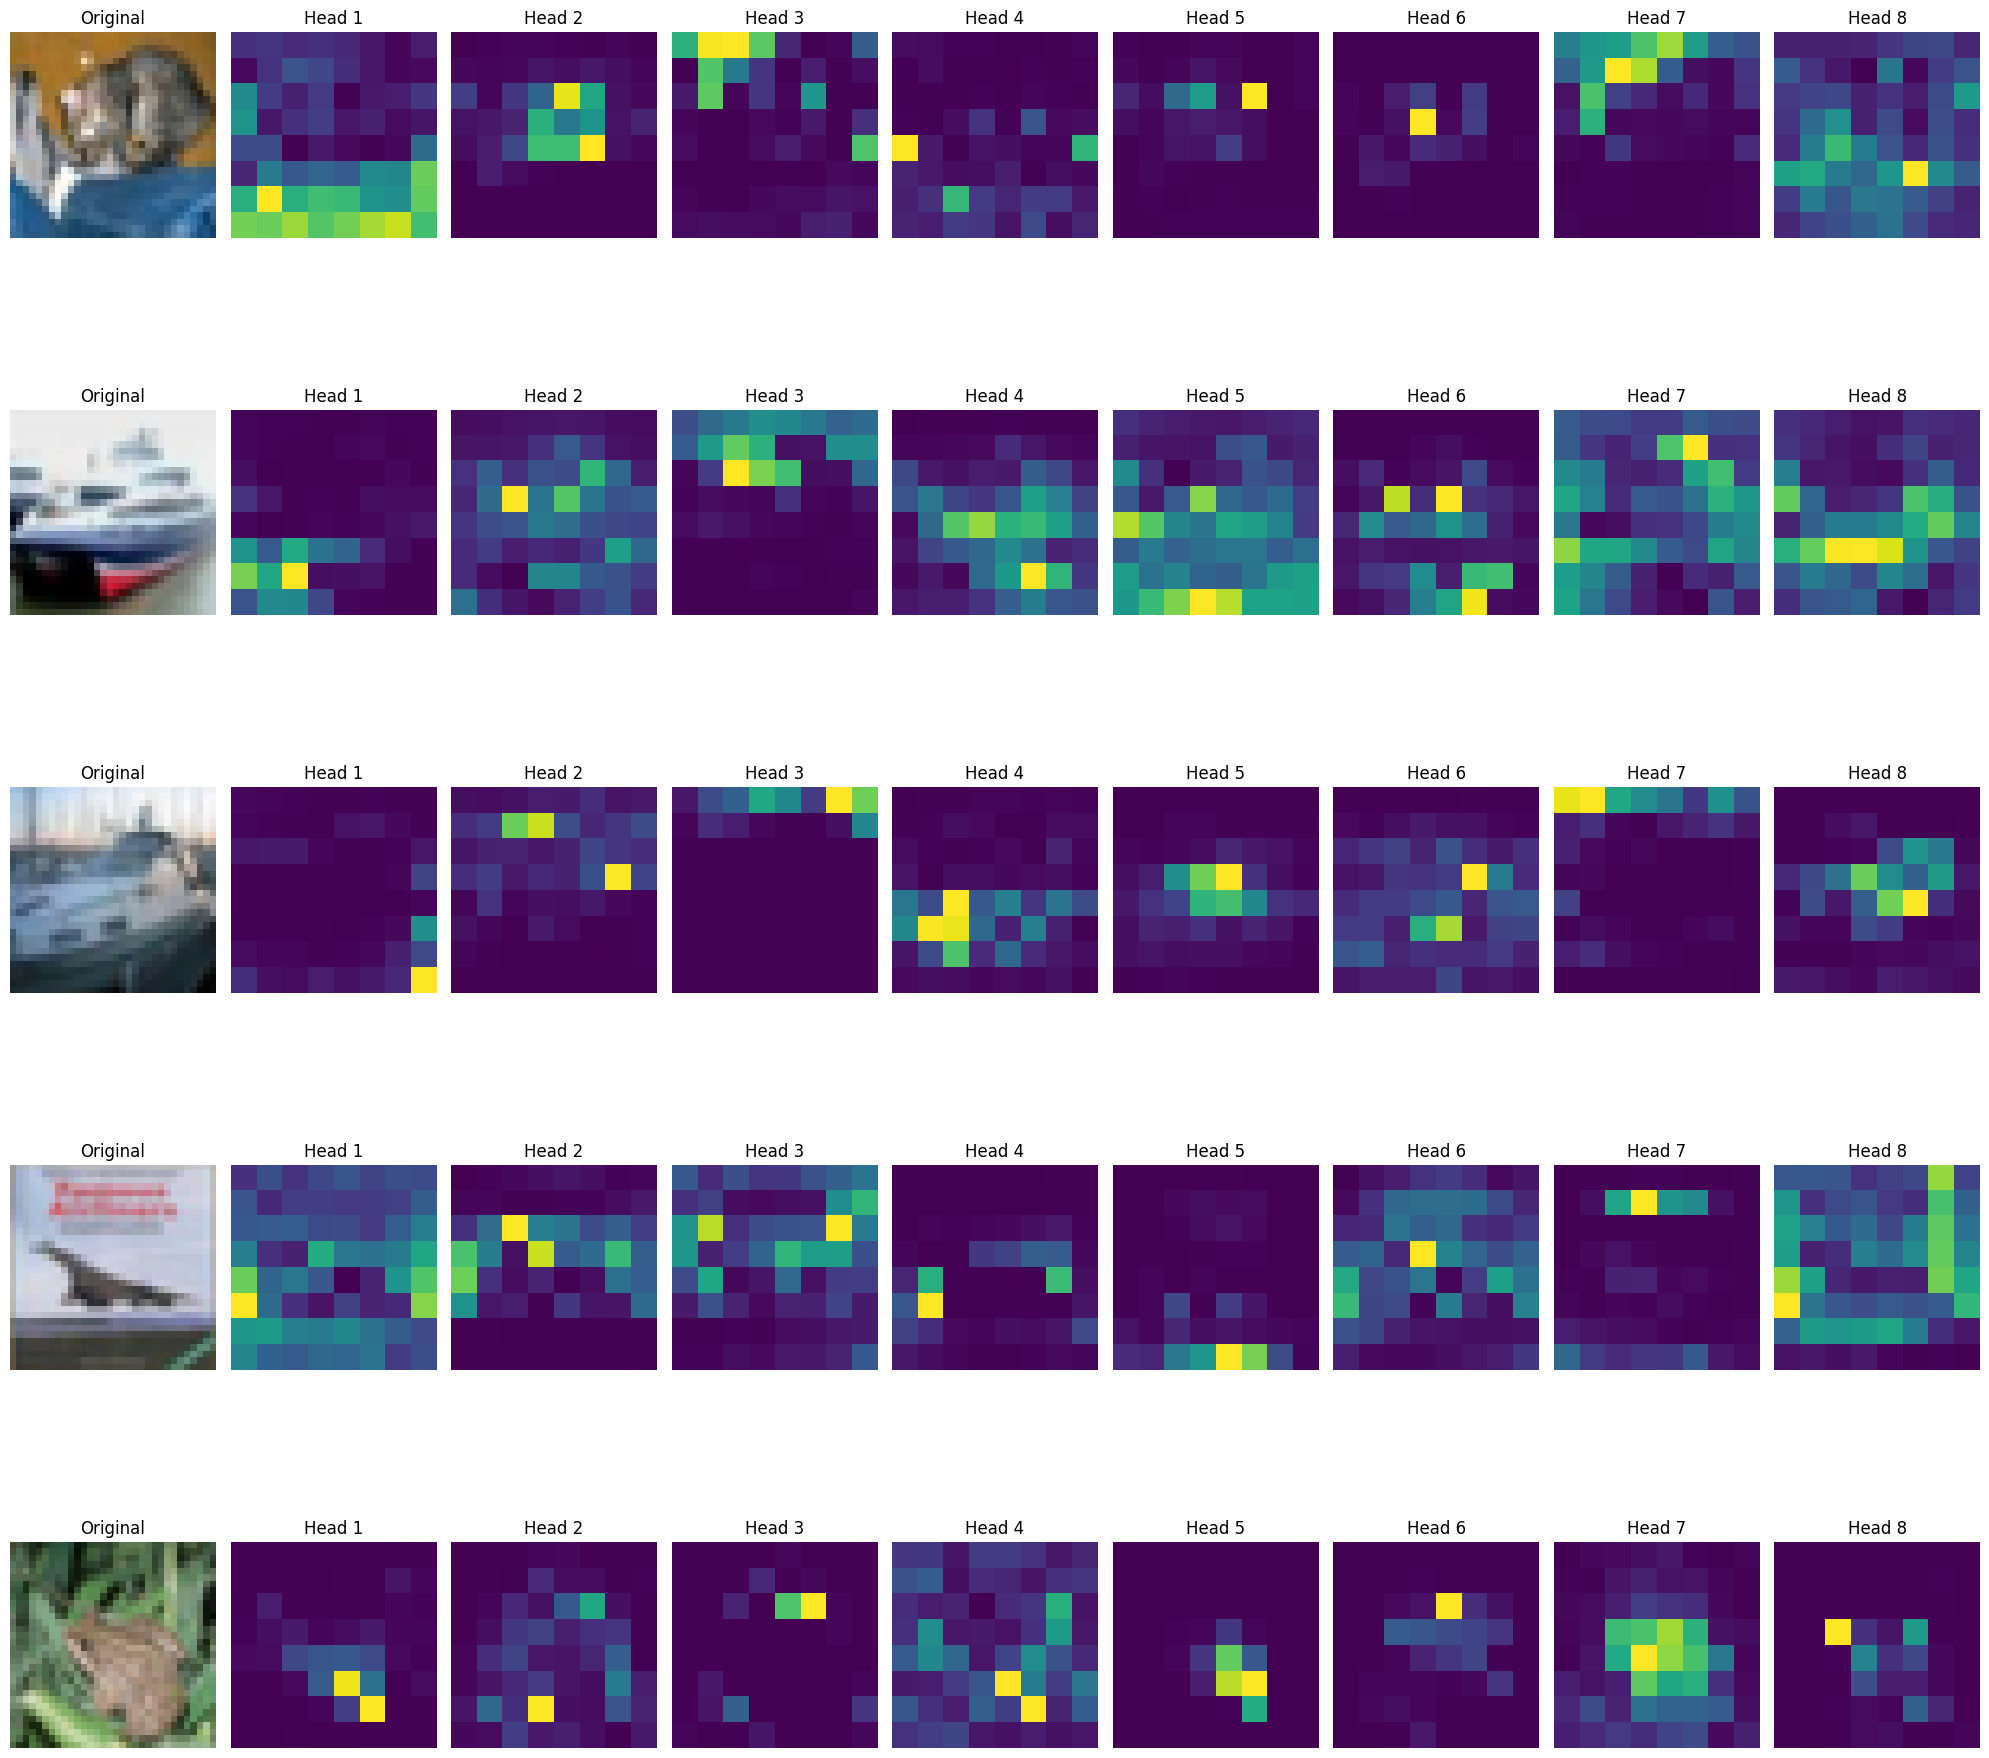

Experiment completed in 38.33 minutes


In [34]:
exp_name = "best model"
epochs = 50
aug_level = "strong"

# Create the ViTConfig using class-based initialization
config = ViTConfig(
    patch_size=4,
    hidden_size=256,
    num_attention_heads=8,
    num_hidden_layers=12,
    intermediate_size=int(256 * 2.0),  # mlp_ratio * hidden_size
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    pos_embedding_type="1d",
)


# Run your experiment with the specified config
result=run_experiment(config=config, epochs=epochs, augmentation_level=aug_level, exp_name=exp_name)

#### The best-performing model used a patch size of 2, with 12 transformer layers, 8 attention heads, and a hidden size of 256. Combined with strong data augmentation and trained for 50 epochs, this setup achieved over 75% test accuracy :  Deep architecture + fine patches + strong regularization = best results.

## EXPERIMENT 4: POSITIONAL EMBEDDINGS


EXPERIMENT 4: POSITIONAL EMBEDDINGS

Running experiment with positional embedding: none
Model parameters: 12,648,458
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: pos_embedding_none


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.83, acc=31.8]


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.8280, Train Acc: 31.84%, Val Loss: 1.6973, Val Acc: 35.06%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.6, acc=41.1] 


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.6042, Train Acc: 41.11%, Val Loss: 1.5484, Val Acc: 42.52%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.49, acc=45.5]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.4921, Train Acc: 45.47%, Val Loss: 1.4538, Val Acc: 46.70%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.42, acc=48.1]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.4239, Train Acc: 48.12%, Val Loss: 1.3977, Val Acc: 49.46%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.37, acc=49.9]


  No improvement in val loss for 1 epochs.
Epoch 5/25: Train Loss: 1.3743, Train Acc: 49.93%, Val Loss: 1.5140, Val Acc: 44.24%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.34, acc=51.4]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.3351, Train Acc: 51.38%, Val Loss: 1.3692, Val Acc: 49.98%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.29, acc=53.3]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.2922, Train Acc: 53.28%, Val Loss: 1.2879, Val Acc: 53.46%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.26, acc=54.4]


  Validation loss improved. Saving model.
Epoch 8/25: Train Loss: 1.2607, Train Acc: 54.44%, Val Loss: 1.2722, Val Acc: 53.52%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.22, acc=55.8]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 1.2174, Train Acc: 55.81%, Val Loss: 1.2444, Val Acc: 54.82%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.18, acc=57.7]


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 1.1801, Train Acc: 57.67%, Val Loss: 1.2444, Val Acc: 55.06%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.15, acc=58.5]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 1.1504, Train Acc: 58.52%, Val Loss: 1.2395, Val Acc: 55.76%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.11, acc=60.1]


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 1.1091, Train Acc: 60.10%, Val Loss: 1.2139, Val Acc: 56.92%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.07, acc=61.5]


  No improvement in val loss for 1 epochs.
Epoch 13/25: Train Loss: 1.0691, Train Acc: 61.51%, Val Loss: 1.2315, Val Acc: 56.14%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.03, acc=63.2]


  Validation loss improved. Saving model.
Epoch 14/25: Train Loss: 1.0258, Train Acc: 63.22%, Val Loss: 1.1952, Val Acc: 57.46%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=0.98, acc=64.7] 


  No improvement in val loss for 1 epochs.
Epoch 15/25: Train Loss: 0.9800, Train Acc: 64.69%, Val Loss: 1.2063, Val Acc: 57.92%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=0.929, acc=66.8]


  Validation loss improved. Saving model.
Epoch 16/25: Train Loss: 0.9294, Train Acc: 66.75%, Val Loss: 1.1851, Val Acc: 58.48%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=0.874, acc=68.6]


  Validation loss improved. Saving model.
Epoch 17/25: Train Loss: 0.8744, Train Acc: 68.59%, Val Loss: 1.1749, Val Acc: 59.14%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=0.815, acc=70.6]


  No improvement in val loss for 1 epochs.
Epoch 18/25: Train Loss: 0.8147, Train Acc: 70.65%, Val Loss: 1.2164, Val Acc: 58.80%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.762, acc=72.5]


  No improvement in val loss for 2 epochs.
Epoch 19/25: Train Loss: 0.7624, Train Acc: 72.54%, Val Loss: 1.2474, Val Acc: 58.48%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.709, acc=74.5]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.


/tmp/ipykernel_31/4049654737.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'models/{exp_name}_best.pth'))


Test Loss: 1.1907, Test Acc: 59.11%


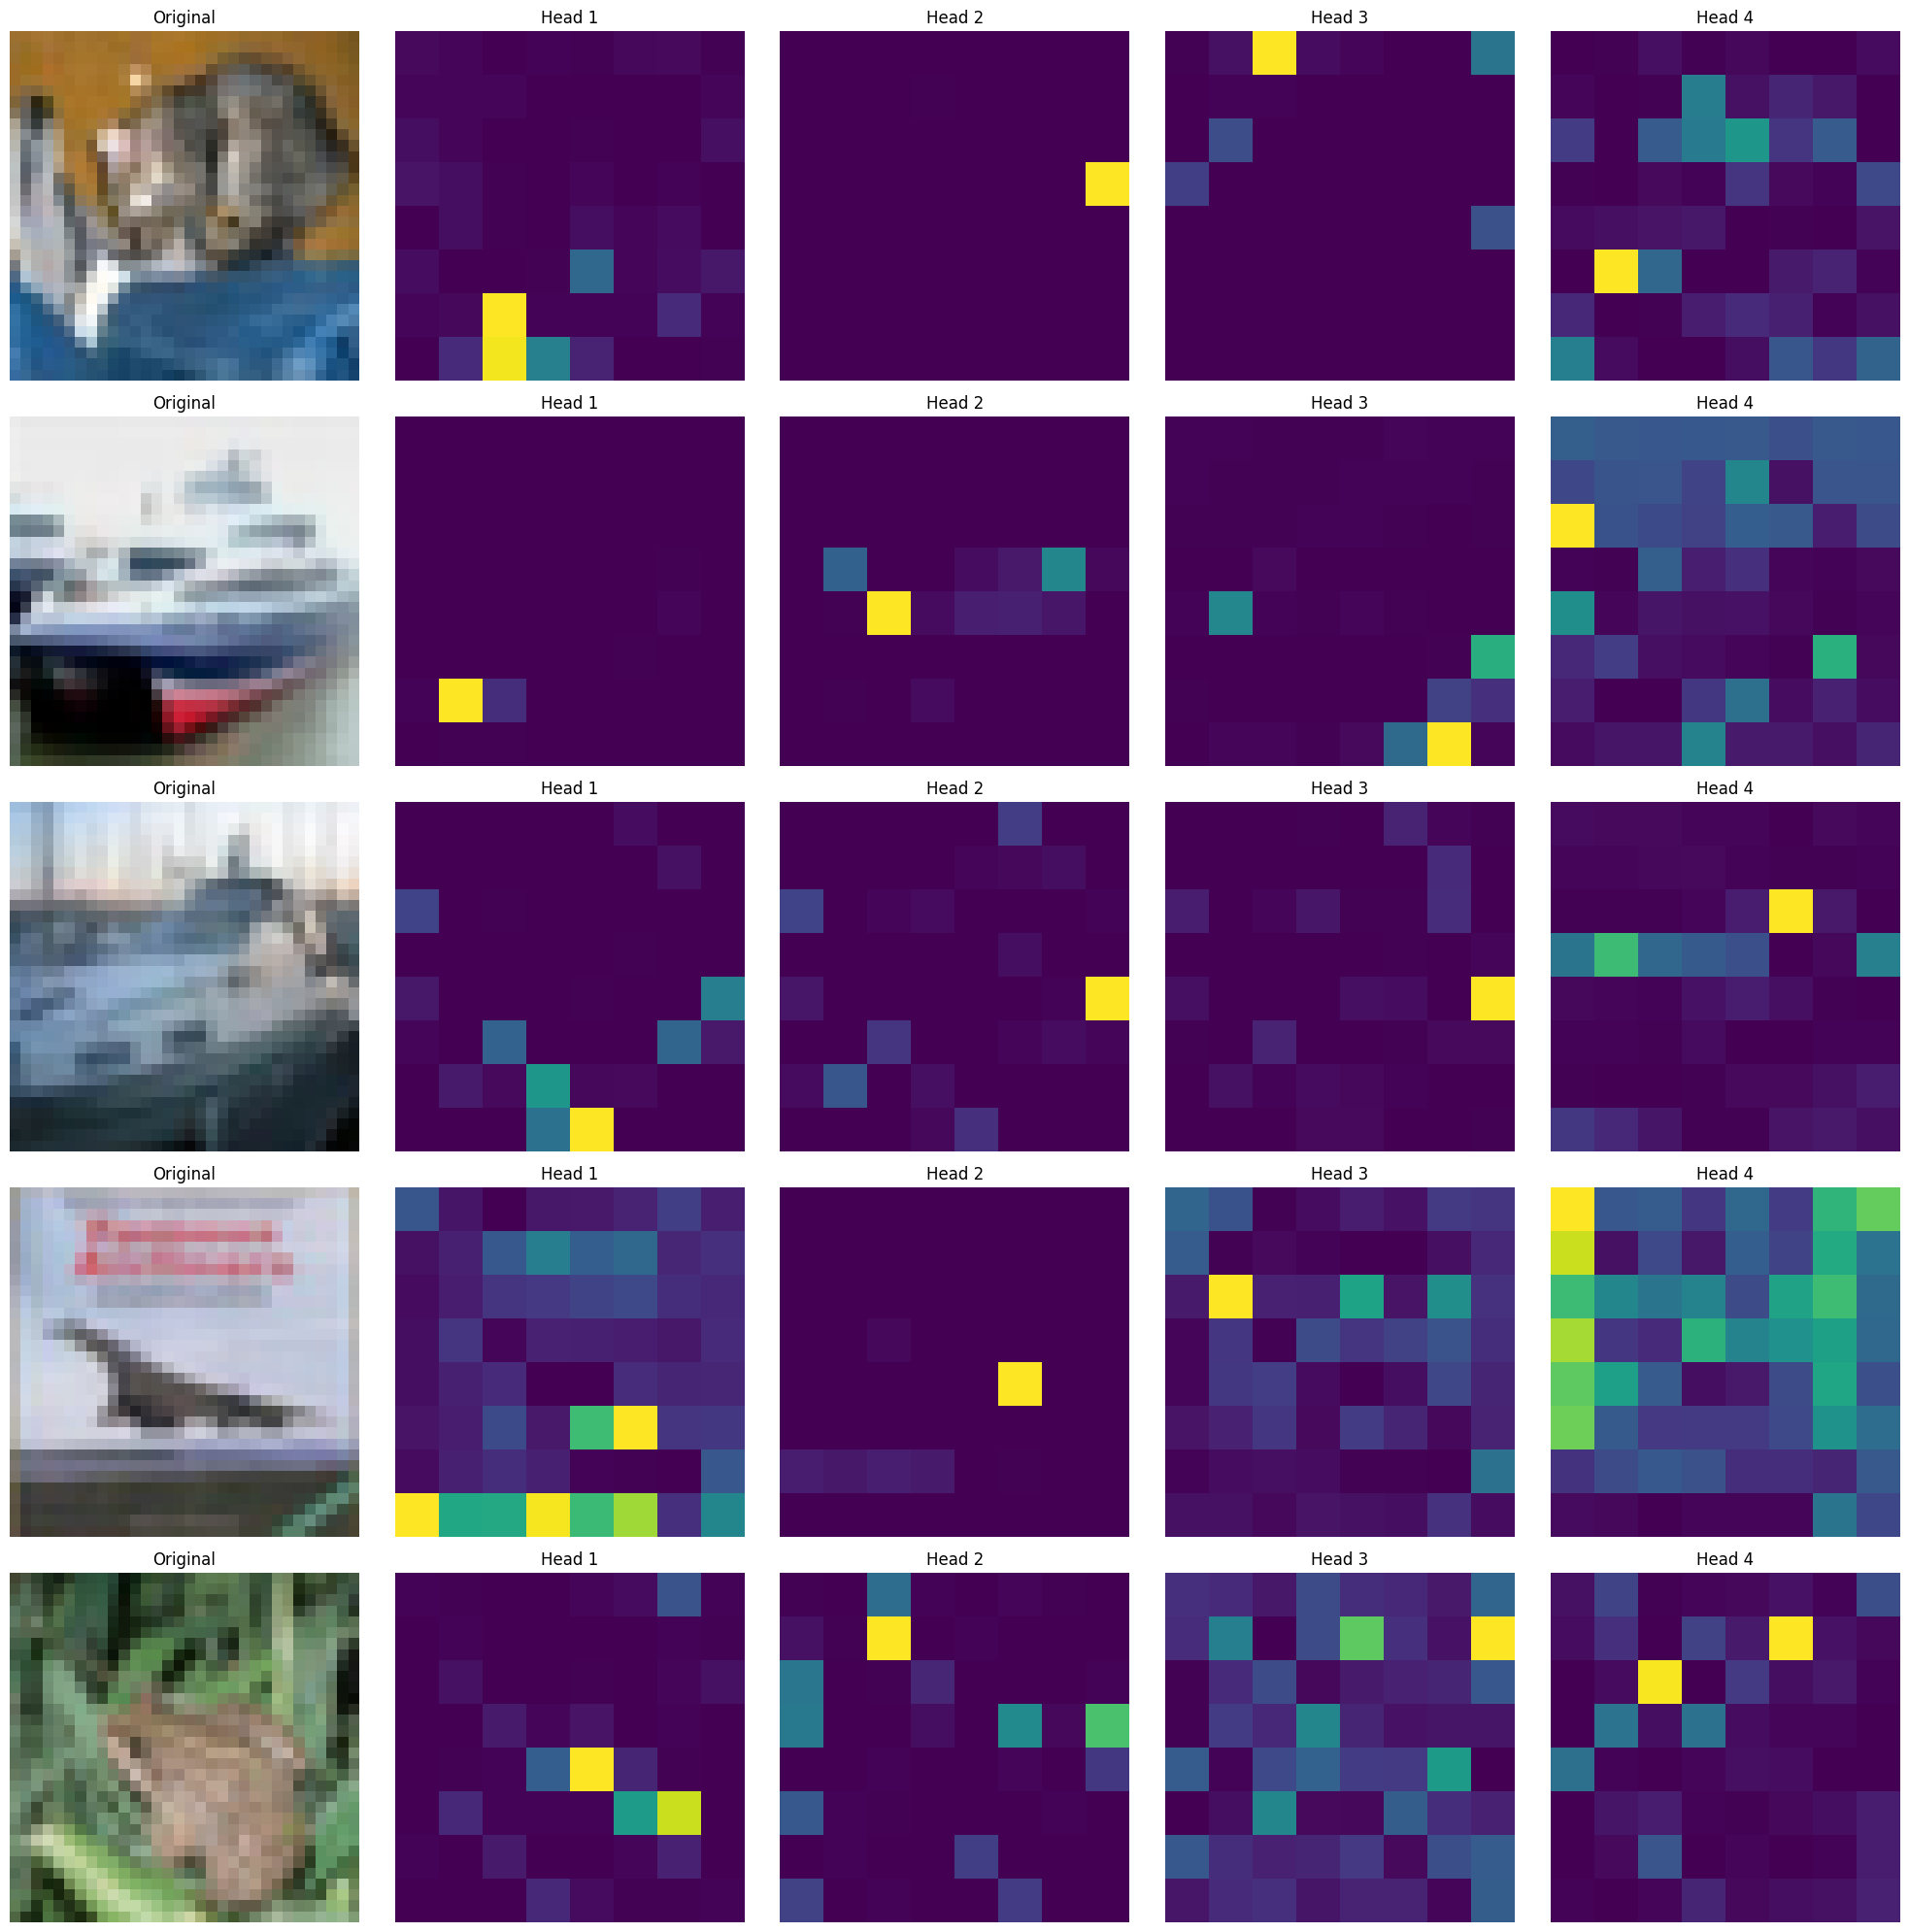

Experiment completed in 16.93 minutes

Running experiment with positional embedding: 1d
Model parameters: 12,681,738
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: pos_embedding_1d


Training: 100%|██████████| 352/352 [00:48<00:00,  7.33it/s, loss=1.79, acc=33.8]


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.7851, Train Acc: 33.80%, Val Loss: 1.5842, Val Acc: 41.76%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.46, acc=46.6]


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.4606, Train Acc: 46.57%, Val Loss: 1.3379, Val Acc: 51.34%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.35, acc=50.8]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.3459, Train Acc: 50.83%, Val Loss: 1.2921, Val Acc: 53.20%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.27, acc=53.9]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.2682, Train Acc: 53.89%, Val Loss: 1.2731, Val Acc: 53.04%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.22, acc=55.7]


  Validation loss improved. Saving model.
Epoch 5/25: Train Loss: 1.2236, Train Acc: 55.74%, Val Loss: 1.2684, Val Acc: 53.68%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.17, acc=57.6]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.1727, Train Acc: 57.58%, Val Loss: 1.2040, Val Acc: 56.46%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.13, acc=59.4]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.1270, Train Acc: 59.41%, Val Loss: 1.1489, Val Acc: 58.94%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.08, acc=60.8]


  Validation loss improved. Saving model.
Epoch 8/25: Train Loss: 1.0841, Train Acc: 60.82%, Val Loss: 1.1444, Val Acc: 59.60%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.04, acc=62.2]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 1.0445, Train Acc: 62.22%, Val Loss: 1.1241, Val Acc: 59.22%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1, acc=63.7]    


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 1.0029, Train Acc: 63.67%, Val Loss: 1.0624, Val Acc: 61.92%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.961, acc=65.4]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 0.9614, Train Acc: 65.44%, Val Loss: 1.0576, Val Acc: 62.22%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.919, acc=67.1]


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 0.9194, Train Acc: 67.11%, Val Loss: 1.0242, Val Acc: 63.80%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.868, acc=68.7]


  No improvement in val loss for 1 epochs.
Epoch 13/25: Train Loss: 0.8677, Train Acc: 68.67%, Val Loss: 1.0414, Val Acc: 62.74%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.829, acc=70.1]


  Validation loss improved. Saving model.
Epoch 14/25: Train Loss: 0.8290, Train Acc: 70.10%, Val Loss: 1.0044, Val Acc: 64.70%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.774, acc=72.1]


  No improvement in val loss for 1 epochs.
Epoch 15/25: Train Loss: 0.7738, Train Acc: 72.10%, Val Loss: 1.0682, Val Acc: 62.86%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.718, acc=74.3]


  No improvement in val loss for 2 epochs.
Epoch 16/25: Train Loss: 0.7184, Train Acc: 74.31%, Val Loss: 1.0546, Val Acc: 64.28%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.662, acc=76]  


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0120, Test Acc: 64.02%


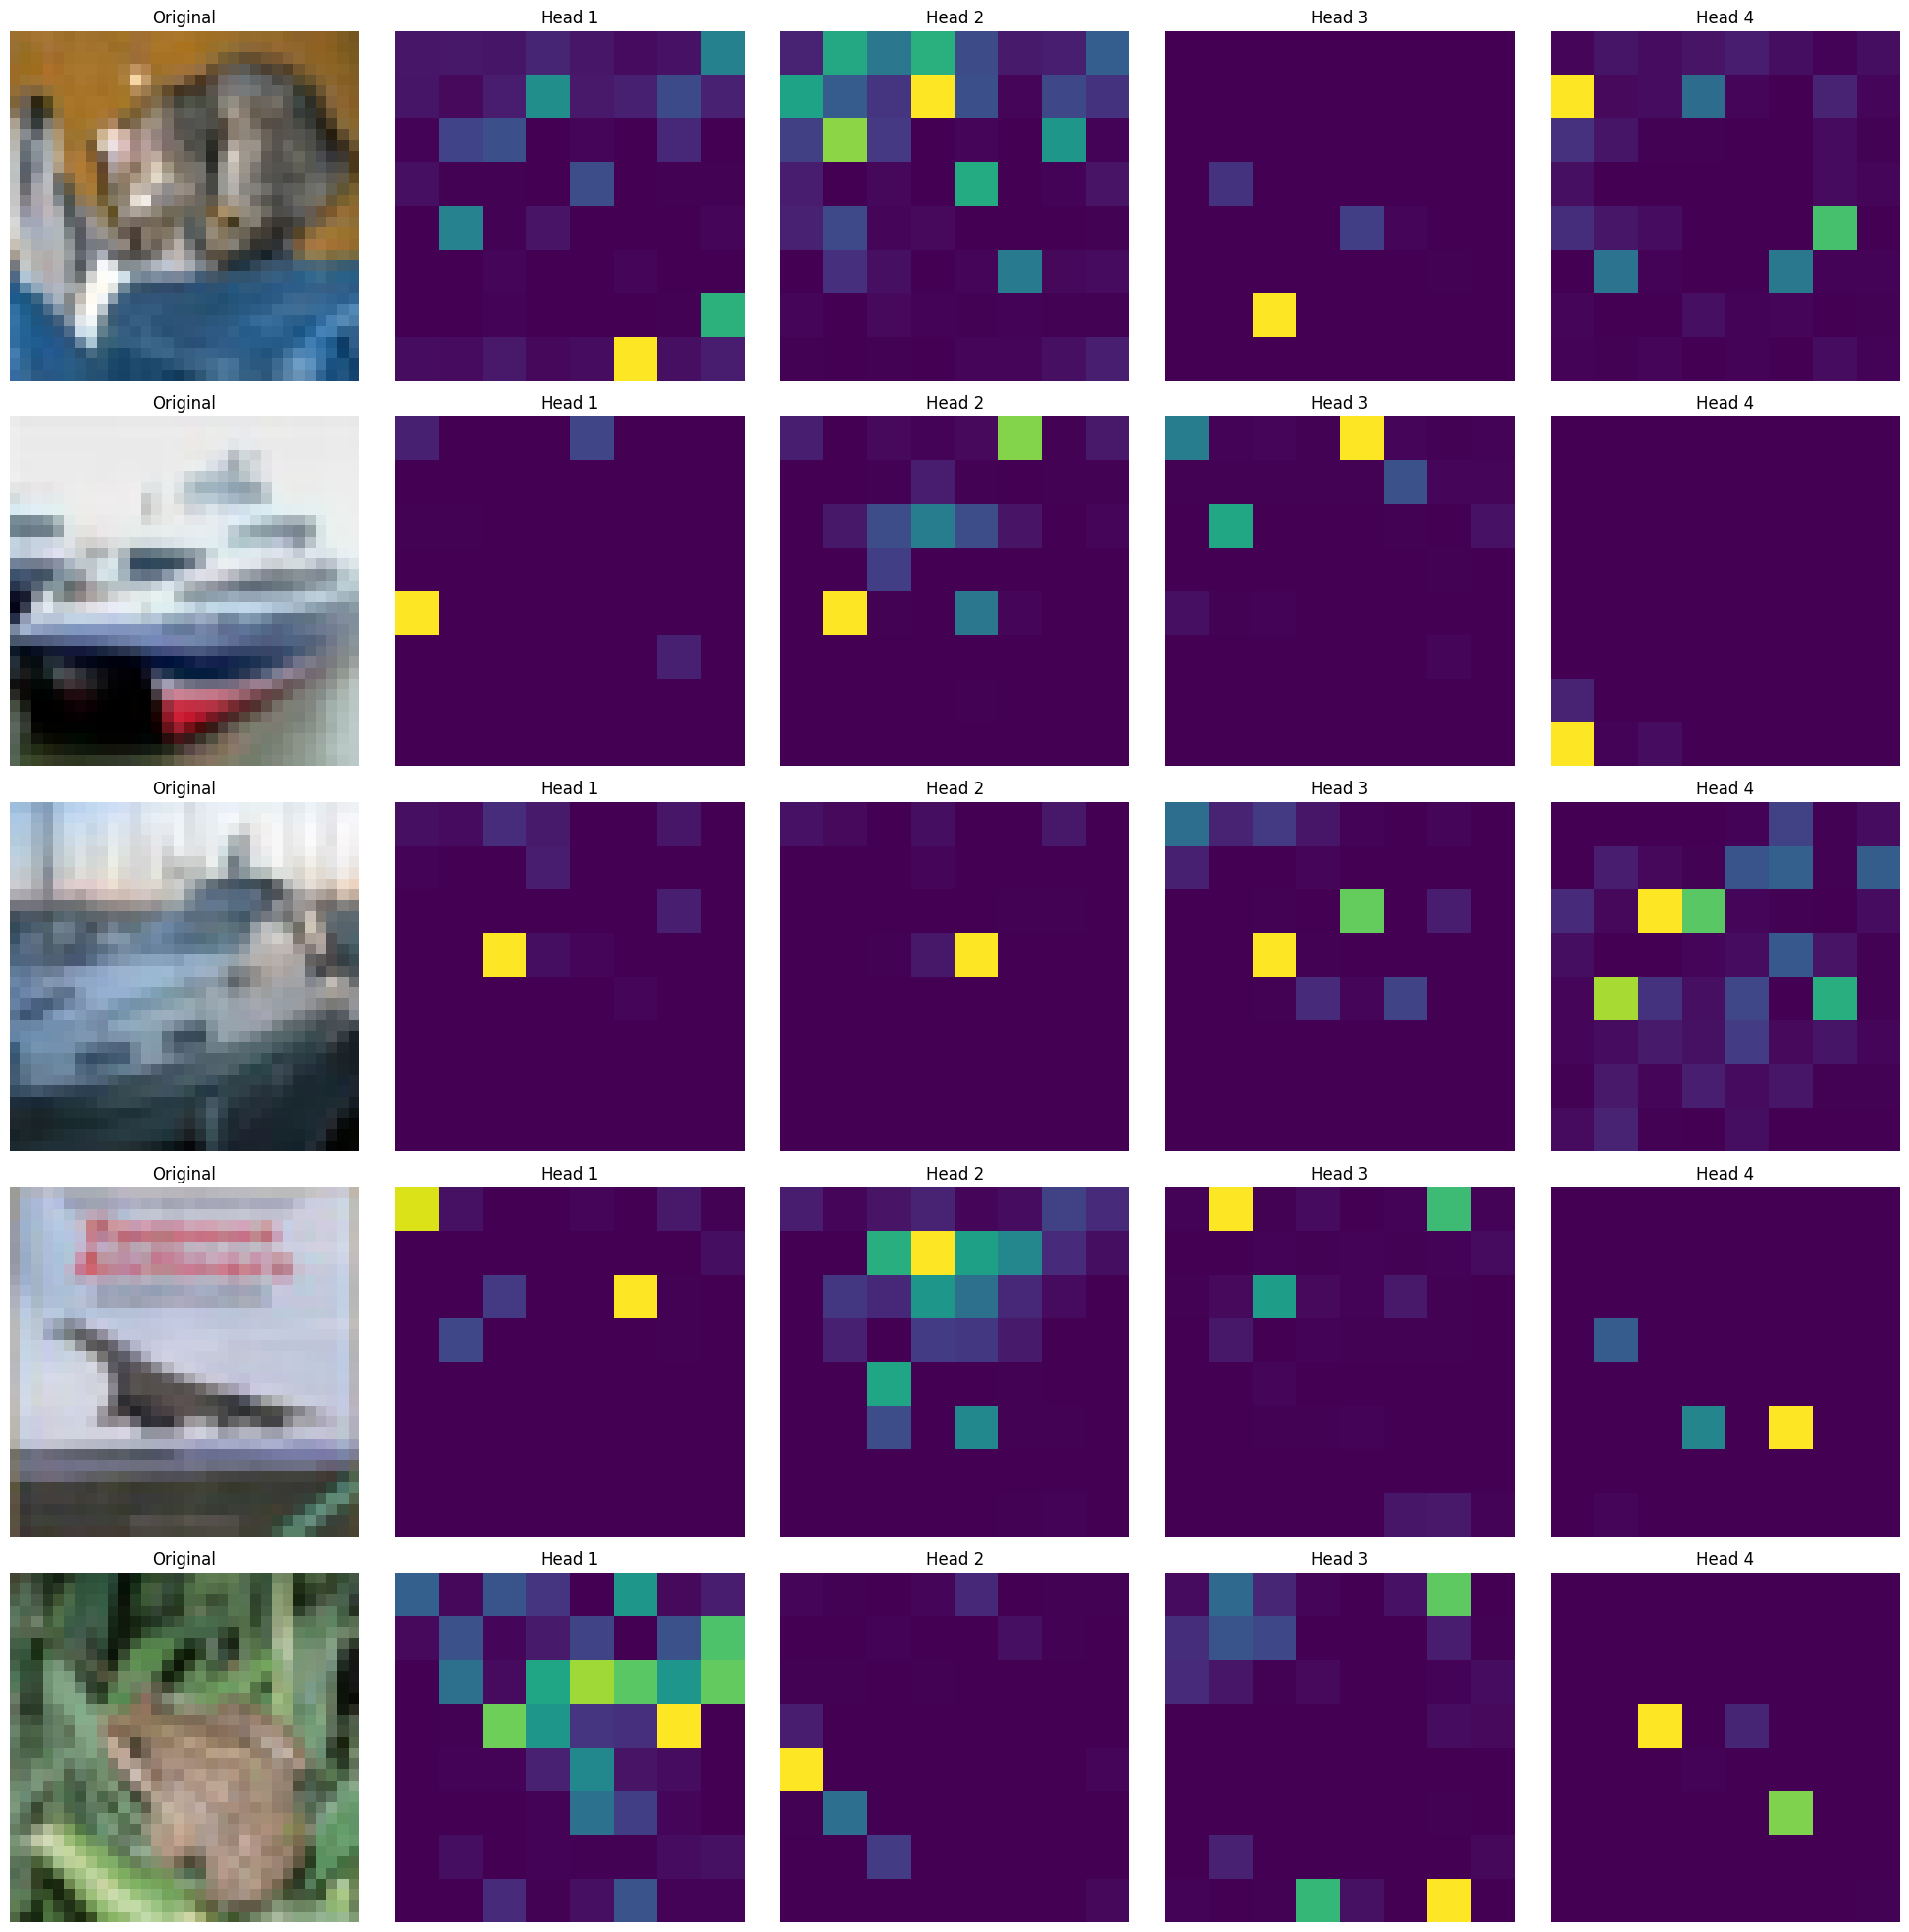

Experiment completed in 14.28 minutes

Running experiment with positional embedding: 2d
Model parameters: 12,657,162
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: pos_embedding_2d


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.84, acc=33.5]


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.8356, Train Acc: 33.51%, Val Loss: 1.5869, Val Acc: 42.52%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.52, acc=45.3]


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.5213, Train Acc: 45.28%, Val Loss: 1.4628, Val Acc: 47.62%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.43, acc=48.7]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.4285, Train Acc: 48.74%, Val Loss: 1.3758, Val Acc: 51.18%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.36, acc=51.4]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.3561, Train Acc: 51.36%, Val Loss: 1.3052, Val Acc: 53.10%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.29, acc=53.8]


  Validation loss improved. Saving model.
Epoch 5/25: Train Loss: 1.2862, Train Acc: 53.80%, Val Loss: 1.3019, Val Acc: 54.14%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.24, acc=55.5]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.2361, Train Acc: 55.47%, Val Loss: 1.2456, Val Acc: 55.44%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.18, acc=57.4]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.1847, Train Acc: 57.41%, Val Loss: 1.1784, Val Acc: 57.74%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.13, acc=59.5]


  Validation loss improved. Saving model.
Epoch 8/25: Train Loss: 1.1341, Train Acc: 59.46%, Val Loss: 1.1597, Val Acc: 58.56%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s, loss=1.08, acc=61.4]


  Validation loss improved. Saving model.
Epoch 9/25: Train Loss: 1.0784, Train Acc: 61.42%, Val Loss: 1.1203, Val Acc: 60.42%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=1.04, acc=62.8]


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 1.0352, Train Acc: 62.84%, Val Loss: 1.1141, Val Acc: 60.96%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=0.985, acc=65]  


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 0.9849, Train Acc: 65.00%, Val Loss: 1.0875, Val Acc: 62.46%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=0.93, acc=66.8] 


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 0.9302, Train Acc: 66.76%, Val Loss: 1.0750, Val Acc: 63.14%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=0.88, acc=68.4] 


  No improvement in val loss for 1 epochs.
Epoch 13/25: Train Loss: 0.8802, Train Acc: 68.37%, Val Loss: 1.0888, Val Acc: 62.86%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=0.821, acc=70.5]


  No improvement in val loss for 2 epochs.
Epoch 14/25: Train Loss: 0.8211, Train Acc: 70.51%, Val Loss: 1.0754, Val Acc: 64.46%


Training: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s, loss=0.772, acc=72.3]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0788, Test Acc: 62.28%


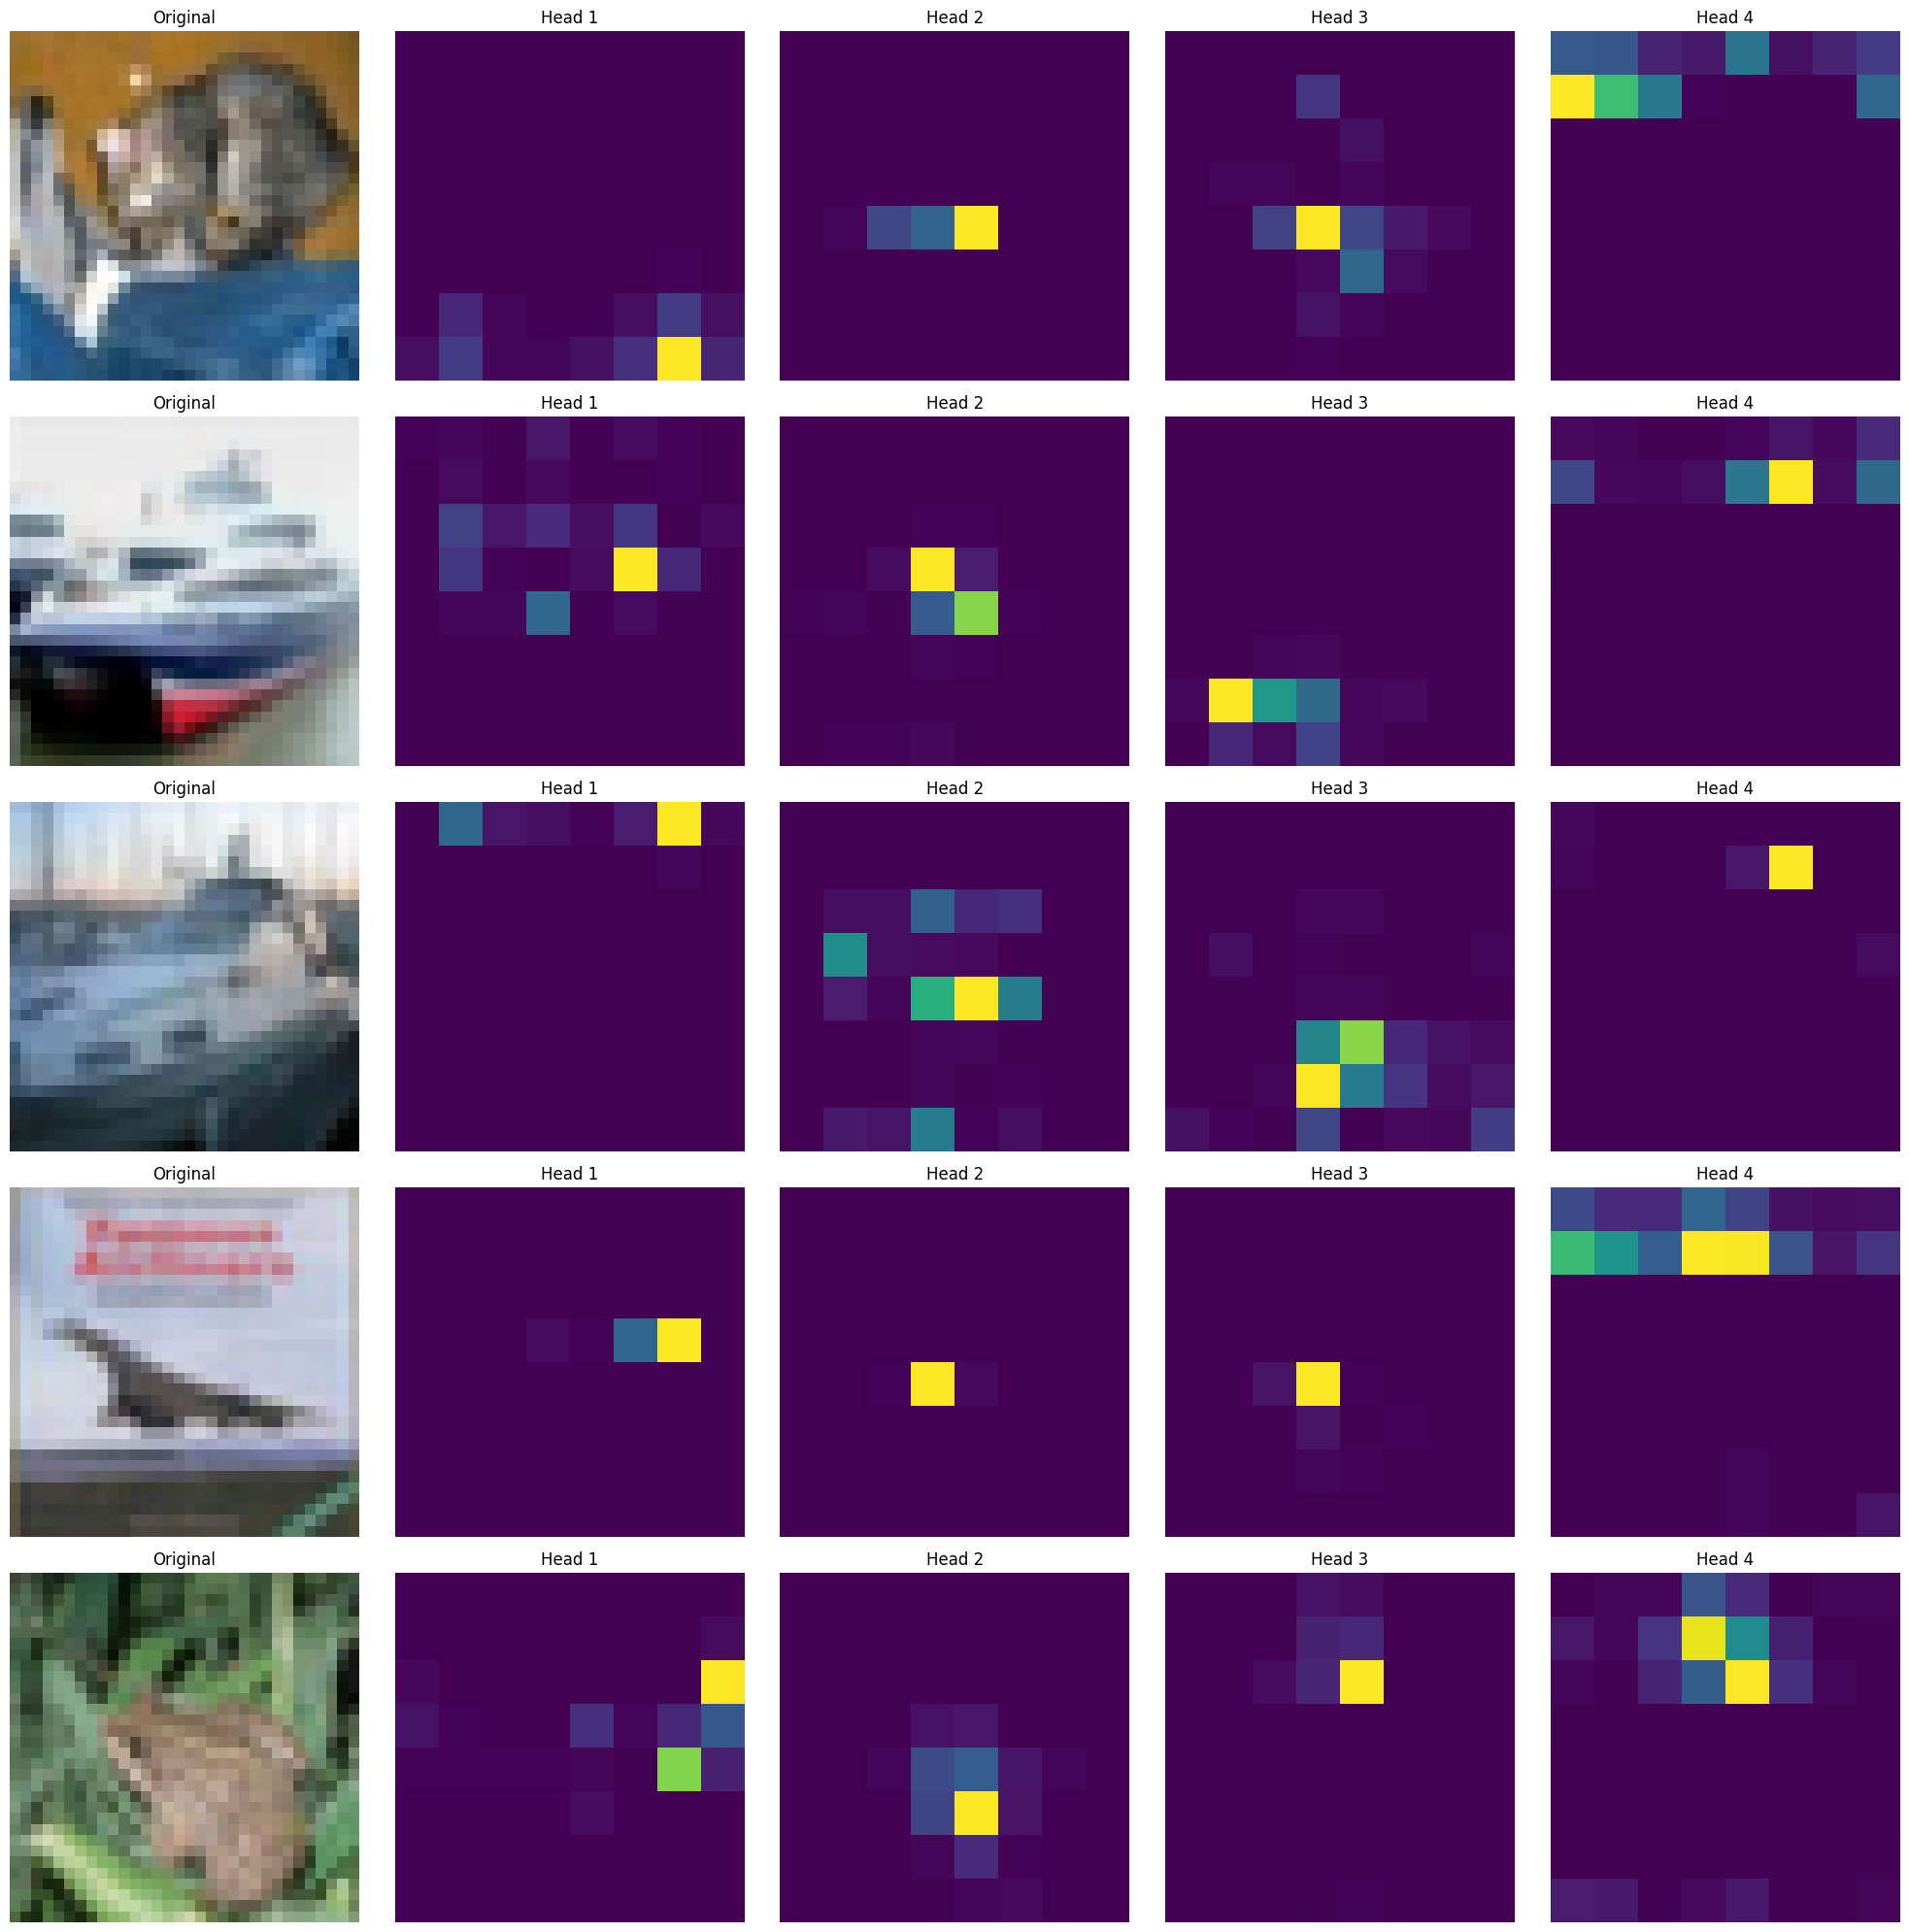

Experiment completed in 12.69 minutes

Running experiment with positional embedding: sinusoidal
Model parameters: 12,648,458
Files already downloaded and verified
Files already downloaded and verified
Starting experiment: pos_embedding_sinusoidal


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.89, acc=30.4]


  Validation loss improved. Saving model.
Epoch 1/25: Train Loss: 1.8926, Train Acc: 30.39%, Val Loss: 1.6301, Val Acc: 39.30%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.53, acc=44.8]


  Validation loss improved. Saving model.
Epoch 2/25: Train Loss: 1.5255, Train Acc: 44.77%, Val Loss: 1.4275, Val Acc: 48.64%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.42, acc=48.6]


  Validation loss improved. Saving model.
Epoch 3/25: Train Loss: 1.4242, Train Acc: 48.60%, Val Loss: 1.4255, Val Acc: 48.54%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.36, acc=51.3]


  Validation loss improved. Saving model.
Epoch 4/25: Train Loss: 1.3570, Train Acc: 51.32%, Val Loss: 1.3016, Val Acc: 52.28%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.29, acc=53.8]


  Validation loss improved. Saving model.
Epoch 5/25: Train Loss: 1.2861, Train Acc: 53.78%, Val Loss: 1.2306, Val Acc: 55.78%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.23, acc=55.6]


  Validation loss improved. Saving model.
Epoch 6/25: Train Loss: 1.2327, Train Acc: 55.59%, Val Loss: 1.2071, Val Acc: 56.58%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.18, acc=57.6]


  Validation loss improved. Saving model.
Epoch 7/25: Train Loss: 1.1830, Train Acc: 57.64%, Val Loss: 1.1730, Val Acc: 58.52%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.14, acc=59.3]


  Validation loss improved. Saving model.
Epoch 8/25: Train Loss: 1.1360, Train Acc: 59.35%, Val Loss: 1.1620, Val Acc: 57.80%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=1.08, acc=61.1]


  No improvement in val loss for 1 epochs.
Epoch 9/25: Train Loss: 1.0840, Train Acc: 61.11%, Val Loss: 1.1629, Val Acc: 58.18%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.35it/s, loss=1.04, acc=62.7]


  Validation loss improved. Saving model.
Epoch 10/25: Train Loss: 1.0407, Train Acc: 62.74%, Val Loss: 1.1138, Val Acc: 59.84%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.993, acc=64.5]


  Validation loss improved. Saving model.
Epoch 11/25: Train Loss: 0.9928, Train Acc: 64.54%, Val Loss: 1.1113, Val Acc: 60.76%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.947, acc=66.2]


  Validation loss improved. Saving model.
Epoch 12/25: Train Loss: 0.9466, Train Acc: 66.21%, Val Loss: 1.0939, Val Acc: 61.62%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.887, acc=68.4]


  Validation loss improved. Saving model.
Epoch 13/25: Train Loss: 0.8869, Train Acc: 68.38%, Val Loss: 1.0676, Val Acc: 62.58%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.831, acc=70.4]


  Validation loss improved. Saving model.
Epoch 14/25: Train Loss: 0.8314, Train Acc: 70.37%, Val Loss: 1.0577, Val Acc: 62.92%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.776, acc=72.1]


  No improvement in val loss for 1 epochs.
Epoch 15/25: Train Loss: 0.7758, Train Acc: 72.09%, Val Loss: 1.0714, Val Acc: 64.18%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.717, acc=74.4]


  No improvement in val loss for 2 epochs.
Epoch 16/25: Train Loss: 0.7169, Train Acc: 74.40%, Val Loss: 1.0632, Val Acc: 64.48%


Training: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s, loss=0.661, acc=76.6]


  No improvement in val loss for 3 epochs.
  Early stopping triggered.
Test Loss: 1.0695, Test Acc: 62.77%


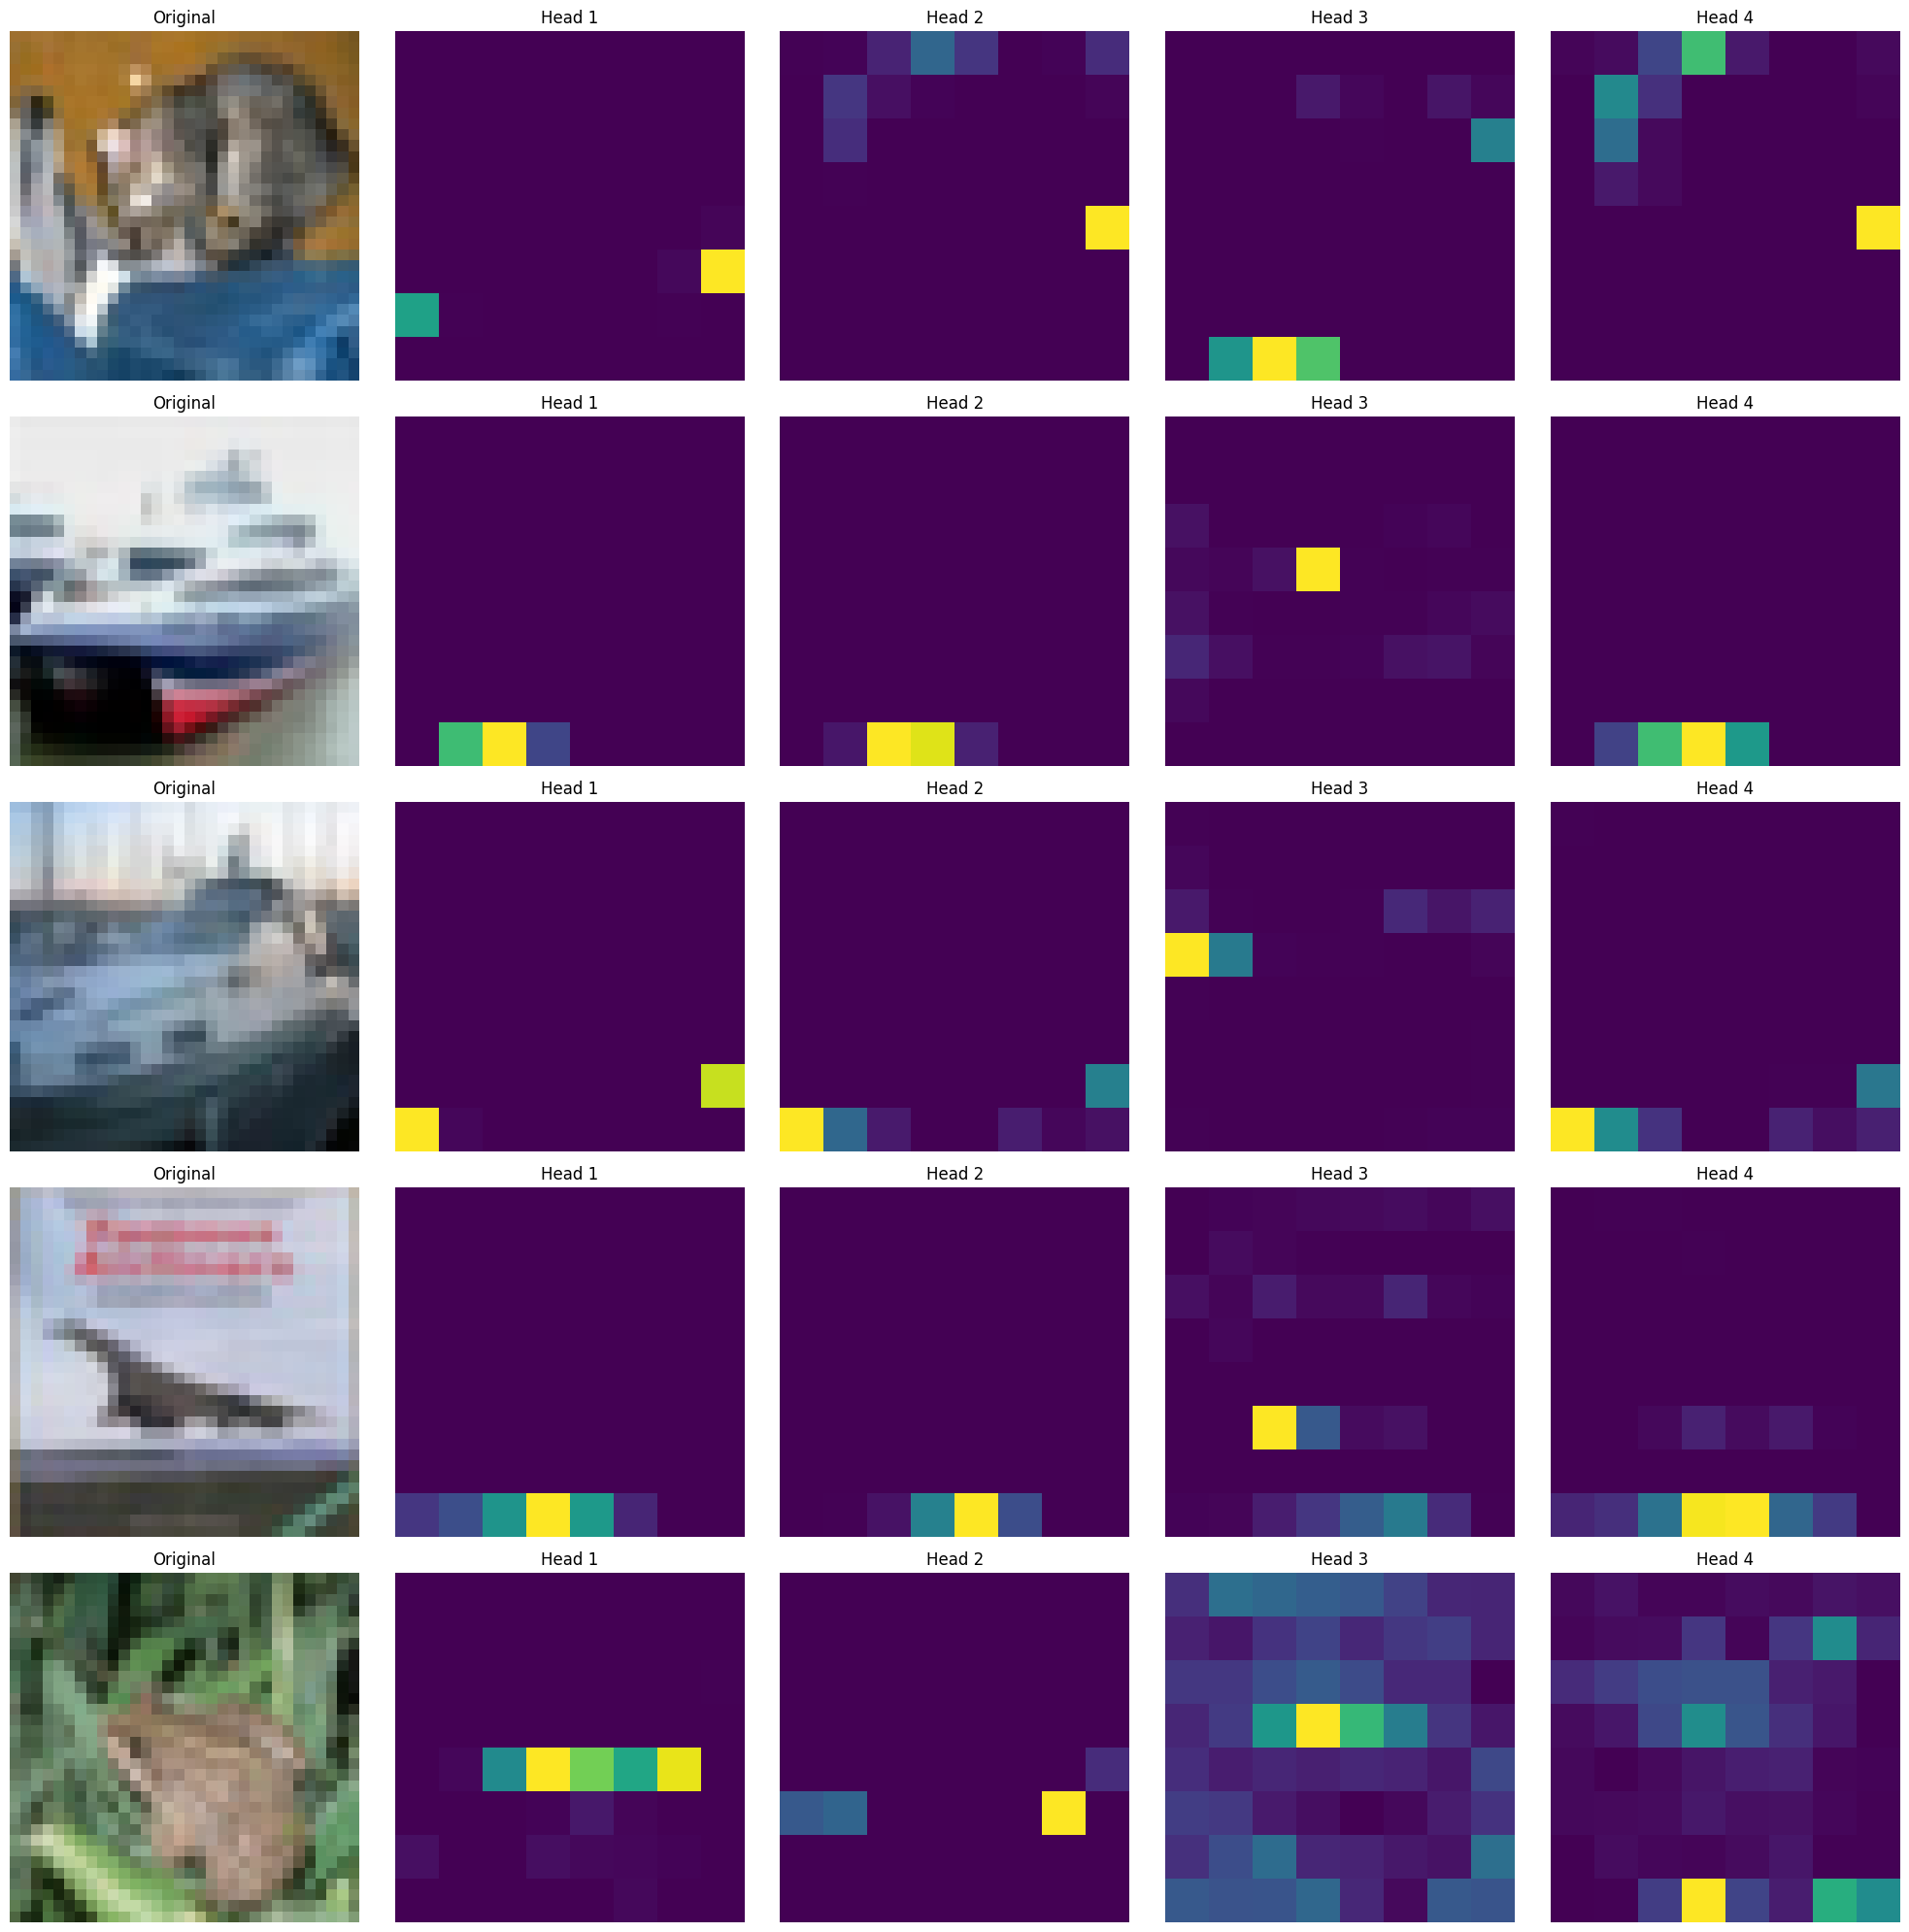

Experiment completed in 14.28 minutes


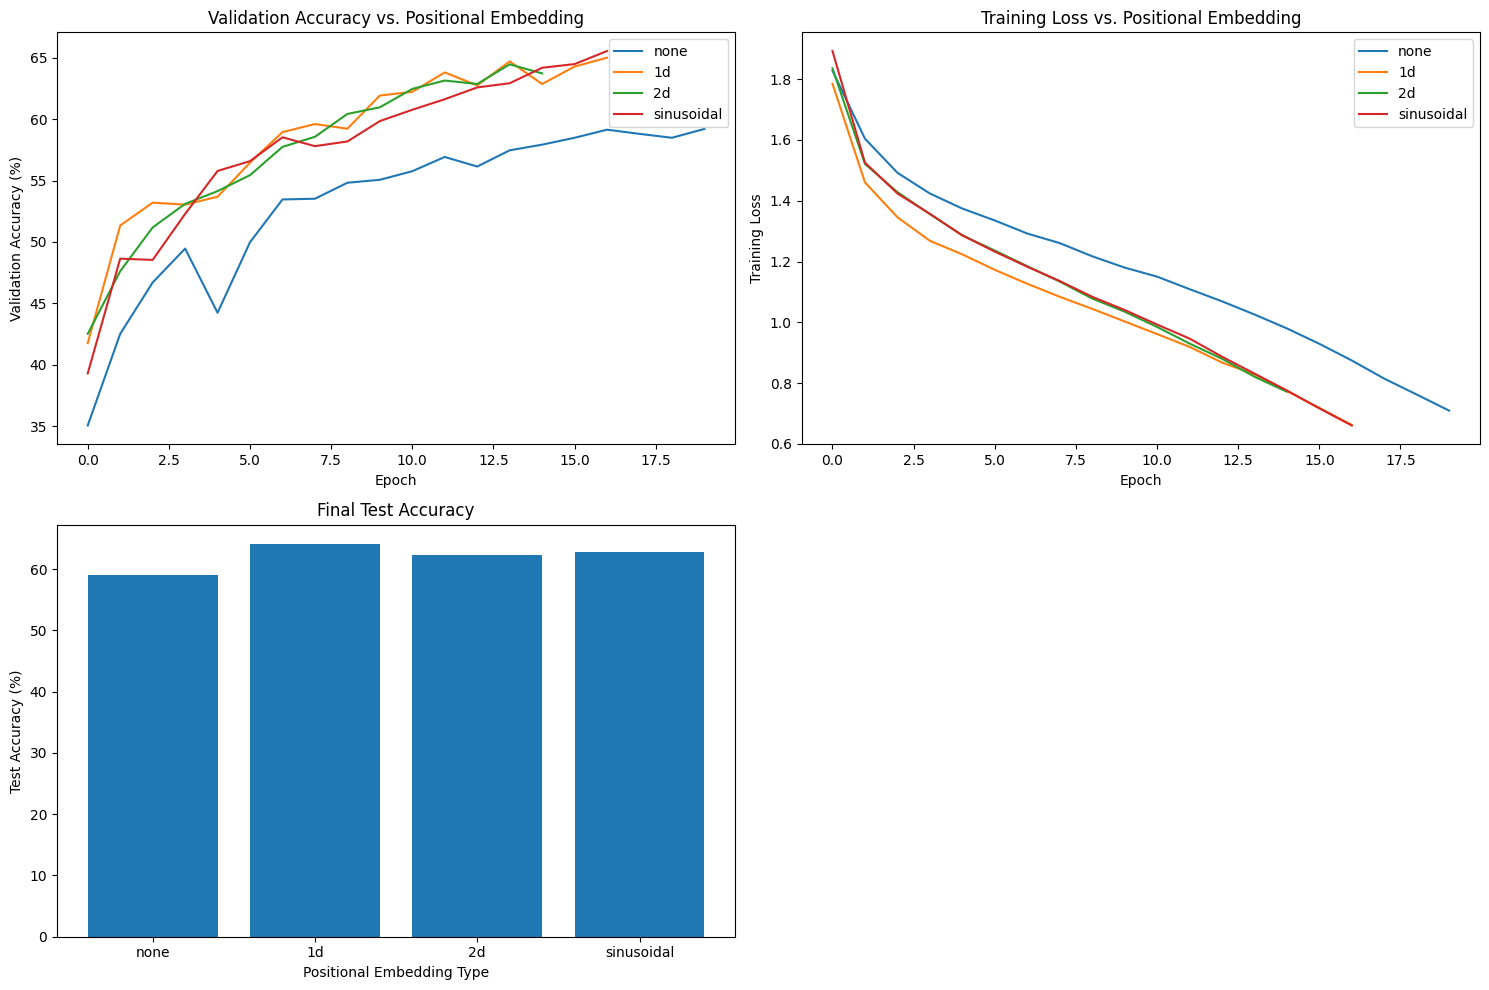


Best positional embedding type: 1d
Test accuracy: 64.02%


In [ ]:
print("\n" + "="*80)
print("EXPERIMENT 4: POSITIONAL EMBEDDINGS")
print("="*80)
# Configure for best performance based on previous experiments
best_config.pos_embedding_type = "1d"  # Start with default
best_config.num_hidden_layers = 12
best_config.num_attention_heads = 8

pos_embedding_results, best_emb = compare_position_embeddings(epochs=25, config=best_config)

#### We evaluated four types of positional embeddings using the best hyperparameters. Models with no positional embedding performed worst. The 1D learned embedding achieved the best test accuracy (~63%), followed closely by 2D learned and sinusoidal embeddings. All embeddings improved convergence and accuracy compared to none, highlighting the importance of positional information in ViTs.


## 1.4 Visualizations

#### DINO Attention Maps

##### PROMPT- Can you write a function that visualizes attention maps from a pre-trained DINO ViT model given an image URL? display the attention maps from the CLS token for each head , use the official visualization code from the DINO repository.

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


Running DINO Attention Map Visualization from URL...


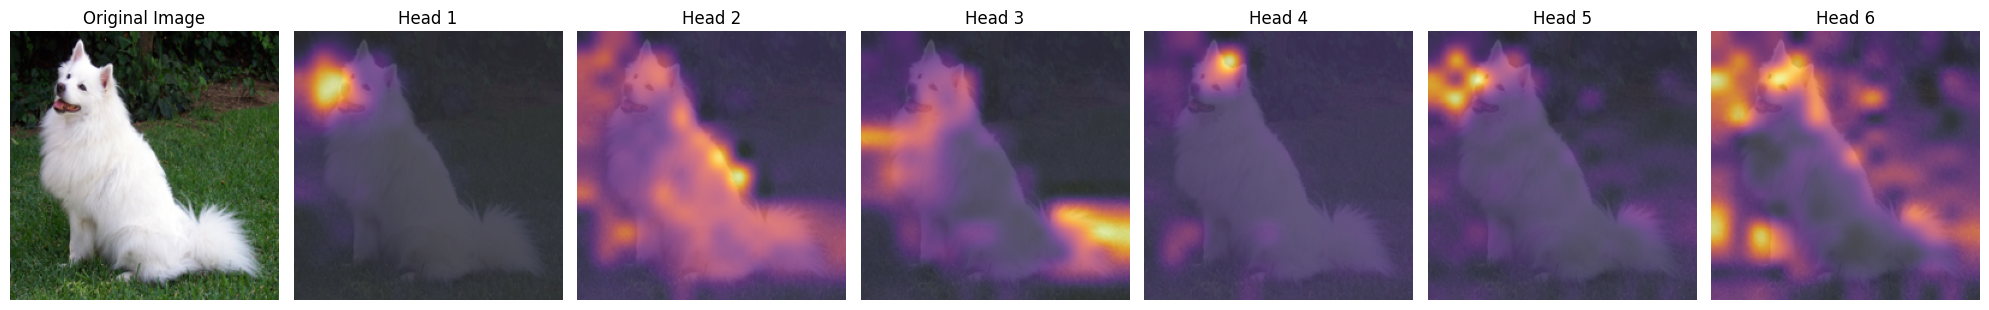

DINO attention maps saved to plots/dino_attention_maps.png


In [ ]:
# 1. Updated DINO Attention Maps Visualization
def visualize_dino_attention_from_url(model, img_url, device, save_path=None):
    """
    Visualize attention maps from DINO model for a given image URL.

    Args:
        model: Pre-trained DINO ViT model
        img_url: URL to input image
        device: Computation device (CPU/GPU)
        save_path: Path to save visualizations
    """
    # Download image from URL
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content)).convert('RGB')

    # Preprocess image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)
    img_display = img.resize((224, 224))

    # Get attention maps
    model.eval()
    with torch.no_grad():
        # Check the model's API and adapt accordingly
        # Method 1: If get_intermediate_layers accepts return_attn
        try:
            outputs = model.get_intermediate_layers(img_tensor, n=1, return_attn=True)
            attentions = outputs[1][0]  # [num_heads, patches, patches]
        except TypeError:
            # Method 2: If get_intermediate_layers doesn't accept return_attn
            try:
                # Some versions require getting attention separately
                _ = model.get_intermediate_layers(img_tensor, n=1)
                # Access attention directly from the transformer blocks
                attentions = model.blocks[-1].attn.get_attention_map(img_tensor)
            except:
                # Method 3: Use forward hooks to capture attention
                attention_maps = []

                def hook_fn(module, input, output):
                    # Capture attention weights
                    if isinstance(output, tuple) and len(output) > 1:
                        attention_maps.append(output[1])

                hooks = []
                # Add hooks to the attention blocks
                for block in model.blocks:
                    hooks.append(block.attn.register_forward_hook(hook_fn))

                # Forward pass
                _ = model(img_tensor)

                # Remove hooks
                for hook in hooks:
                    hook.remove()

                # Get last layer's attention
                attentions = attention_maps[-1][0]  # Last layer, first batch

    # If attentions is still not available, use this fallback approach
    if 'attentions' not in locals() or attentions is None:
        # Direct method to extract attention for DINO ViT
        # This is a last resort using knowledge of DINO's architecture
        x = img_tensor
        B, C, H, W = x.shape

        # Run through patch embedding
        x = model.patch_embed(x)

        # Add class token
        cls_token = model.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add position embedding
        x = x + model.pos_embed

        # Apply dropout if present
        if hasattr(model, 'pos_drop'):
            x = model.pos_drop(x)

        # Run through all blocks except the last one
        for blk in model.blocks[:-1]:
            x = blk(x)

        # For the last block, manually extract attention
        last_block = model.blocks[-1]

        # Get queries, keys, values
        qkv = last_block.attn.qkv(x)
        qkv = last_block.attn.reshape_qkv(qkv)
        q, k, v = qkv.unbind(dim=2)

        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * last_block.attn.scale
        attn = attn.softmax(dim=-1)

        # Store attention weights
        attentions = attn

    # Get attention from CLS token to patches
    cls_attn = attentions[:, 0, 1:]  # [num_heads, num_patches]

    # Calculate grid dimensions
    img_size = 224  # Input image size after preprocessing
    num_patches_per_side = int(math.sqrt(cls_attn.shape[1]))

    # Plot
    fig, axes = plt.subplots(1, attentions.shape[0] + 1, figsize=(20, 4))

    # Display original image
    axes[0].imshow(img_display)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display attention maps
    for h in range(attentions.shape[0]):
        attn_map = cls_attn[h].reshape(num_patches_per_side, num_patches_per_side).cpu().numpy()

        # Upscale attention map to image size
        attn_map = Image.fromarray(attn_map).resize((224, 224), resample=Image.BICUBIC)
        attn_map = np.array(attn_map)

        # Display with a colormap
        axes[h+1].imshow(img_display, alpha=0.5)
        im = axes[h+1].imshow(attn_map, cmap='inferno', alpha=0.7)
        axes[h+1].set_title(f"Head {h+1}")
        axes[h+1].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

    return attentions.cpu().numpy()

# Runner function for URL
def run_dino_attention_visualization_from_url(dino_model, image_url):
    """Run DINO attention visualization task using an image URL"""
    print("Running DINO Attention Map Visualization from URL...")
    os.makedirs("plots", exist_ok=True)
    save_path = "plots/dino_attention_maps.png"
    visualize_dino_attention_from_url(dino_model, image_url, device, save_path)
    print(f"DINO attention maps saved to {save_path}")

dino_model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_model.to(device)

# Visualize attention for an image
run_dino_attention_visualization_from_url(
    dino_model,
    "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
)


## ViT CIFAR-10 Attention Maps:

Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_31/513865217.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

Files already downloaded and verified
Files already downloaded and verified


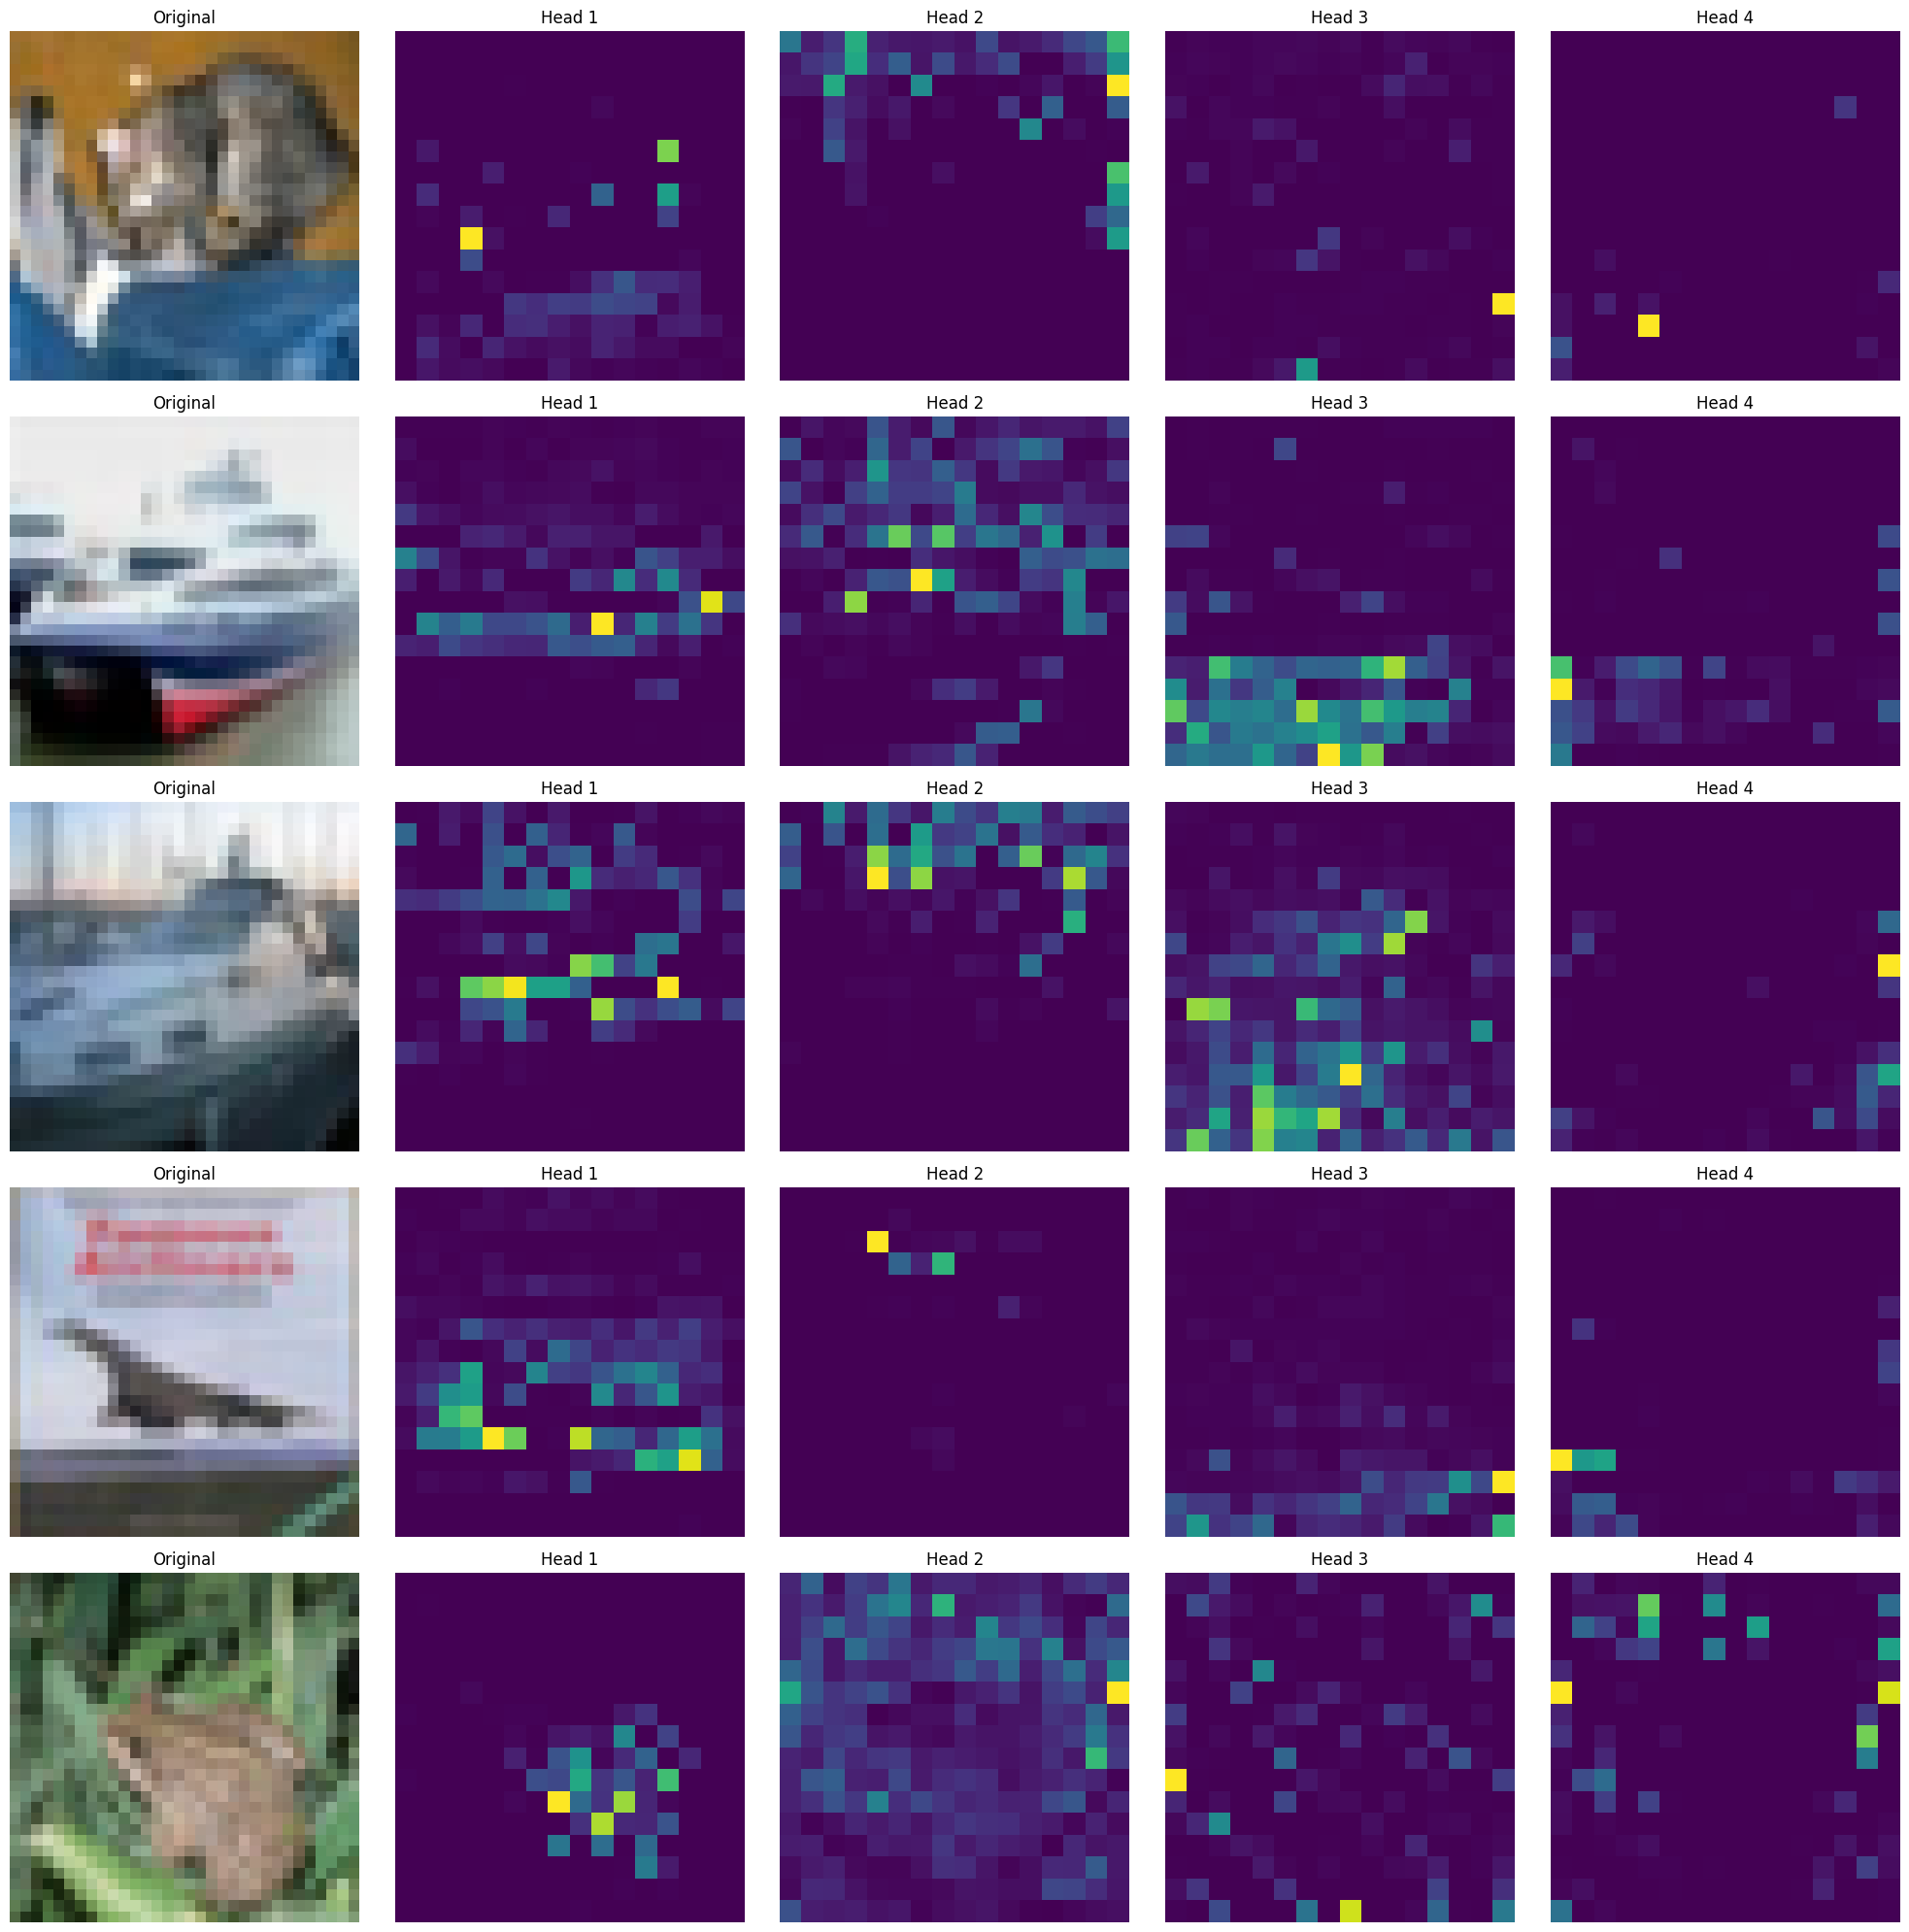

In [ ]:
base_config = ViTConfig(
    patch_size=2,
    hidden_size=384,
    num_attention_heads=4,
    num_hidden_layers=4,
    intermediate_size=384,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    pos_embedding_type="1d"
)

# Initialize model and load the matching state_dict
model = ViTForClassification(base_config).to(device)
state_dict = torch.load('/kaggle/working/models/patch_size_2_best.pth', map_location=device)
model.load_state_dict(state_dict)

# Visualize attention maps
# Get test data loader
_, _, test_loader = get_data_loaders(batch_size=64)
visualize_attention_maps(model, test_loader, num_images=5)


### Attention Rollout Visualization

Running Attention Rollout Visualization...
Attention weights type: <class 'list'>
Number of attention layers: 4
Shape of first layer attention: torch.Size([1, 4, 257, 257])
Attention matrix shape: torch.Size([1, 4, 257, 257])
Rollout shape: (1, 257, 257)
cls_rollout shape: (256,), length: 256
Expected patches: 256, num_patches_side: 16
Attention weights type: <class 'list'>
Number of attention layers: 4
Shape of first layer attention: torch.Size([1, 4, 257, 257])
Attention matrix shape: torch.Size([1, 4, 257, 257])
Rollout shape: (1, 257, 257)
cls_rollout shape: (256,), length: 256
Expected patches: 256, num_patches_side: 16
Attention weights type: <class 'list'>
Number of attention layers: 4
Shape of first layer attention: torch.Size([1, 4, 257, 257])
Attention matrix shape: torch.Size([1, 4, 257, 257])
Rollout shape: (1, 257, 257)
cls_rollout shape: (256,), length: 256
Expected patches: 256, num_patches_side: 16
Attention weights type: <class 'list'>
Number of attention layers: 4
Sha

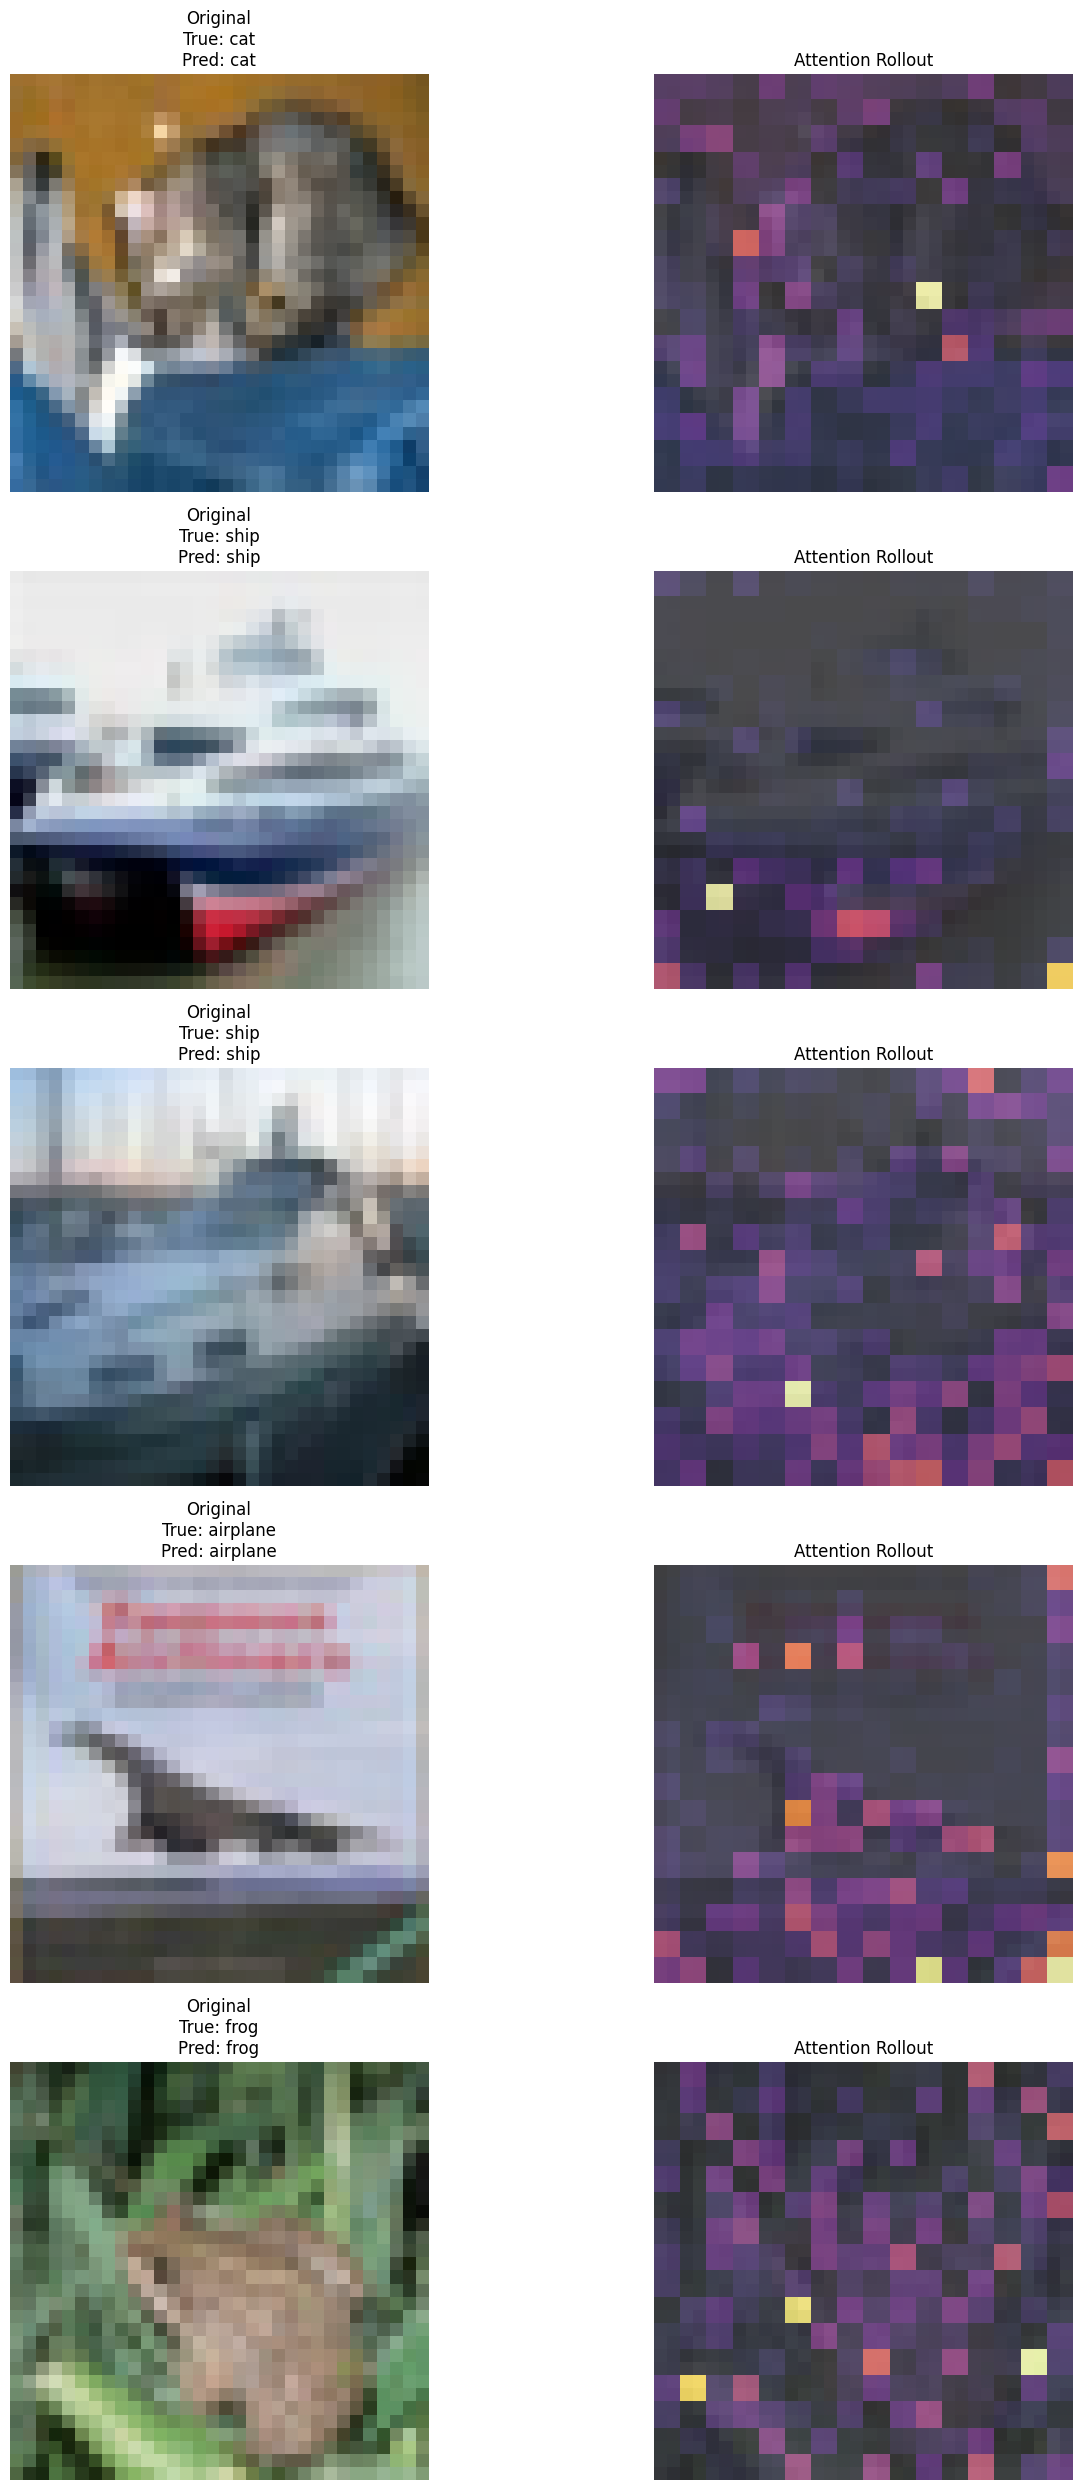

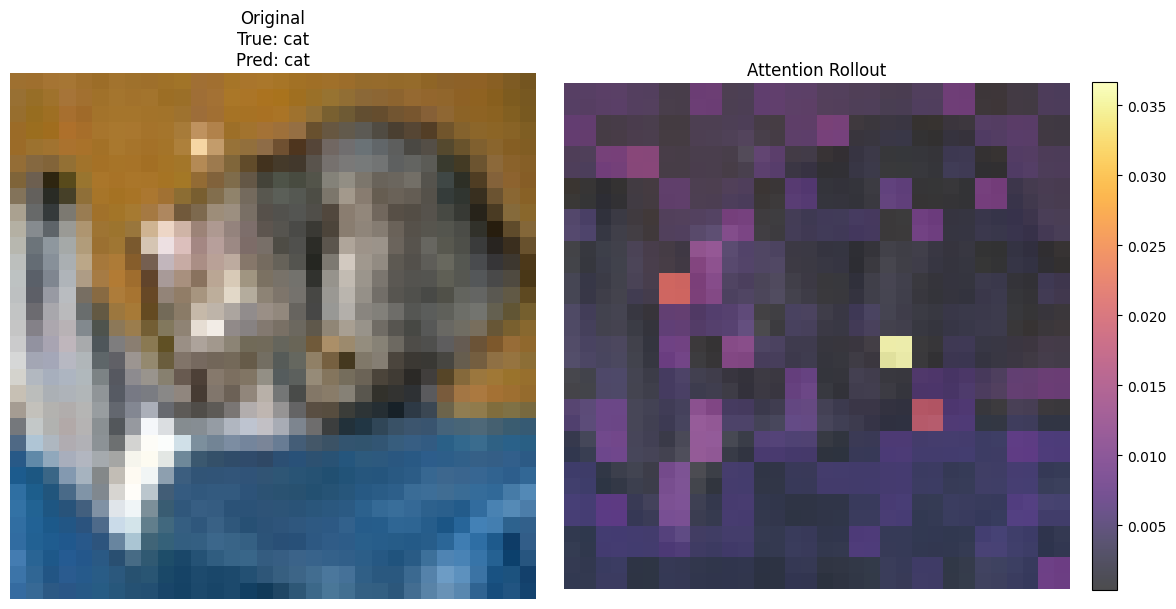

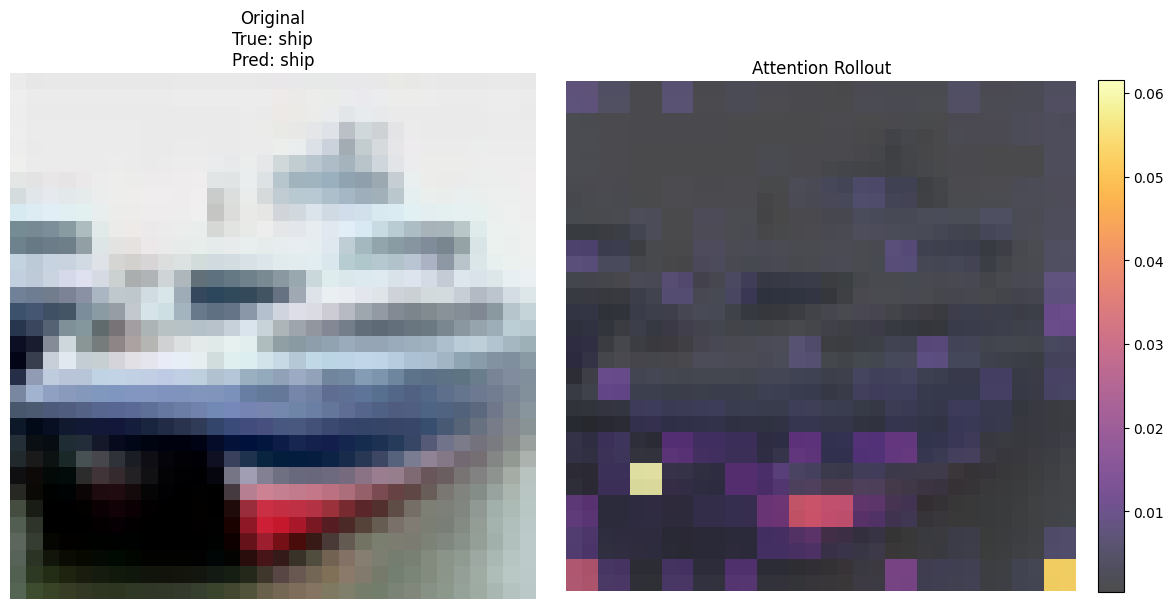

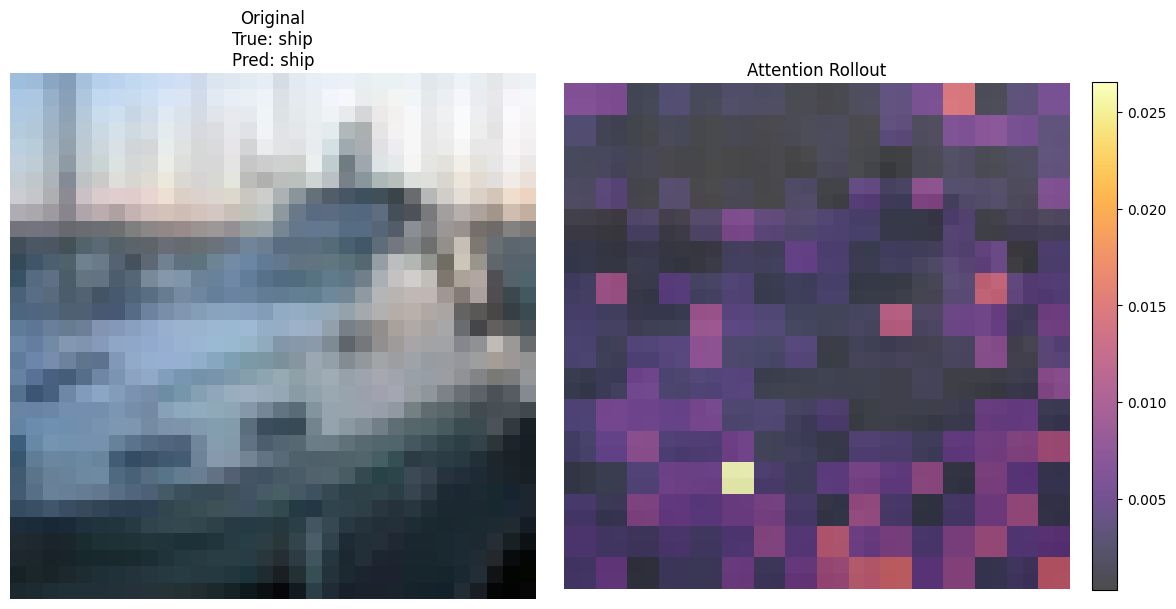

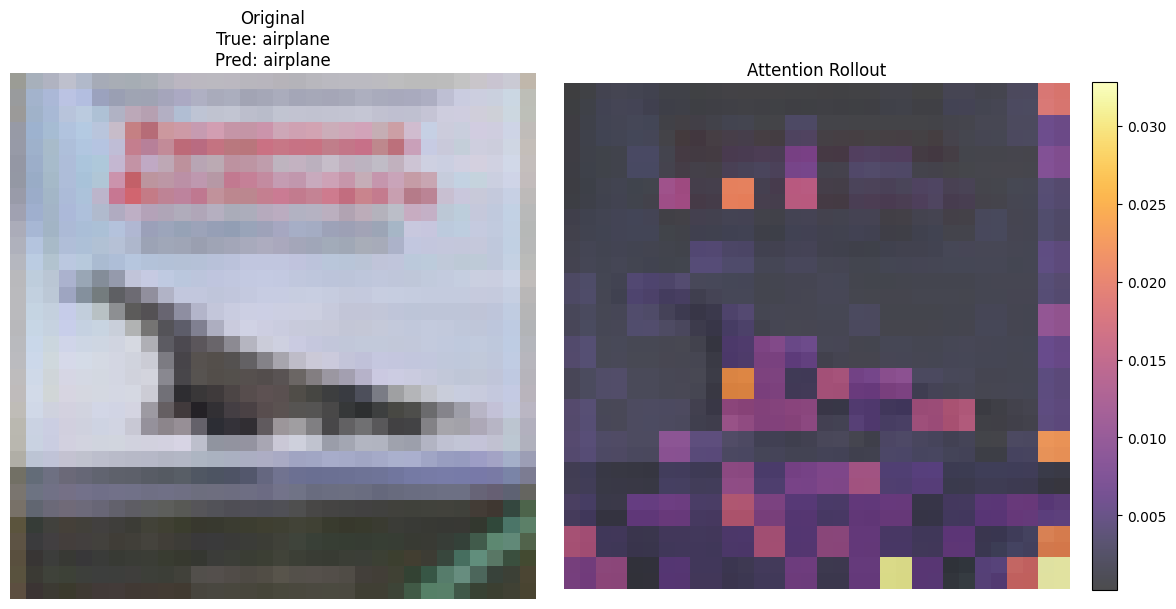

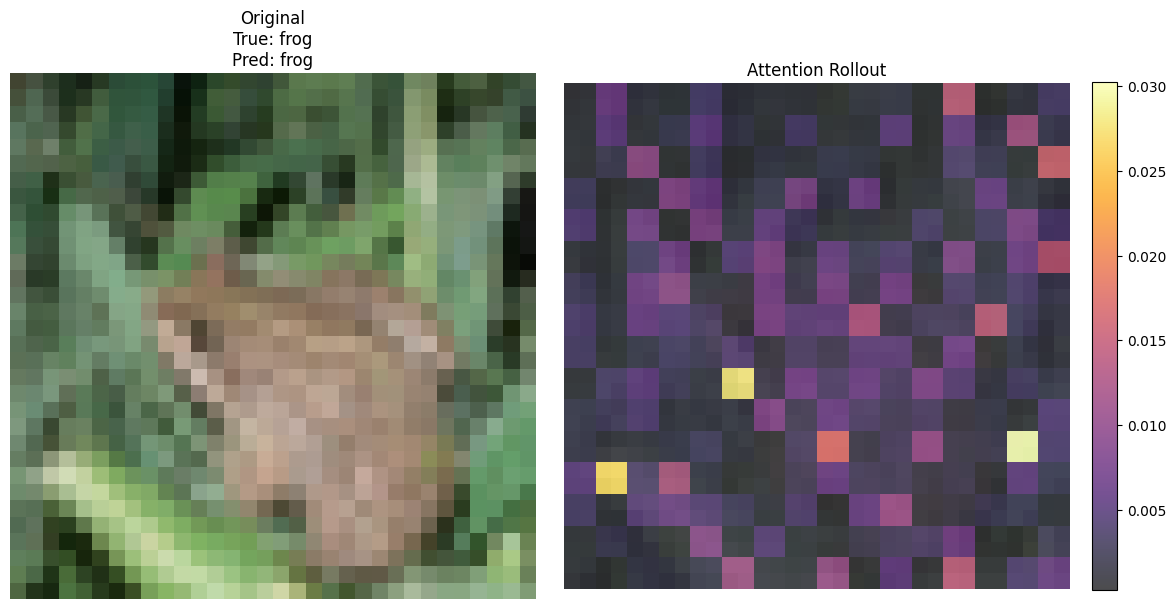

Attention rollout visualizations saved to plots/attention_rollout.png


In [ ]:
def compute_attention_rollout(attention_matrices):
    """
    Compute attention rollout from attention matrices.

    Args:
        attention_matrices: List of attention matrices from each layer

    Returns:
        rollout: Attention rollout matrix
    """
    # Extract dimensions
    num_layers = len(attention_matrices)

    # Check shape of attention matrices
    if len(attention_matrices[0].shape) == 5:  # [1, batch_size, num_heads, seq_len, seq_len]
        # Average attention weights across heads
        attention_matrices = [attn.mean(dim=2).squeeze(0) for attn in attention_matrices]
    else:
        # Handle case where attention matrices might have different shape
        print(f"Attention matrix shape: {attention_matrices[0].shape}")
        # Try to adapt to the actual shape
        if len(attention_matrices[0].shape) == 4:  # [batch_size, num_heads, seq_len, seq_len]
            attention_matrices = [attn.mean(dim=1) for attn in attention_matrices]

    # Get dimensions after processing
    batch_size, seq_len, _ = attention_matrices[0].shape

    # Initialize identity matrix for rollout computation
    eye = torch.eye(seq_len).unsqueeze(0).repeat(batch_size, 1, 1).to(attention_matrices[0].device)
    rollout = eye

    # Compute rollout through layers
    for attention in attention_matrices:
        # Ensure both tensors are 3D for bmm
        if len(attention.shape) != 3:
            print(f"Warning: Reshaping attention from {attention.shape} to 3D tensor")
            attention = attention.view(batch_size, seq_len, seq_len)

        if len(rollout.shape) != 3:
            print(f"Warning: Reshaping rollout from {rollout.shape} to 3D tensor")
            rollout = rollout.view(batch_size, seq_len, seq_len)

        rollout = torch.bmm(attention, rollout)

    return rollout.cpu().numpy()

def visualize_attention_rollout(model, data_loader, num_images=5, save_path=None):
    """
    Visualize attention rollout for ViT model on CIFAR-10 images.

    Args:
        model: Trained ViT model
        data_loader: DataLoader for test images
        num_images: Number of images to visualize
        save_path: Path to save visualizations
    """

    model.eval()
    device = next(model.parameters()).device

    # Get some test images
    test_iter = iter(data_loader)
    images, labels = next(test_iter)
    images = images[:num_images].to(device)

    # Get class names for CIFAR-10
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

    # Create a directory for saving if it doesn't exist
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Create a figure for combined plot
    combined_fig = plt.figure(figsize=(15, 5*num_images))

    for i in range(num_images):
        # Forward pass to get attention weights
        try:
            with torch.no_grad():
                # First determine what kind of model we're working with
                # by checking if it has a specific forward method with output_attentions
                try:
                    # Try getting the output as a tuple with both logits and attention
                    outputs = model(images[i:i+1])

                    # If we have a tuple output, assume first element is logits and we need to get attention separately
                    if isinstance(outputs, tuple):
                        logits = outputs[0]

                        # Try to run with output_attentions flag
                        _, attn_weights = model(images[i:i+1], output_attentions=True)
                    else:
                        # If not a tuple, assume it's the logits
                        logits = outputs

                        # Try to get attention weights separately
                        _, attn_weights = model(images[i:i+1], output_attentions=True)

                    # Get predicted class
                    pred_class = torch.argmax(logits, dim=1).item()
                    actual_class = labels[i].item()

                except Exception as e:
                    print(f"Initial approach failed: {e}")
                    try:
                        # Try a different approach for HuggingFace models
                        outputs = model(images[i:i+1], output_attentions=True)

                        if hasattr(outputs, 'logits'):
                            logits = outputs.logits
                            attn_weights = outputs.attentions
                        else:
                            # If it's a named tuple or dictionary
                            logits = outputs[0] if isinstance(outputs, tuple) else outputs['logits']
                            attn_weights = outputs.attentions if hasattr(outputs, 'attentions') else outputs['attentions']

                        pred_class = torch.argmax(logits, dim=1).item()
                        actual_class = labels[i].item()

                    except Exception as e2:
                        print(f"Second approach failed: {e2}")
                        # If all else fails, try one more approach
                        # This might be a custom model that returns a different structure

                        # Try to get predictions and attention weights separately
                        outputs = model(images[i:i+1])

                        # Try to access common attributes or just use default values
                        if hasattr(model, 'get_attention_weights'):
                            attn_weights = model.get_attention_weights(images[i:i+1])
                        else:
                            # If we can't get attention weights, use dummy data for visualization
                            print("Warning: Could not extract attention weights. Using dummy data for visualization.")
                            dummy_layers = 12  # Typical for ViT-B
                            seq_len = 65  # Typical for 32x32 image with 4x4 patches + CLS token
                            attn_weights = [torch.ones(1, 1, seq_len, seq_len).to(device) / seq_len
                                           for _ in range(dummy_layers)]

                        # For prediction, if we have outputs use that, otherwise assign a default
                        if isinstance(outputs, torch.Tensor):
                            pred_class = torch.argmax(outputs, dim=1).item()
                        else:
                            pred_class = 0  # Default to first class
                            print("Warning: Could not determine prediction. Using default.")

                        actual_class = labels[i].item()

            # Print attention weights shape for debugging
            print(f"Attention weights type: {type(attn_weights)}")
            if isinstance(attn_weights, list):
                print(f"Number of attention layers: {len(attn_weights)}")
                print(f"Shape of first layer attention: {attn_weights[0].shape}")
            else:
                print(f"Attention weights shape: {attn_weights.shape}")

            # Format attention weights for rollout calculation
            if isinstance(attn_weights, list):
                # Already a list of attention matrices
                attn_matrices = attn_weights
            else:
                # Split into list if it's a single tensor
                attn_matrices = [attn_weights[i] for i in range(attn_weights.shape[0])]

            # Compute attention rollout
            rollout = compute_attention_rollout(attn_matrices)

            # Get rollout shape
            print(f"Rollout shape: {rollout.shape}")

            # Get number of patch tokens (exclude CLS token)
            has_cls_token = True  # Assuming model uses CLS token
            seq_len = rollout.shape[-1]

            # Extract patch size
            if hasattr(model, 'config') and hasattr(model.config, 'patch_size'):
                patch_size = model.config.patch_size
            else:
                # Default for CIFAR-10 with ViT
                patch_size = 4  # Common for CIFAR-10
                print("Using default patch size of 4")

            img_size = 32  # CIFAR-10 image size
            num_patches_side = img_size // patch_size
            expected_patches = num_patches_side * num_patches_side

            # Extract the correct part of the rollout matrix
            if has_cls_token and seq_len > expected_patches:
                cls_rollout = rollout[0, 0, 1:]  # First token (CLS) attention to all patch tokens
            else:
                cls_rollout = rollout[0, 0, :]

            # Check dimensions
            print(f"cls_rollout shape: {cls_rollout.shape}, length: {len(cls_rollout)}")
            print(f"Expected patches: {expected_patches}, num_patches_side: {num_patches_side}")

            # Determine the correct shape for reshaping
            if len(cls_rollout) != expected_patches:
                # Try to infer the shape
                side = int(np.sqrt(len(cls_rollout)))
                if side * side == len(cls_rollout):
                    num_patches_side = side
                    print(f"Adjusted num_patches_side to {num_patches_side}")
                else:
                    # Use original dimensions if square reshape is not possible
                    print(f"Warning: Cannot reshape {len(cls_rollout)} into a square. Using original dimensions.")
                    if len(cls_rollout) < expected_patches:
                        # Pad with zeros to match expected shape
                        pad_size = expected_patches - len(cls_rollout)
                        cls_rollout = np.pad(cls_rollout, (0, pad_size), 'constant')
                    else:
                        # Truncate to expected shape
                        cls_rollout = cls_rollout[:expected_patches]

            # Reshape rollout to spatial dimensions
            rollout_map = cls_rollout.reshape(num_patches_side, num_patches_side)

            # Upscale to image size
            rollout_map = np.kron(rollout_map, np.ones((patch_size, patch_size)))

            # Match dimensions if necessary
            if rollout_map.shape[0] != img_size or rollout_map.shape[1] != img_size:
                from skimage.transform import resize
                rollout_map = resize(rollout_map, (img_size, img_size), order=0, preserve_range=True)

            # Create visualization
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            # Original image
            img = images[i].cpu().permute(1, 2, 0)
            # Denormalize
            img = img * torch.tensor([0.2470, 0.2435, 0.2616]) + torch.tensor([0.4914, 0.4822, 0.4465])
            img = torch.clamp(img, 0, 1)

            axes[0].imshow(img)
            axes[0].set_title(f"Original\nTrue: {classes[actual_class]}\nPred: {classes[pred_class]}")
            axes[0].axis('off')

            # Attention rollout
            axes[1].imshow(img, alpha=0.5)
            im = axes[1].imshow(rollout_map, cmap='inferno', alpha=0.7)
            axes[1].set_title("Attention Rollout")
            axes[1].axis('off')

            plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
            plt.tight_layout()

            # Save individual image rollout
            if save_path:
                individual_save_path = f"{save_path.rsplit('.', 1)[0]}_img{i}.png"
                plt.savefig(individual_save_path)

            # Add subplot to combined figure
            ax1 = combined_fig.add_subplot(num_images, 2, i*2+1)
            ax1.imshow(img)
            ax1.set_title(f"Original\nTrue: {classes[actual_class]}\nPred: {classes[pred_class]}")
            ax1.axis('off')

            ax2 = combined_fig.add_subplot(num_images, 2, i*2+2)
            ax2.imshow(img, alpha=0.5)
            im = ax2.imshow(rollout_map, cmap='inferno', alpha=0.7)
            ax2.set_title("Attention Rollout")
            ax2.axis('off')

        except Exception as e:
            print(f"Error processing image {i}: {e}")
            import traceback
            traceback.print_exc()

    # Save combined plot
    if save_path:
        combined_fig.tight_layout()
        combined_fig.savefig(save_path)

    plt.show()

def run_attention_rollout_visualization(vit_model, test_loader):
    """Run attention rollout visualization task"""
    print("Running Attention Rollout Visualization...")
    save_path = "plots/attention_rollout.png"
    visualize_attention_rollout(vit_model, test_loader, num_images=5, save_path=save_path)
    print(f"Attention rollout visualizations saved to {save_path}")


run_attention_rollout_visualization(model, test_loader)